# MATH-500 Dataset Evaluation

This notebook evaluates various local models on the MATH-500 dataset from HuggingFace.
The dataset contains 500 mathematical problems across different subjects and difficulty levels.

## Setup and Dependencies

In [30]:
%pip install pandas numpy datasets matplotlib seaborn tqdm tiktoken scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 9.5 MB/s  0:00:02m0:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import json
import re
from typing import List, Dict, Any, Optional, Tuple
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# For local model inference
import requests
import subprocess
import os

# For token counting
try:
    import tiktoken
    TIKTOKEN_AVAILABLE = True
except ImportError:
    TIKTOKEN_AVAILABLE = False
    print("Warning: tiktoken not available. Token counting will use approximate word-based method.")

# Token counting utilities
class TokenCounter:
    """Utility class for counting tokens in text"""
    
    def __init__(self, model_name: str = "gpt-4"):
        """Initialize token counter with specified model encoding"""
        self.model_name = model_name
        if TIKTOKEN_AVAILABLE:
            try:
                # Try to get exact encoding for the model
                self.encoding = tiktoken.encoding_for_model(model_name)
            except KeyError:
                # Fallback to cl100k_base encoding (used by GPT-4, GPT-3.5-turbo)
                self.encoding = tiktoken.get_encoding("cl100k_base")
        else:
            self.encoding = None
    
    def count_tokens(self, text: str) -> int:
        """Count tokens in text"""
        if not text:
            return 0
            
        if self.encoding:
            return len(self.encoding.encode(text))
        else:
            # Fallback: approximate token count (roughly 1 token per 4 characters)
            return max(1, len(text) // 4)
    
    def count_tokens_batch(self, texts: List[str]) -> List[int]:
        """Count tokens for multiple texts efficiently"""
        return [self.count_tokens(text) for text in texts]

# Global token counter instance
token_counter = TokenCounter()

/Users/pasta/workspace/llm-chinese-english/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading

In [3]:
# Load the MATH-500 dataset
print("Loading MATH-500 dataset...")
dataset = load_dataset("HuggingFaceH4/MATH-500", split="test")
df = dataset.to_pandas()

# Sort the DataFrame by "level"
df = df.sort_values(by="level").reset_index(drop=True)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
df.head()

Loading MATH-500 dataset...
Dataset loaded successfully!
Shape: (500, 6)
Columns: ['problem', 'solution', 'answer', 'subject', 'level', 'unique_id']

First few rows:


,problem,solution,answer,subject,level,unique_id
0,"A curve is parameterized by\n\[(x,y) = (t^3 + ...","At $t = 2,$ $(x,y) = (2^3 + 7, -3 \cdot 2^2 - ...","(15,-29)",Precalculus,1,test/precalculus/43.json
1,If a snack-size tin of peaches has $40$ calori...,If 40 calories is equal to $2\%=\frac{2}{100}=...,2000,Algebra,1,test/algebra/24.json
2,$441+2(21)(19)+361=x$. Solve for $x$.,"We note that $361=19^2$ and $441=21^2$, so $x=...",1600,Algebra,1,test/algebra/1937.json
3,"Two candidates, Dan and Donald, run for class ...",The probability that Dan wins is $\frac12$. Th...,\frac14,Counting & Probability,1,test/counting_and_probability/14.json
4,"Hillary has eleven coins, all dimes and nickel...",Let the number of dimes Hillary has be $d$ and...,7,Algebra,1,test/algebra/2199.json


In [4]:
# Explore dataset structure
print("Dataset Info:")
print(f"Total problems: {len(df)}")
print(f"Subjects: {df['subject'].value_counts().to_dict()}")
print(f"Difficulty levels: {df['level'].value_counts().sort_index().to_dict()}")

# Sample problem
print("\n" + "="*50)
print("Sample Problem:")
sample = df.iloc[0]
print(f"Subject: {sample['subject']}")
print(f"Level: {sample['level']}")
print(f"Problem: {sample['problem'][:200]}...")
print(f"Answer: {sample['answer']}")

Dataset Info:
Total problems: 500
Subjects: {'Algebra': 124, 'Intermediate Algebra': 97, 'Prealgebra': 82, 'Number Theory': 62, 'Precalculus': 56, 'Geometry': 41, 'Counting & Probability': 38}
Difficulty levels: {1: 43, 2: 90, 3: 105, 4: 128, 5: 134}

Sample Problem:
Subject: Precalculus
Level: 1
Problem: A curve is parameterized by
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]Find the point the curve passes through at $t = 2.$...
Answer: (15,-29)


## Model Interface Classes

In [35]:
class BaseModelInterface:
    """Base class for model interfaces"""
    
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.token_counter = TokenCounter(model_name)
    
    def generate_response(self, prompt: str) -> Tuple[str, Dict[str, int]]:
        """Generate response from the model and return token usage"""
        raise NotImplementedError
    
    def is_available(self) -> bool:
        """Check if model is available"""
        raise NotImplementedError


class LMStudioInterface(BaseModelInterface):
    """Interface for LM Studio models"""
    
    def __init__(self, model_name: str, base_url: str = "http://localhost:1234"):
        super().__init__(model_name)
        self.base_url = base_url
        self.chat_api_url = f"{base_url}/v1/chat/completions"
        self.completions_api_url = f"{base_url}/v1/completions"
    
    def generate_response(self, prompt: str, max_tokens: int = 8192, temperature: float = 0.1) -> Tuple[str, Dict[str, int]]:
        """Generate response using LM Studio API"""
        try:
            # Try chat completions API first (OpenAI-compatible)
            chat_payload = {
                "model": self.model_name,
                "messages": [
                    {"role": "user", "content": prompt}
                ],
                "max_tokens": max_tokens,
                "temperature": temperature,
                "stream": False
            }
            
            response = requests.post(self.chat_api_url, json=chat_payload, timeout=600)
            response_text = ""
            token_usage = {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
            
            if response.status_code == 200:
                result = response.json()
                response_text = result['choices'][0]['message']['content'].strip()
                
                # Try to get token usage from API response
                if 'usage' in result:
                    usage = result['usage']
                    token_usage = {
                        'input_tokens': usage.get('prompt_tokens', 0),
                        'output_tokens': usage.get('completion_tokens', 0),
                        'total_tokens': usage.get('total_tokens', 0)
                    }
                else:
                    # Fallback to manual counting
                    input_tokens = self.token_counter.count_tokens(prompt)
                    output_tokens = self.token_counter.count_tokens(response_text)
                    token_usage = {
                        'input_tokens': input_tokens,
                        'output_tokens': output_tokens,
                        'total_tokens': input_tokens + output_tokens
                    }
                
                return response_text, token_usage
            
            # Fallback to completions API
            completions_payload = {
                "model": self.model_name,
                "prompt": prompt,
                "max_tokens": max_tokens,
                "temperature": temperature,
                "stream": False
            }
            
            response = requests.post(self.completions_api_url, json=completions_payload, timeout=300)
            response.raise_for_status()
            
            result = response.json()
            response_text = result['choices'][0]['text'].strip()
            
            # Try to get token usage from API response
            if 'usage' in result:
                usage = result['usage']
                token_usage = {
                    'input_tokens': usage.get('prompt_tokens', 0),
                    'output_tokens': usage.get('completion_tokens', 0),
                    'total_tokens': usage.get('total_tokens', 0)
                }
            else:
                # Fallback to manual counting
                input_tokens = self.token_counter.count_tokens(prompt)
                output_tokens = self.token_counter.count_tokens(response_text)
                token_usage = {
                    'input_tokens': input_tokens,
                    'output_tokens': output_tokens,
                    'total_tokens': input_tokens + output_tokens
                }
            
            return response_text, token_usage
            
        except Exception as e:
            print(f"Error generating response with {self.model_name}: {e}")
            return "", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
    
    def is_available(self) -> bool:
        """Check if LM Studio is available"""
        try:
            response = requests.get(f"{self.base_url}/v1/models", timeout=10)
            return response.status_code == 200
        except:
            return False

## Test LM Studio Inference

**⚠️ STOP HERE TO TEST LM STUDIO INFERENCE**

Before running the full evaluation, let's test if LM Studio is working properly:

## Evaluation Framework

In [6]:
def create_math_prompt(problem: str) -> str:
    """Create a structured prompt for mathematical problem solving"""
    return f"""You are a mathematical expert. Solve the following problem step by step.

Problem: {problem}

Please provide a clear step-by-step solution and put your final answer in \\boxed{{}}.

Solution:"""


def create_judge_prompt(expected_answer: str, predicted_answer: str) -> str:
    """Create a prompt for LLM-as-judge validation"""
    return f"""You are a mathematical expert judge. Your task is to determine if two mathematical answers are equivalent, even if they have different formatting.

Are these equivalent:
💯 Expected Answer: {expected_answer}
🤖 Model Answer: {predicted_answer}

Consider the following as equivalent:
- Different LaTeX formatting (e.g., \\frac{{1}}{{2}} vs 0.5 vs 1/2)
- Different text formatting (e.g., \\text{{(E)}} vs E vs (E))
- Different spacing or punctuation
- Mathematically equivalent expressions (e.g., 2*3 vs 6)
- Different coordinate formats (e.g., (3, π/2) vs \\left( 3, \\frac{{\\pi}}{{2}} \\right))

Provide your answer in \\boxed{{}}, it should be exactly "yes" or "no"."""


def extract_answer(response: str) -> str:
    """Extract the final answer from model response"""
    # First priority: Look for boxed answers with better nested brace handling
    def find_boxed_content(text):
        """Find content inside \\boxed{...} handling nested braces correctly"""
        start_pattern = r'\\boxed\{'
        matches = []
        
        import re
        for match in re.finditer(start_pattern, text):
            start_pos = match.end() - 1  # Position of the opening brace
            brace_count = 0
            current_pos = start_pos
            
            # Find the matching closing brace
            while current_pos < len(text):
                if text[current_pos] == '{':
                    brace_count += 1
                elif text[current_pos] == '}':
                    brace_count -= 1
                    if brace_count == 0:
                        # Found the matching closing brace
                        content = text[start_pos + 1:current_pos]
                        matches.append(content)
                        break
                current_pos += 1
        
        return matches
    
    boxed_matches = find_boxed_content(response)
    if boxed_matches:
        return boxed_matches[-1].strip()  # Return the last boxed answer
    
    # Common patterns for final answers (fallback)
    patterns = [
        r'(?:final answer|answer|result)(?:\s*is)?[\s:]*(.+?)(?:\.|$|\n)',
        r'(?:therefore|thus|so)[\s,]*(.+?)(?:\.|$|\n)',
        r'\$(.+?)\$',  # LaTeX format
        r'(?:=|equals?)[\s]*(.+?)(?:\.|$|\n)',
    ]
    
    response_lower = response.lower().strip()
    
    for pattern in patterns:
        matches = re.findall(pattern, response_lower, re.IGNORECASE | re.MULTILINE)
        if matches:
            # Return the last match (usually the final answer)
            return matches[-1].strip()
    
    # If no pattern matches, return the last line that might contain an answer
    lines = [line.strip() for line in response.split('\n') if line.strip()]
    if lines:
        return lines[-1]
    
    return response.strip()


def normalize_answer(answer: str) -> str:
    """Normalize answer for comparison"""
    if not answer:
        return ""
    
    # Remove common formatting but preserve LaTeX structure
    answer = answer.strip()
    answer = re.sub(r'^\$|\$$', '', answer)  # Remove outer dollar signs only
    answer = re.sub(r'\\text\{([^}]*)\}', r'\1', answer)  # Remove \text{} LaTeX
    answer = re.sub(r'\s+', ' ', answer)  # Normalize whitespace
    
    # Don't remove all LaTeX - preserve fractions and important formatting
    return answer.strip()


def llm_judge_validation(expected_answer: str, predicted_answer: str, model_interface: 'BaseModelInterface') -> Tuple[bool, str, Dict[str, int]]:
    """Use LLM as judge to validate answer equivalence"""
    try:
        judge_prompt = create_judge_prompt(expected_answer, predicted_answer)
        judge_response, judge_token_usage = model_interface.generate_response(
            judge_prompt, max_tokens=1024, temperature=0.0  # Low temperature for consistency
        )
        
        # Extract the judge's decision
        judge_answer = extract_answer(judge_response).lower().strip()
        
        # Check if the judge said "yes" or "no"
        if 'yes' in judge_answer:
            return True, judge_response, judge_token_usage
        elif 'no' in judge_answer:
            return False, judge_response, judge_token_usage
        else:
            # If unclear response, fall back to False (conservative)
            return False, judge_response, judge_token_usage
            
    except Exception as e:
        print(f"Error in LLM judge validation: {e}")
        return False, f"Error: {e}", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}


def evaluate_answer(predicted: str, expected: str, model_interface: 'BaseModelInterface' = None, use_llm_judge: bool = True) -> Tuple[bool, Dict[str, Any]]:
    """Evaluate if predicted answer matches expected answer with optional LLM judge validation"""
    
    evaluation_details = {
        'direct_match': False,
        'llm_judge_used': False,
        'llm_judge_result': None,
        'llm_judge_response': '',
        'llm_judge_tokens': {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0},
        'final_result': False
    }
    
    pred_norm = normalize_answer(predicted)
    exp_norm = normalize_answer(expected)
    
    # First try direct comparison methods
    direct_match = False
    
    # Direct comparison
    if pred_norm == exp_norm:
        direct_match = True
    
    # Remove all spaces and compare
    if not direct_match:
        pred_clean = re.sub(r'\s+', '', pred_norm)
        exp_clean = re.sub(r'\s+', '', exp_norm)
        if pred_clean == exp_clean:
            direct_match = True
    
    # Handle LaTeX variations
    if not direct_match:
        # Convert \frac{a}{b} to a/b for comparison
        def convert_fractions(text):
            frac_pattern = r'\\frac\{([^}]*)\}\{([^}]*)\}'
            return re.sub(frac_pattern, r'(\1)/(\2)', text)
        
        pred_frac = convert_fractions(pred_clean)
        exp_frac = convert_fractions(exp_clean)
        if pred_frac == exp_frac:
            direct_match = True
    
    # Try numerical comparison if possible
    if not direct_match:
        try:
            # Extract numbers for comparison
            pred_nums = re.findall(r'-?\d+(?:\.\d+)?', pred_norm)
            exp_nums = re.findall(r'-?\d+(?:\.\d+)?', exp_norm)
            
            if pred_nums and exp_nums and len(pred_nums) == len(exp_nums):
                # Compare all numbers
                for p, e in zip(pred_nums, exp_nums):
                    if abs(float(p) - float(e)) > 1e-6:
                        break
                else:
                    direct_match = True  # All numbers match
        except ValueError:
            pass
    
    # Fractional comparison
    if not direct_match:
        try:
            from fractions import Fraction
            pred_frac = Fraction(pred_norm.replace('\\frac{', '').replace('}', '/').replace('{', ''))
            exp_frac = Fraction(exp_norm.replace('\\frac{', '').replace('}', '/').replace('{', ''))
            if pred_frac == exp_frac:
                direct_match = True
        except (ValueError, ZeroDivisionError):
            pass
    
    evaluation_details['direct_match'] = direct_match
    
    # If direct methods found a match, return True
    if direct_match:
        evaluation_details['final_result'] = True
        return True, evaluation_details
    
    # If direct methods failed and LLM judge is available and enabled, use it
    if not direct_match and use_llm_judge and model_interface is not None:
        try:
            llm_result, llm_response, llm_tokens = llm_judge_validation(expected, predicted, model_interface)
            evaluation_details['llm_judge_used'] = True
            evaluation_details['llm_judge_result'] = llm_result
            evaluation_details['llm_judge_response'] = llm_response
            evaluation_details['llm_judge_tokens'] = llm_tokens
            evaluation_details['final_result'] = llm_result
            return llm_result, evaluation_details
        except Exception as e:
            print(f"LLM judge failed: {e}")
            evaluation_details['llm_judge_used'] = True
            evaluation_details['llm_judge_result'] = False
            evaluation_details['llm_judge_response'] = f"Error: {e}"
    
    # If all methods fail, return False
    evaluation_details['final_result'] = False
    return False, evaluation_details

In [7]:
class MathEvaluator:
    """Main evaluation class with comprehensive token tracking and LLM-as-judge validation"""
    
    def __init__(self, models: List[BaseModelInterface], use_llm_judge: bool = True):
        self.models = models
        self.results = {}
        self.use_llm_judge = use_llm_judge
    
    def evaluate_model(self, model: BaseModelInterface, problems: pd.DataFrame, 
                      max_problems: Optional[int] = None) -> Dict[str, Any]:
        """Evaluate a single model on the problems with detailed token tracking and LLM judge validation"""
        
        if not model.is_available():
            print(f"Model {model.model_name} is not available. Skipping...")
            return {}
        
        print(f"\nEvaluating model: {model.model_name}")
        if self.use_llm_judge:
            print("  📋 LLM-as-judge validation enabled for failed direct matches")
        
        # Limit number of problems if specified
        if max_problems:
            problems = problems.head(max_problems)
        
        results = {
            'model_name': model.model_name,
            'total_problems': len(problems),
            'correct_answers': 0,
            'accuracy': 0.0,
            'by_subject': {},
            'by_level': {},
            'individual_results': [],
            'evaluation_time': 0,
            # LLM Judge statistics
            'llm_judge_stats': {
                'total_judge_calls': 0,
                'judge_overturned_failures': 0,  # Cases where judge said "yes" after direct match failed
                'judge_confirmed_failures': 0,   # Cases where judge said "no" after direct match failed
                'judge_errors': 0,
                'total_judge_tokens': 0,
                'judge_success_rate': 0.0  # Percentage of cases where judge overturned the failure
            },
            # Token statistics
            'token_stats': {
                'total_input_tokens': 0,
                'total_output_tokens': 0,
                'total_tokens': 0,
                'judge_tokens': 0,  # Separate tracking for judge tokens
                'avg_input_tokens': 0,
                'avg_output_tokens': 0,
                'avg_total_tokens': 0,
                'tokens_per_correct_answer': 0,
                'tokens_per_second': 0,
                'by_subject': {},
                'by_level': {},
                'by_correctness': {'correct': {'problems': 0, 'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0},
                                 'incorrect': {'problems': 0, 'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}},
                'distribution': {'input_tokens': [], 'output_tokens': [], 'total_tokens': []}
            }
        }
        
        start_time = time.time()
        
        for idx, row in tqdm(problems.iterrows(), total=len(problems), 
                           desc=f"Evaluating {model.model_name}"):
            
            problem = row['problem']
            expected_answer = row['answer']
            subject = row['subject']
            level = row['level']
            
            # Generate prompt and get model response with token usage
            prompt = create_math_prompt(problem)
            response, token_usage = model.generate_response(prompt)
            
            # Extract and evaluate answer with LLM judge
            predicted_answer = extract_answer(response)
            is_correct, evaluation_details = evaluate_answer(
                predicted_answer, expected_answer, 
                model_interface=model if self.use_llm_judge else None, 
                use_llm_judge=self.use_llm_judge
            )
            
            # Track LLM judge statistics
            if evaluation_details['llm_judge_used']:
                results['llm_judge_stats']['total_judge_calls'] += 1
                judge_tokens = evaluation_details['llm_judge_tokens']['total_tokens']
                results['llm_judge_stats']['total_judge_tokens'] += judge_tokens
                results['token_stats']['judge_tokens'] += judge_tokens
                
                if evaluation_details['llm_judge_result']:
                    results['llm_judge_stats']['judge_overturned_failures'] += 1
                else:
                    results['llm_judge_stats']['judge_confirmed_failures'] += 1
                
                if 'Error:' in evaluation_details['llm_judge_response']:
                    results['llm_judge_stats']['judge_errors'] += 1
            
            # Store individual result with enhanced data
            individual_result = {
                'problem_id': idx,
                'subject': subject,
                'level': level,
                'problem': problem,
                'expected_answer': expected_answer,
                'predicted_answer': predicted_answer,
                'full_response': response,
                'correct': is_correct,
                'token_usage': token_usage,
                'prompt_length': len(prompt),
                'response_length': len(response),
                'evaluation_details': evaluation_details
            }
            results['individual_results'].append(individual_result)
            
            # Update accuracy counters
            if is_correct:
                results['correct_answers'] += 1
            
            # Update token statistics
            input_tokens = token_usage['input_tokens']
            output_tokens = token_usage['output_tokens']
            total_tokens = token_usage['total_tokens']
            
            # Global token stats
            results['token_stats']['total_input_tokens'] += input_tokens
            results['token_stats']['total_output_tokens'] += output_tokens
            results['token_stats']['total_tokens'] += total_tokens
            results['token_stats']['distribution']['input_tokens'].append(input_tokens)
            results['token_stats']['distribution']['output_tokens'].append(output_tokens)
            results['token_stats']['distribution']['total_tokens'].append(total_tokens)
            
            # By correctness token stats
            correctness_key = 'correct' if is_correct else 'incorrect'
            results['token_stats']['by_correctness'][correctness_key]['problems'] += 1
            results['token_stats']['by_correctness'][correctness_key]['input_tokens'] += input_tokens
            results['token_stats']['by_correctness'][correctness_key]['output_tokens'] += output_tokens
            results['token_stats']['by_correctness'][correctness_key]['total_tokens'] += total_tokens
            
            # Update subject-wise results and token stats
            if subject not in results['by_subject']:
                results['by_subject'][subject] = {'total': 0, 'correct': 0}
                results['token_stats']['by_subject'][subject] = {
                    'problems': 0, 'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0,
                    'correct_problems': 0, 'correct_tokens': 0
                }
            
            results['by_subject'][subject]['total'] += 1
            if is_correct:
                results['by_subject'][subject]['correct'] += 1
                results['token_stats']['by_subject'][subject]['correct_problems'] += 1
                results['token_stats']['by_subject'][subject]['correct_tokens'] += total_tokens
            
            results['token_stats']['by_subject'][subject]['problems'] += 1
            results['token_stats']['by_subject'][subject]['input_tokens'] += input_tokens
            results['token_stats']['by_subject'][subject]['output_tokens'] += output_tokens
            results['token_stats']['by_subject'][subject]['total_tokens'] += total_tokens
            
            # Update level-wise results and token stats
            if level not in results['by_level']:
                results['by_level'][level] = {'total': 0, 'correct': 0}
                results['token_stats']['by_level'][level] = {
                    'problems': 0, 'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0,
                    'correct_problems': 0, 'correct_tokens': 0
                }
            
            results['by_level'][level]['total'] += 1
            if is_correct:
                results['by_level'][level]['correct'] += 1
                results['token_stats']['by_level'][level]['correct_problems'] += 1
                results['token_stats']['by_level'][level]['correct_tokens'] += total_tokens
            
            results['token_stats']['by_level'][level]['problems'] += 1
            results['token_stats']['by_level'][level]['input_tokens'] += input_tokens
            results['token_stats']['by_level'][level]['output_tokens'] += output_tokens
            results['token_stats']['by_level'][level]['total_tokens'] += total_tokens
        
        # Calculate final metrics
        evaluation_time = time.time() - start_time
        results['accuracy'] = results['correct_answers'] / results['total_problems']
        results['evaluation_time'] = evaluation_time
        
        # Calculate LLM judge success rate
        if results['llm_judge_stats']['total_judge_calls'] > 0:
            results['llm_judge_stats']['judge_success_rate'] = (
                results['llm_judge_stats']['judge_overturned_failures'] / 
                results['llm_judge_stats']['total_judge_calls']
            )
        
        # Calculate token averages and efficiency metrics
        total_problems = results['total_problems']
        total_tokens = results['token_stats']['total_tokens']
        judge_tokens = results['token_stats']['judge_tokens']
        total_tokens_including_judge = total_tokens + judge_tokens
        correct_answers = results['correct_answers']
        
        results['token_stats']['avg_input_tokens'] = results['token_stats']['total_input_tokens'] / total_problems
        results['token_stats']['avg_output_tokens'] = results['token_stats']['total_output_tokens'] / total_problems
        results['token_stats']['avg_total_tokens'] = total_tokens / total_problems
        results['token_stats']['tokens_per_second'] = total_tokens_including_judge / evaluation_time if evaluation_time > 0 else 0
        results['token_stats']['tokens_per_correct_answer'] = total_tokens_including_judge / correct_answers if correct_answers > 0 else 0
        
        # Calculate subject-wise accuracies and token efficiency
        for subject in results['by_subject']:
            total = results['by_subject'][subject]['total']
            correct = results['by_subject'][subject]['correct']
            results['by_subject'][subject]['accuracy'] = correct / total if total > 0 else 0
            
            # Token efficiency for subject
            subject_stats = results['token_stats']['by_subject'][subject]
            subject_stats['avg_tokens_per_problem'] = subject_stats['total_tokens'] / subject_stats['problems'] if subject_stats['problems'] > 0 else 0
            subject_stats['tokens_per_correct'] = subject_stats['correct_tokens'] / subject_stats['correct_problems'] if subject_stats['correct_problems'] > 0 else 0
        
        # Calculate level-wise accuracies and token efficiency
        for level in results['by_level']:
            total = results['by_level'][level]['total']
            correct = results['by_level'][level]['correct']
            results['by_level'][level]['accuracy'] = correct / total if total > 0 else 0
            
            # Token efficiency for level
            level_stats = results['token_stats']['by_level'][level]
            level_stats['avg_tokens_per_problem'] = level_stats['total_tokens'] / level_stats['problems'] if level_stats['problems'] > 0 else 0
            level_stats['tokens_per_correct'] = level_stats['correct_tokens'] / level_stats['correct_problems'] if level_stats['correct_problems'] > 0 else 0
        
        # Calculate percentiles for token distributions
        for token_type in ['input_tokens', 'output_tokens', 'total_tokens']:
            distribution = results['token_stats']['distribution'][token_type]
            if distribution:
                results['token_stats'][f'{token_type}_percentiles'] = {
                    'p25': np.percentile(distribution, 25),
                    'p50': np.percentile(distribution, 50),
                    'p75': np.percentile(distribution, 75),
                    'p90': np.percentile(distribution, 90),
                    'p95': np.percentile(distribution, 95),
                    'min': min(distribution),
                    'max': max(distribution),
                    'std': np.std(distribution)
                }
        
        print(f"Completed evaluation for {model.model_name}")
        print(f"Accuracy: {results['accuracy']:.3f} ({results['correct_answers']}/{results['total_problems']})")
        print(f"Time taken: {results['evaluation_time']:.2f} seconds")
        print(f"Token usage: {total_tokens_including_judge:,} total tokens (including {judge_tokens:,} judge tokens)")
        print(f"Token efficiency: {results['token_stats']['tokens_per_correct_answer']:.1f} tokens per correct answer")
        
        if self.use_llm_judge:
            judge_stats = results['llm_judge_stats']
            print(f"LLM Judge: {judge_stats['total_judge_calls']} calls, "
                  f"{judge_stats['judge_overturned_failures']} overturned failures "
                  f"({judge_stats['judge_success_rate']:.1%} success rate)")
        
        return results
    
    def evaluate_all_models(self, problems: pd.DataFrame, max_problems: Optional[int] = None):
        """Evaluate all models"""
        self.results = {}
        
        for model in self.models:
            try:
                result = self.evaluate_model(model, problems, max_problems)
                if result:  # Only store if evaluation was successful
                    self.results[model.model_name] = result
            except Exception as e:
                print(f"Error evaluating {model.model_name}: {e}")
        
        return self.results

    def save_results(self, filename: str):
        """Save results to JSON file"""
        with open(filename, 'w') as f:
            json.dump(self.results, f, indent=2, default=str)
        print(f"Results saved to {filename}")
    
    def get_token_summary(self) -> pd.DataFrame:
        """Get a summary DataFrame of token statistics across all models"""
        summary_data = []
        for model_name, result in self.results.items():
            token_stats = result['token_stats']
            judge_stats = result['llm_judge_stats']
            summary_data.append({
                'model_name': model_name,
                'accuracy': result['accuracy'],
                'total_tokens': token_stats['total_tokens'],
                'judge_tokens': token_stats['judge_tokens'],
                'total_tokens_including_judge': token_stats['total_tokens'] + token_stats['judge_tokens'],
                'avg_tokens_per_problem': token_stats['avg_total_tokens'],
                'tokens_per_correct_answer': token_stats['tokens_per_correct_answer'],
                'tokens_per_second': token_stats['tokens_per_second'],
                'avg_input_tokens': token_stats['avg_input_tokens'],
                'avg_output_tokens': token_stats['avg_output_tokens'],
                'judge_calls': judge_stats['total_judge_calls'],
                'judge_overturned_failures': judge_stats['judge_overturned_failures'],
                'judge_success_rate': judge_stats['judge_success_rate']
            })
        return pd.DataFrame(summary_data)

## Chinese Translation Infrastructure

Infrastructure for translating mathematical problems to Chinese and handling bilingual evaluation:

In [8]:
# LM Studio Model Quick Test

# Test LM Studio connection with simple test
lm_studio_test = LMStudioInterface("qwen3-30b-a3b-thinking-2507-mlx@6bit")

if lm_studio_test.is_available():
    print("✅ LM Studio is running and accessible!")
    
    # Simple test to verify functionality
    test_prompt = "What is 2 + 2? Please answer with just the number in \\boxed{}."
    response, tokens = lm_studio_test.generate_response(test_prompt, max_tokens=50, temperature=0.1)
    
    print(f"Test response: {response}")
    print(f"Token usage: {tokens}")
    print("🎉 Ready for bilingual evaluation!")
else:
    print("❌ LM Studio not available. Please check connection.")

✅ LM Studio is running and accessible!
Test response: <think>
Okay, the user is asking "What is 2 + 2?" and wants just the number in a box. Hmm, this seems like a very basic math question, probably testing if I'll overcomplicate something simple.
Token usage: {'input_tokens': 26, 'output_tokens': 49, 'total_tokens': 75}
🎉 Ready for bilingual evaluation!


In [ ]:
# Chinese Translation and Prompt Infrastructure

import json
import hashlib
from pathlib import Path
import re
import os

# ==========================================
# OpenAI API Key Configuration
# ==========================================
# Set your OpenAI API key here for GPT-4o translation
OPENAI_API_KEY = "sk-proj-"  # Replace with your actual API key

# Set the API key in environment (will override any existing env var)
if OPENAI_API_KEY and OPENAI_API_KEY != "your-api-key-here":
    os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
    print("✅ OpenAI API key configured successfully")
elif os.getenv('OPENAI_API_KEY'):
    print("✅ Using OpenAI API key from environment variable")
else:
    print("⚠️ OpenAI API key not set. Please update OPENAI_API_KEY variable above.")
    print("   Translation will fall back to local model if available.")

class OpenAIInterface(BaseModelInterface):
    """Interface for OpenAI GPT models via API"""
    
    def __init__(self, model_name: str = "gpt-4o", api_key: str = None):
        super().__init__(model_name)
        self.api_key = api_key or os.getenv('OPENAI_API_KEY')
        self.api_url = "https://api.openai.com/v1/chat/completions"
        
        if not self.api_key:
            raise ValueError("OpenAI API key is required. Set OPENAI_API_KEY variable above or environment variable.")
    
    def generate_response(self, prompt: str, max_tokens: int = 2048, temperature: float = 0.1) -> Tuple[str, Dict[str, int]]:
        """Generate response using OpenAI API"""
        try:
            import requests
            
            headers = {
                "Authorization": f"Bearer {self.api_key}",
                "Content-Type": "application/json"
            }
            
            payload = {
                "model": self.model_name,
                "messages": [
                    {"role": "user", "content": prompt}
                ],
                "max_tokens": max_tokens,
                "temperature": temperature
            }
            
            response = requests.post(self.api_url, headers=headers, json=payload, timeout=60)
            response.raise_for_status()
            
            result = response.json()
            response_text = result['choices'][0]['message']['content'].strip()
            
            # Get token usage from API response
            usage = result.get('usage', {})
            token_usage = {
                'input_tokens': usage.get('prompt_tokens', 0),
                'output_tokens': usage.get('completion_tokens', 0),
                'total_tokens': usage.get('total_tokens', 0)
            }
            
            return response_text, token_usage
            
        except Exception as e:
            print(f"Error generating response with {self.model_name}: {e}")
            return "", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
    
    def is_available(self) -> bool:
        """Check if OpenAI API is available"""
        try:
            import requests
            headers = {"Authorization": f"Bearer {self.api_key}"}
            response = requests.get("https://api.openai.com/v1/models", headers=headers, timeout=10)
            return response.status_code == 200
        except:
            return False


class ChineseTranslator:
    """Handles translation of mathematical problems to simplified Chinese using GPT-4o"""
    
    def __init__(self, model_interface: BaseModelInterface = None, cache_file: str = "translation_cache.json"):
        # Use GPT-4o by default for translation
        if model_interface is None:
            try:
                self.model_interface = OpenAIInterface("gpt-4o")
                print("✅ Using GPT-4o for translation")
            except ValueError as e:
                print(f"❌ Cannot initialize GPT-4o: {e}")
                print("Please set your OPENAI_API_KEY in the configuration section above")
                raise
        else:
            self.model_interface = model_interface
            
        self.cache_file = cache_file
        self.translation_cache = self._load_cache()
        self.translation_token_usage = {'total_input_tokens': 0, 'total_output_tokens': 0, 'total_tokens': 0}
    
    def _load_cache(self) -> dict:
        """Load translation cache from file"""
        try:
            if Path(self.cache_file).exists():
                with open(self.cache_file, 'r', encoding='utf-8') as f:
                    return json.load(f)
        except Exception as e:
            print(f"Warning: Could not load translation cache: {e}")
        return {}
    
    def _save_cache(self):
        """Save translation cache to file"""
        try:
            with open(self.cache_file, 'w', encoding='utf-8') as f:
                json.dump(self.translation_cache, f, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"Warning: Could not save translation cache: {e}")
    
    def _get_cache_key(self, problem: str) -> str:
        """Generate cache key for a problem"""
        return hashlib.md5(problem.encode('utf-8')).hexdigest()
    
    def _remove_think_blocks(self, text: str) -> str:
        """Remove <think>...</think> blocks from the model response"""
        # Remove <think> blocks (handles both single line and multi-line)
        pattern = r'<think>.*?</think>'
        cleaned_text = re.sub(pattern, '', text, flags=re.DOTALL)
        
        # Clean up any extra whitespace left behind
        cleaned_text = re.sub(r'\n\s*\n', '\n', cleaned_text)
        return cleaned_text.strip()
    
    def translate_problem(self, problem: str) -> tuple[str, dict]:
        """
        Translate a mathematical problem to simplified Chinese using GPT-4o
        Returns: (translated_problem, token_usage)
        """
        cache_key = self._get_cache_key(problem)
        
        # Check cache first
        if cache_key in self.translation_cache:
            return self.translation_cache[cache_key], {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
        
        # Create translation prompt optimized for GPT-4o
        translation_prompt = f"""You are a professional mathematical translator. Translate the following mathematical problem from English to simplified Chinese (简体中文).

CRITICAL REQUIREMENTS:
1. Preserve ALL mathematical notation, LaTeX commands, and formulas EXACTLY as they appear
2. Only translate the descriptive text, not the mathematical expressions
3. Keep dollar signs ($), backslashes (\\), braces {{}}, and mathematical symbols unchanged
4. Maintain the exact same structure and formatting
5. Use simplified Chinese characters only
6. Make the translation natural and mathematically precise for Chinese speakers
7. Do not add any explanations, reasoning, or extra text
8. Return ONLY the translated problem

English Problem:
{problem}

Simplified Chinese Translation:"""
        
        try:
            response, token_usage = self.model_interface.generate_response(
                translation_prompt, 
                max_tokens=2048, 
                temperature=0.1  # Low temperature for consistent translations
            )
            
            # Track translation token usage
            self.translation_token_usage['total_input_tokens'] += token_usage['input_tokens']
            self.translation_token_usage['total_output_tokens'] += token_usage['output_tokens']
            self.translation_token_usage['total_tokens'] += token_usage['total_tokens']
            
            # Remove <think> blocks from the response (in case any model uses them)
            cleaned_response = self._remove_think_blocks(response)
            
            # Clean up the response (remove any extra formatting)
            translated_problem = cleaned_response.strip()
            
            # Remove common prefixes that might be added by the model
            prefixes_to_remove = [
                "简体中文翻译：", "中文翻译：", "翻译：", "Translation:", "Simplified Chinese:",
                "简体中文版本：", "中文版本：", "问题翻译：", "Simplified Chinese Translation:"
            ]
            
            for prefix in prefixes_to_remove:
                if translated_problem.startswith(prefix):
                    translated_problem = translated_problem[len(prefix):].strip()
            
            # Cache the translation
            self.translation_cache[cache_key] = translated_problem
            self._save_cache()
            
            return translated_problem, token_usage
            
        except Exception as e:
            print(f"Translation error: {e}")
            # Fallback: return original problem with error indicator
            return f"[TRANSLATION_ERROR] {problem}", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}
    
    def get_translation_stats(self) -> dict:
        """Get overall translation statistics"""
        return {
            'cached_translations': len(self.translation_cache),
            'total_translation_tokens': self.translation_token_usage['total_tokens'],
            'avg_translation_input_tokens': self.translation_token_usage['total_input_tokens'] / max(1, len(self.translation_cache)),
            'avg_translation_output_tokens': self.translation_token_usage['total_output_tokens'] / max(1, len(self.translation_cache)),
            'translation_model': self.model_interface.model_name
        }


def create_chinese_math_prompt(problem: str) -> str:
    """Create a structured prompt for mathematical problem solving in Chinese"""
    return f"""你是一位数学专家。请逐步解决以下数学问题。

问题：{problem}

请提供清晰的逐步解答过程，并将最终答案放在 \\boxed{{}} 中。

解答："""


def create_chinese_judge_prompt(expected_answer: str, predicted_answer: str) -> str:
    """Create a Chinese prompt for LLM-as-judge validation"""
    return f"""你是一位数学专家评委。你的任务是判断两个数学答案是否等价，即使它们的格式不同。

这两个答案是否等价：
💯 预期答案：{expected_answer}
🤖 模型答案：{predicted_answer}

请考虑以下情况为等价：
- 不同的LaTeX格式（例如：\\frac{{1}}{{2}} vs 0.5 vs 1/2）
- 不同的文本格式（例如：\\text{{(E)}} vs E vs (E)）
- 不同的空格或标点符号
- 数学上等价的表达式（例如：2*3 vs 6）
- 不同的坐标格式（例如：(3, π/2) vs \\left( 3, \\frac{{\\pi}}{{2}} \\right)）

请将你的答案放在 \\boxed{{}} 中，答案应该是"是"或"否"。"""


# Initialize Chinese translator (will be created when needed)
chinese_translator = None

def get_chinese_translator(model_interface: BaseModelInterface = None) -> ChineseTranslator:
    """Get or create Chinese translator instance using GPT-4o by default"""
    global chinese_translator
    if chinese_translator is None:
        chinese_translator = ChineseTranslator(model_interface)
    return chinese_translator

✅ OpenAI API key configured successfully


In [10]:
# Enhanced Answer Extraction for Chinese Responses

def extract_chinese_answer(response: str) -> str:
    """Extract the final answer from Chinese model response"""
    # First priority: Look for boxed answers (same as English)
    def find_boxed_content(text):
        """Find content inside \\boxed{...} handling nested braces correctly"""
        start_pattern = r'\\boxed\{'
        matches = []
        
        import re
        for match in re.finditer(start_pattern, text):
            start_pos = match.end() - 1  # Position of the opening brace
            brace_count = 0
            current_pos = start_pos
            
            # Find the matching closing brace
            while current_pos < len(text):
                if text[current_pos] == '{':
                    brace_count += 1
                elif text[current_pos] == '}':
                    brace_count -= 1
                    if brace_count == 0:
                        # Found the matching closing brace
                        content = text[start_pos + 1:current_pos]
                        matches.append(content)
                        break
                current_pos += 1
        
        return matches
    
    boxed_matches = find_boxed_content(response)
    if boxed_matches:
        return boxed_matches[-1].strip()  # Return the last boxed answer
    
    # Chinese-specific patterns for final answers
    chinese_patterns = [
        r'(?:最终答案|答案|结果)(?:\s*是)?[\s：:]*(.+?)(?:\.|。|$|\n)',
        r'(?:因此|所以|故)[\s，,]*(.+?)(?:\.|。|$|\n)',
        r'(?:综上|综上所述)[\s，,]*(.+?)(?:\.|。|$|\n)',
        r'\$(.+?)\$',  # LaTeX format (universal)
        r'(?:=|等于)[\s]*(.+?)(?:\.|。|$|\n)',
    ]
    
    response_text = response.strip()
    
    for pattern in chinese_patterns:
        matches = re.findall(pattern, response_text, re.IGNORECASE | re.MULTILINE)
        if matches:
            # Return the last match (usually the final answer)
            return matches[-1].strip()
    
    # If no pattern matches, return the last line that might contain an answer
    lines = [line.strip() for line in response.split('\n') if line.strip()]
    if lines:
        return lines[-1]
    
    return response.strip()


def chinese_llm_judge_validation(expected_answer: str, predicted_answer: str, model_interface: 'BaseModelInterface') -> Tuple[bool, str, Dict[str, int]]:
    """Use LLM as judge to validate answer equivalence in Chinese"""
    try:
        judge_prompt = create_chinese_judge_prompt(expected_answer, predicted_answer)
        judge_response, judge_token_usage = model_interface.generate_response(
            judge_prompt, max_tokens=1024, temperature=0.0  # Low temperature for consistency
        )
        
        # Extract the judge's decision - check for Chinese "是" or "否"
        judge_answer = extract_chinese_answer(judge_response).lower().strip()
        
        # Check if the judge said "是" (yes) or "否" (no) or English equivalents
        if '是' in judge_answer or 'yes' in judge_answer:
            return True, judge_response, judge_token_usage
        elif '否' in judge_answer or 'no' in judge_answer:
            return False, judge_response, judge_token_usage
        else:
            # If unclear response, fall back to False (conservative)
            return False, judge_response, judge_token_usage
            
    except Exception as e:
        print(f"Error in Chinese LLM judge validation: {e}")
        return False, f"Error: {e}", {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0}


def evaluate_bilingual_answer(predicted: str, expected: str, model_interface: 'BaseModelInterface' = None, 
                             language: str = 'english', use_llm_judge: bool = True) -> Tuple[bool, Dict[str, Any]]:
    """Evaluate answer with language-specific processing"""
    
    evaluation_details = {
        'language': language,
        'direct_match': False,
        'llm_judge_used': False,
        'llm_judge_result': None,
        'llm_judge_response': '',
        'llm_judge_tokens': {'input_tokens': 0, 'output_tokens': 0, 'total_tokens': 0},
        'final_result': False
    }
    
    pred_norm = normalize_answer(predicted)
    exp_norm = normalize_answer(expected)
    
    # First try direct comparison methods (same for both languages)
    direct_match = False
    
    # Direct comparison
    if pred_norm == exp_norm:
        direct_match = True
    
    # Remove all spaces and compare
    if not direct_match:
        pred_clean = re.sub(r'\s+', '', pred_norm)
        exp_clean = re.sub(r'\s+', '', exp_norm)
        if pred_clean == exp_clean:
            direct_match = True
    
    # Handle LaTeX variations
    if not direct_match:
        # Convert \frac{a}{b} to a/b for comparison
        def convert_fractions(text):
            frac_pattern = r'\\frac\{([^}]*)\}\{([^}]*)\}'
            return re.sub(frac_pattern, r'(\1)/(\2)', text)
        
        pred_frac = convert_fractions(pred_clean)
        exp_frac = convert_fractions(exp_clean)
        if pred_frac == exp_frac:
            direct_match = True
    
    # Try numerical comparison if possible
    if not direct_match:
        try:
            # Extract numbers for comparison
            pred_nums = re.findall(r'-?\d+(?:\.\d+)?', pred_norm)
            exp_nums = re.findall(r'-?\d+(?:\.\d+)?', exp_norm)
            
            if pred_nums and exp_nums and len(pred_nums) == len(exp_nums):
                # Compare all numbers
                for p, e in zip(pred_nums, exp_nums):
                    if abs(float(p) - float(e)) > 1e-6:
                        break
                else:
                    direct_match = True  # All numbers match
        except ValueError:
            pass
    
    # Fractional comparison
    if not direct_match:
        try:
            from fractions import Fraction
            pred_frac = Fraction(pred_norm.replace('\\frac{', '').replace('}', '/').replace('{', ''))
            exp_frac = Fraction(exp_norm.replace('\\frac{', '').replace('}', '/').replace('{', ''))
            if pred_frac == exp_frac:
                direct_match = True
        except (ValueError, ZeroDivisionError):
            pass
    
    evaluation_details['direct_match'] = direct_match
    
    # If direct methods found a match, return True
    if direct_match:
        evaluation_details['final_result'] = True
        return True, evaluation_details
    
    # If direct methods failed and LLM judge is available and enabled, use it
    if not direct_match and use_llm_judge and model_interface is not None:
        try:
            # Use language-appropriate judge
            if language == 'chinese':
                llm_result, llm_response, llm_tokens = chinese_llm_judge_validation(expected, predicted, model_interface)
            else:
                llm_result, llm_response, llm_tokens = llm_judge_validation(expected, predicted, model_interface)
                
            evaluation_details['llm_judge_used'] = True
            evaluation_details['llm_judge_result'] = llm_result
            evaluation_details['llm_judge_response'] = llm_response
            evaluation_details['llm_judge_tokens'] = llm_tokens
            evaluation_details['final_result'] = llm_result
            return llm_result, evaluation_details
        except Exception as e:
            print(f"LLM judge failed for {language}: {e}")
            evaluation_details['llm_judge_used'] = True
            evaluation_details['llm_judge_result'] = False
            evaluation_details['llm_judge_response'] = f"Error: {e}"
    
    # If all methods fail, return False
    evaluation_details['final_result'] = False
    return False, evaluation_details

In [11]:
class BilingualMathEvaluator:
    """
    Main evaluation class for comparing Chinese vs English mathematical reasoning
    Evaluates each problem in both languages and provides comparative analysis
    """
    
    def __init__(self, model_interface: BaseModelInterface, use_llm_judge: bool = True, translation_interface: BaseModelInterface = None):
        self.model_interface = model_interface
        self.use_llm_judge = use_llm_judge
        # Use GPT-4o for translation by default, fallback to provided interface
        self.translator = get_chinese_translator(translation_interface)
        self.results = {}
    
    def evaluate_problem_bilingual(self, problem_data: dict, problem_idx: int) -> dict:
        """
        Evaluate a single problem in both English and Chinese
        Returns comprehensive comparison data
        """
        problem = problem_data['problem']
        expected_answer = problem_data['answer']
        subject = problem_data['subject']
        level = problem_data['level']
        
        result = {
            'problem_id': problem_idx,
            'subject': subject,
            'level': level,
            'original_problem': problem,
            'expected_answer': expected_answer,
            'languages': {}
        }
        
        # Translate problem to Chinese using GPT-4o
        print(f"Translating problem {problem_idx} using {self.translator.model_interface.model_name}...")
        chinese_problem, translation_tokens = self.translator.translate_problem(problem)
        result['chinese_problem'] = chinese_problem
        result['translation_tokens'] = translation_tokens
        
        # Evaluate in both languages
        for lang_code, lang_name in [('english', 'English'), ('chinese', 'Chinese')]:
            print(f"  Evaluating in {lang_name}...")
            
            # Select appropriate problem text and prompt
            if lang_code == 'english':
                current_problem = problem
                prompt = create_math_prompt(current_problem)
                extract_func = extract_answer
            else:
                current_problem = chinese_problem
                prompt = create_chinese_math_prompt(current_problem)
                extract_func = extract_chinese_answer
            
            # Generate response
            start_time = time.time()
            response, token_usage = self.model_interface.generate_response(
                prompt, max_tokens=8192, temperature=0.1
            )
            evaluation_time = time.time() - start_time
            
            # Extract and evaluate answer
            predicted_answer = extract_func(response)
            is_correct, evaluation_details = evaluate_bilingual_answer(
                predicted_answer, expected_answer, 
                model_interface=self.model_interface if self.use_llm_judge else None,
                language=lang_code,
                use_llm_judge=self.use_llm_judge
            )
            
            # Store language-specific results
            result['languages'][lang_code] = {
                'problem_text': current_problem,
                'prompt': prompt,
                'response': response,
                'predicted_answer': predicted_answer,
                'correct': is_correct,
                'evaluation_time': evaluation_time,
                'token_usage': token_usage,
                'evaluation_details': evaluation_details,
                'prompt_length': len(prompt),
                'response_length': len(response),
                'tokens_per_second': token_usage['total_tokens'] / evaluation_time if evaluation_time > 0 else 0
            }
        
        return result
    
    def evaluate_dataset_bilingual(self, problems: pd.DataFrame, max_problems: Optional[int] = None) -> dict:
        """
        Evaluate entire dataset in both languages with comprehensive comparison
        """
        if not self.model_interface.is_available():
            print(f"Model {self.model_interface.model_name} is not available.")
            return {}
        
        print(f"Starting bilingual evaluation of {self.model_interface.model_name}")
        print(f"🇺🇸 English vs 🇨🇳 Chinese Mathematical Reasoning Comparison")
        print(f"🌐 Translation via {self.translator.model_interface.model_name}")
        
        if max_problems:
            problems = problems.head(max_problems)
        
        # Initialize results structure
        results = {
            'model_name': self.model_interface.model_name,
            'translation_model': self.translator.model_interface.model_name,
            'total_problems': len(problems),
            'evaluation_start_time': datetime.now().isoformat(),
            'languages': {
                'english': self._init_language_results(),
                'chinese': self._init_language_results()
            },
            'comparison': {
                'accuracy_difference': 0.0,  # chinese - english
                'token_efficiency_ratio': 0.0,  # chinese / english tokens per problem
                'speed_ratio': 0.0,  # chinese / english tokens per second
                'agreement_rate': 0.0,  # rate where both languages get same result
                'chinese_advantage_subjects': [],
                'english_advantage_subjects': [],
                'statistical_tests': {}
            },
            'translation_stats': {},
            'individual_results': []
        }
        
        start_time = time.time()
        
        # Evaluate each problem
        for idx, (_, row) in enumerate(tqdm(problems.iterrows(), total=len(problems), 
                                         desc="Bilingual Evaluation")):
            
            problem_result = self.evaluate_problem_bilingual(row.to_dict(), idx)
            results['individual_results'].append(problem_result)
            
            # Update language-specific statistics
            for lang_code in ['english', 'chinese']:
                lang_data = problem_result['languages'][lang_code]
                self._update_language_stats(results['languages'][lang_code], lang_data, row)
        
        # Calculate final metrics and comparisons
        total_time = time.time() - start_time
        results['total_evaluation_time'] = total_time
        
        # Finalize language statistics
        for lang_code in ['english', 'chinese']:
            self._finalize_language_stats(results['languages'][lang_code])
        
        # Calculate comparative metrics
        self._calculate_comparative_metrics(results)
        
        # Get translation statistics
        results['translation_stats'] = self.translator.get_translation_stats()
        
        print(f"\\nBilingual evaluation completed in {total_time:.2f} seconds")
        self._print_summary(results)
        
        self.results = results
        return results
    
    def _init_language_results(self) -> dict:
        """Initialize language-specific results structure"""
        return {
            'correct_answers': 0,
            'total_problems': 0,
            'accuracy': 0.0,
            'total_evaluation_time': 0.0,
            'by_subject': {},
            'by_level': {},
            'token_stats': {
                'total_input_tokens': 0,
                'total_output_tokens': 0,
                'total_tokens': 0,
                'judge_tokens': 0,
                'avg_tokens_per_problem': 0,
                'tokens_per_second': 0,
                'tokens_per_correct_answer': 0,
                'by_subject': {},
                'by_level': {},
                'by_correctness': {
                    'correct': {'problems': 0, 'total_tokens': 0},
                    'incorrect': {'problems': 0, 'total_tokens': 0}
                },
                'distribution': {'input_tokens': [], 'output_tokens': [], 'total_tokens': []}
            },
            'llm_judge_stats': {
                'total_judge_calls': 0,
                'judge_overturned_failures': 0,
                'judge_confirmed_failures': 0,
                'judge_success_rate': 0.0,
                'total_judge_tokens': 0
            }
        }
    
    def _update_language_stats(self, lang_results: dict, lang_data: dict, problem_data: pd.Series):
        """Update language-specific statistics with new problem data"""
        lang_results['total_problems'] += 1
        lang_results['total_evaluation_time'] += lang_data['evaluation_time']
        
        if lang_data['correct']:
            lang_results['correct_answers'] += 1
        
        # Token statistics
        tokens = lang_data['token_usage']
        lang_results['token_stats']['total_input_tokens'] += tokens['input_tokens']
        lang_results['token_stats']['total_output_tokens'] += tokens['output_tokens']
        lang_results['token_stats']['total_tokens'] += tokens['total_tokens']
        lang_results['token_stats']['distribution']['input_tokens'].append(tokens['input_tokens'])
        lang_results['token_stats']['distribution']['output_tokens'].append(tokens['output_tokens'])
        lang_results['token_stats']['distribution']['total_tokens'].append(tokens['total_tokens'])
        
        # Judge statistics
        eval_details = lang_data['evaluation_details']
        if eval_details['llm_judge_used']:
            lang_results['llm_judge_stats']['total_judge_calls'] += 1
            judge_tokens = eval_details['llm_judge_tokens']['total_tokens']
            lang_results['llm_judge_stats']['total_judge_tokens'] += judge_tokens
            lang_results['token_stats']['judge_tokens'] += judge_tokens
            
            if eval_details['llm_judge_result']:
                lang_results['llm_judge_stats']['judge_overturned_failures'] += 1
            else:
                lang_results['llm_judge_stats']['judge_confirmed_failures'] += 1
        
        # Subject and level statistics
        subject = problem_data['subject']
        level = problem_data['level']
        
        # Subject stats
        if subject not in lang_results['by_subject']:
            lang_results['by_subject'][subject] = {'total': 0, 'correct': 0}
            lang_results['token_stats']['by_subject'][subject] = {
                'problems': 0, 'total_tokens': 0, 'correct_problems': 0, 'correct_tokens': 0
            }
        
        lang_results['by_subject'][subject]['total'] += 1
        lang_results['token_stats']['by_subject'][subject]['problems'] += 1
        lang_results['token_stats']['by_subject'][subject]['total_tokens'] += tokens['total_tokens']
        
        if lang_data['correct']:
            lang_results['by_subject'][subject]['correct'] += 1
            lang_results['token_stats']['by_subject'][subject]['correct_problems'] += 1
            lang_results['token_stats']['by_subject'][subject]['correct_tokens'] += tokens['total_tokens']
        
        # Level stats
        if level not in lang_results['by_level']:
            lang_results['by_level'][level] = {'total': 0, 'correct': 0}
            lang_results['token_stats']['by_level'][level] = {
                'problems': 0, 'total_tokens': 0, 'correct_problems': 0, 'correct_tokens': 0
            }
        
        lang_results['by_level'][level]['total'] += 1
        lang_results['token_stats']['by_level'][level]['problems'] += 1
        lang_results['token_stats']['by_level'][level]['total_tokens'] += tokens['total_tokens']
        
        if lang_data['correct']:
            lang_results['by_level'][level]['correct'] += 1
            lang_results['token_stats']['by_level'][level]['correct_problems'] += 1
            lang_results['token_stats']['by_level'][level]['correct_tokens'] += tokens['total_tokens']
        
        # Correctness stats
        correctness_key = 'correct' if lang_data['correct'] else 'incorrect'
        lang_results['token_stats']['by_correctness'][correctness_key]['problems'] += 1
        lang_results['token_stats']['by_correctness'][correctness_key]['total_tokens'] += tokens['total_tokens']
    
    def _finalize_language_stats(self, lang_results: dict):
        """Calculate final averages and ratios for language statistics"""
        total_problems = lang_results['total_problems']
        total_tokens = lang_results['token_stats']['total_tokens']
        judge_tokens = lang_results['token_stats']['judge_tokens']
        correct_answers = lang_results['correct_answers']
        
        # Basic averages
        lang_results['accuracy'] = correct_answers / total_problems if total_problems > 0 else 0
        lang_results['token_stats']['avg_tokens_per_problem'] = total_tokens / total_problems if total_problems > 0 else 0
        lang_results['token_stats']['tokens_per_second'] = (total_tokens + judge_tokens) / lang_results['total_evaluation_time'] if lang_results['total_evaluation_time'] > 0 else 0
        lang_results['token_stats']['tokens_per_correct_answer'] = (total_tokens + judge_tokens) / correct_answers if correct_answers > 0 else 0
        
        # Judge success rate
        if lang_results['llm_judge_stats']['total_judge_calls'] > 0:
            lang_results['llm_judge_stats']['judge_success_rate'] = (
                lang_results['llm_judge_stats']['judge_overturned_failures'] / 
                lang_results['llm_judge_stats']['total_judge_calls']
            )
        
        # Subject and level accuracies
        for subject_data in lang_results['by_subject'].values():
            subject_data['accuracy'] = subject_data['correct'] / subject_data['total'] if subject_data['total'] > 0 else 0
        
        for level_data in lang_results['by_level'].values():
            level_data['accuracy'] = level_data['correct'] / level_data['total'] if level_data['total'] > 0 else 0
        
        # Token efficiency by subject/level
        for subject, stats in lang_results['token_stats']['by_subject'].items():
            stats['avg_tokens_per_problem'] = stats['total_tokens'] / stats['problems'] if stats['problems'] > 0 else 0
            stats['tokens_per_correct'] = stats['correct_tokens'] / stats['correct_problems'] if stats['correct_problems'] > 0 else 0
        
        for level, stats in lang_results['token_stats']['by_level'].items():
            stats['avg_tokens_per_problem'] = stats['total_tokens'] / stats['problems'] if stats['problems'] > 0 else 0
            stats['tokens_per_correct'] = stats['correct_tokens'] / stats['correct_problems'] if stats['correct_problems'] > 0 else 0
    
    def _calculate_comparative_metrics(self, results: dict):
        """Calculate comparative metrics between Chinese and English"""
        en_stats = results['languages']['english']
        cn_stats = results['languages']['chinese']
        
        # Basic comparisons
        results['comparison']['accuracy_difference'] = cn_stats['accuracy'] - en_stats['accuracy']
        
        if en_stats['token_stats']['avg_tokens_per_problem'] > 0:
            results['comparison']['token_efficiency_ratio'] = (
                cn_stats['token_stats']['avg_tokens_per_problem'] / 
                en_stats['token_stats']['avg_tokens_per_problem']
            )
        
        if en_stats['token_stats']['tokens_per_second'] > 0:
            results['comparison']['speed_ratio'] = (
                cn_stats['token_stats']['tokens_per_second'] / 
                en_stats['token_stats']['tokens_per_second']
            )
        
        # Agreement rate (both languages get same result)
        agreements = sum(1 for result in results['individual_results'] 
                        if result['languages']['english']['correct'] == result['languages']['chinese']['correct'])
        results['comparison']['agreement_rate'] = agreements / len(results['individual_results'])
        
        # Subject-specific advantages
        chinese_advantages = []
        english_advantages = []
        
        for subject in en_stats['by_subject']:
            if subject in cn_stats['by_subject']:
                en_acc = en_stats['by_subject'][subject]['accuracy']
                cn_acc = cn_stats['by_subject'][subject]['accuracy']
                
                if cn_acc > en_acc:
                    chinese_advantages.append({'subject': subject, 'advantage': cn_acc - en_acc})
                elif en_acc > cn_acc:
                    english_advantages.append({'subject': subject, 'advantage': en_acc - cn_acc})
        
        results['comparison']['chinese_advantage_subjects'] = sorted(chinese_advantages, key=lambda x: x['advantage'], reverse=True)
        results['comparison']['english_advantage_subjects'] = sorted(english_advantages, key=lambda x: x['advantage'], reverse=True)
    
    def _print_summary(self, results: dict):
        """Print summary of bilingual evaluation results"""
        en_stats = results['languages']['english']
        cn_stats = results['languages']['chinese']
        comparison = results['comparison']
        
        print(f"\\n{'='*80}")
        print(f"🇺🇸🇨🇳 BILINGUAL EVALUATION SUMMARY")
        print(f"🌐 Translation Model: {results['translation_model']}")
        print(f"{'='*80}")
        
        print(f"\\n📊 ACCURACY COMPARISON:")
        print(f"   English:  {en_stats['accuracy']:.3f} ({en_stats['correct_answers']}/{en_stats['total_problems']})")
        print(f"   Chinese:  {cn_stats['accuracy']:.3f} ({cn_stats['correct_answers']}/{cn_stats['total_problems']})")
        print(f"   Difference: {comparison['accuracy_difference']:+.3f} (Chinese - English)")
        
        print(f"\\n⚡ TOKEN EFFICIENCY COMPARISON:")
        print(f"   English avg tokens/problem:  {en_stats['token_stats']['avg_tokens_per_problem']:.1f}")
        print(f"   Chinese avg tokens/problem:  {cn_stats['token_stats']['avg_tokens_per_problem']:.1f}")
        print(f"   Efficiency ratio: {comparison['token_efficiency_ratio']:.3f} (Chinese/English)")
        
        print(f"\\n🚀 PROCESSING SPEED COMPARISON:")
        print(f"   English tokens/second:  {en_stats['token_stats']['tokens_per_second']:.1f}")
        print(f"   Chinese tokens/second:  {cn_stats['token_stats']['tokens_per_second']:.1f}")
        print(f"   Speed ratio: {comparison['speed_ratio']:.3f} (Chinese/English)")
        
        print(f"\\n🤝 AGREEMENT RATE: {comparison['agreement_rate']:.3f}")
        
        if comparison['chinese_advantage_subjects']:
            print(f"\\n🇨🇳 CHINESE ADVANTAGES:")
            for adv in comparison['chinese_advantage_subjects'][:3]:
                print(f"   {adv['subject']}: +{adv['advantage']:.3f}")
        
        if comparison['english_advantage_subjects']:
            print(f"\\n🇺🇸 ENGLISH ADVANTAGES:")
            for adv in comparison['english_advantage_subjects'][:3]:
                print(f"   {adv['subject']}: +{adv['advantage']:.3f}")
        
        print(f"\\n📝 TRANSLATION STATS:")
        trans_stats = results['translation_stats']
        print(f"   Translation model: {trans_stats['translation_model']}")
        print(f"   Cached translations: {trans_stats['cached_translations']}")
        print(f"   Total translation tokens: {trans_stats['total_translation_tokens']:,}")
    
    def save_bilingual_results(self, filename: str):
        """Save bilingual results to JSON file"""
        if not self.results:
            print("No results to save. Run evaluation first.")
            return
        
        try:
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(self.results, f, indent=2, default=str, ensure_ascii=False)
            print(f"Bilingual results saved to {filename}")
        except Exception as e:
            print(f"Error saving results: {e}")
    
    def get_comparative_summary(self) -> pd.DataFrame:
        """Get a comparative summary DataFrame"""
        if not self.results:
            return pd.DataFrame()
        
        summary_data = []
        for lang_code, lang_name in [('english', 'English'), ('chinese', 'Chinese')]:
            lang_stats = self.results['languages'][lang_code]
            token_stats = lang_stats['token_stats']
            
            summary_data.append({
                'Language': lang_name,
                'Accuracy': lang_stats['accuracy'],
                'Avg_Tokens_Per_Problem': token_stats['avg_tokens_per_problem'],
                'Tokens_Per_Second': token_stats['tokens_per_second'],
                'Tokens_Per_Correct_Answer': token_stats['tokens_per_correct_answer'],
                'Total_Tokens': token_stats['total_tokens'],
                'Judge_Calls': lang_stats['llm_judge_stats']['total_judge_calls'],
                'Judge_Success_Rate': lang_stats['llm_judge_stats']['judge_success_rate']
            })
        
        return pd.DataFrame(summary_data)

## Test Chinese Translation and Answer Extraction

Before running the full bilingual evaluation, let's test the translation quality and Chinese answer extraction:

In [12]:
# Test Chinese Translation Quality and Answer Extraction - AFTER CACHE CLEAR

# Set up models for testing
test_model_name = "qwen3-30b-a3b-thinking-2507-mlx@6bit"  # Local model for math solving  
test_model = LMStudioInterface(test_model_name)

print("🔧 TRANSLATION CACHE CLEARED - Testing Fresh GPT-4o Translation")
print("="*70)

if test_model.is_available():
    print(f"✅ Testing with local model: {test_model_name}")
    print(f"🌐 Translation should use GPT-4o (remote)")
    
    # Test translation with a sample problem using GPT-4o
    sample_problem = df.iloc[0]['problem']
    print(f"\n🔍 TESTING TRANSLATION (Fresh - No Cache):")
    print(f"Original English Problem:")
    print(f"'{sample_problem}'")
    
    # Test translation (will now be forced to use GPT-4o since cache is cleared)
    translator = get_chinese_translator()  # Will use GPT-4o by default
    print(f"\n🔧 TRANSLATOR DEBUG INFO:")
    print(f"   Translator model: {translator.model_interface.model_name}")
    print(f"   Translator class: {type(translator.model_interface).__name__}")
    
    chinese_problem, translation_tokens = translator.translate_problem(sample_problem)
    
    print(f"\n📝 Chinese Translation:")
    print(f"'{chinese_problem}'")
    print(f"Translation tokens used: {translation_tokens['total_tokens']}")
    
    # CRITICAL CHECK: Does translation contain <think> blocks?
    if "<think>" in chinese_problem:
        print("\n❌ CRITICAL ERROR: Translation STILL contains <think> blocks!")
        print("   This means GPT-4o is not actually being used.")
        print("   The system is still falling back to local model somehow.")
    else:
        print("\n✅ SUCCESS: Translation is clean (no <think> blocks found)")
        print("✅ GPT-4o is now working correctly for translation!")
    
    # Test Chinese math prompt
    chinese_prompt = create_chinese_math_prompt(chinese_problem)
    print(f"\n🇨🇳 Chinese Math Prompt (first 300 chars):")
    print(f"'{chinese_prompt[:300]}...'")
    
    # Test Chinese answer extraction with a simple problem
    print(f"\n🧪 TESTING CHINESE ANSWER EXTRACTION:")
    
    # Test basic mathematical reasoning in Chinese
    simple_test = "2 + 3 等于多少？"
    simple_prompt = create_chinese_math_prompt(simple_test)
    
    print(f"Testing with simple problem: {simple_test}")
    response, tokens = test_model.generate_response(simple_prompt, max_tokens=500, temperature=0.1)
    extracted_answer = extract_chinese_answer(response)
    
    print(f"Response: '{response[:200]}...'")
    print(f"Extracted answer: '{extracted_answer}'")
    print(f"Tokens used: {tokens['total_tokens']}")
    
    print(f"\n🎉 Translation testing completed!")
    if "<think>" not in chinese_problem:
        print(f"✅ GPT-4o translation confirmed working correctly")
    else:
        print(f"❌ Translation issue persists - need to debug further")
        
else:
    print(f"❌ Local model {test_model_name} is not available")
    print("Please ensure LM Studio is running with the correct model loaded")

🔧 TRANSLATION CACHE CLEARED - Testing Fresh GPT-4o Translation
✅ Testing with local model: qwen3-30b-a3b-thinking-2507-mlx@6bit
🌐 Translation should use GPT-4o (remote)

🔍 TESTING TRANSLATION (Fresh - No Cache):
Original English Problem:
'A curve is parameterized by
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]Find the point the curve passes through at $t = 2.$'
✅ Using GPT-4o for translation

🔧 TRANSLATOR DEBUG INFO:
   Translator model: gpt-4o
   Translator class: OpenAIInterface

📝 Chinese Translation:
'一条曲线由以下参数化
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]求曲线在 $t = 2$ 时经过的点。'
Translation tokens used: 0

✅ SUCCESS: Translation is clean (no <think> blocks found)
✅ GPT-4o is now working correctly for translation!

🇨🇳 Chinese Math Prompt (first 300 chars):
'你是一位数学专家。请逐步解决以下数学问题。

问题：一条曲线由以下参数化
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]求曲线在 $t = 2$ 时经过的点。

请提供清晰的逐步解答过程，并将最终答案放在 \boxed{} 中。

解答：...'

🧪 TESTING CHINESE ANSWER EXTRACTION:
Testing with simple problem: 2 + 3 等于多少？
Response: '<think>
嗯，用户问的是

In [13]:
# Configure Bilingual Evaluation

# Model configuration
BILINGUAL_MODEL_NAME = "qwen3-30b-a3b-thinking-2507-mlx@6bit"
bilingual_model = LMStudioInterface(BILINGUAL_MODEL_NAME)

# Evaluation parameters
MAX_PROBLEMS_BILINGUAL = None  # Start small for testing; set to None for full dataset
USE_LLM_JUDGE_BILINGUAL = True

print(f"🇺🇸🇨🇳 BILINGUAL EVALUATION SETUP")
print(f"{'='*50}")
print(f"Model: {BILINGUAL_MODEL_NAME}")
print(f"Max problems: {MAX_PROBLEMS_BILINGUAL if MAX_PROBLEMS_BILINGUAL else 'All (500)'}")
print(f"LLM Judge enabled: {USE_LLM_JUDGE_BILINGUAL}")
print(f"Model available: {'✅' if bilingual_model.is_available() else '❌'}")

if bilingual_model.is_available():
    print(f"\\n🚀 Starting bilingual evaluation...")
    print(f"This will evaluate each problem in both English and Chinese")
    print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Create bilingual evaluator
    bilingual_evaluator = BilingualMathEvaluator(
        model_interface=bilingual_model,
        use_llm_judge=USE_LLM_JUDGE_BILINGUAL
    )
    
    # Run bilingual evaluation
    bilingual_results = bilingual_evaluator.evaluate_dataset_bilingual(
        problems=df, 
        max_problems=MAX_PROBLEMS_BILINGUAL
    )
    
else:
    print(f"\\n❌ Cannot run bilingual evaluation")
    print(f"Please ensure LM Studio is running with the model loaded")
    bilingual_results = None

🇺🇸🇨🇳 BILINGUAL EVALUATION SETUP
Model: qwen3-30b-a3b-thinking-2507-mlx@6bit
Max problems: All (500)
LLM Judge enabled: True
Model available: ✅
\n🚀 Starting bilingual evaluation...
This will evaluate each problem in both English and Chinese
Timestamp: 2025-07-30 23:29:14
Starting bilingual evaluation of qwen3-30b-a3b-thinking-2507-mlx@6bit
🇺🇸 English vs 🇨🇳 Chinese Mathematical Reasoning Comparison
🌐 Translation via gpt-4o


Bilingual Evaluation:   0%|          | 0/500 [00:00<?, ?it/s]

Translating problem 0 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   0%|          | 1/500 [00:35<4:54:18, 35.39s/it]

Translating problem 1 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   0%|          | 2/500 [01:02<4:12:34, 30.43s/it]

Translating problem 2 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   1%|          | 3/500 [01:45<4:58:49, 36.07s/it]

Translating problem 3 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   1%|          | 4/500 [02:57<6:57:47, 50.54s/it]

Translating problem 4 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   1%|          | 5/500 [03:43<6:43:43, 48.94s/it]

Translating problem 5 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   1%|          | 6/500 [04:14<5:51:18, 42.67s/it]

Translating problem 6 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   1%|▏         | 7/500 [04:47<5:25:56, 39.67s/it]

Translating problem 7 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   2%|▏         | 8/500 [05:47<6:18:29, 46.16s/it]

Translating problem 8 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   2%|▏         | 9/500 [06:25<5:55:50, 43.48s/it]

Translating problem 9 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   2%|▏         | 10/500 [06:57<5:24:44, 39.77s/it]

Translating problem 10 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   2%|▏         | 11/500 [07:40<5:33:13, 40.89s/it]

Translating problem 11 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   2%|▏         | 12/500 [08:15<5:19:07, 39.24s/it]

Translating problem 12 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   3%|▎         | 13/500 [08:39<4:40:31, 34.56s/it]

Translating problem 13 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   3%|▎         | 14/500 [11:26<10:03:56, 74.56s/it]

Translating problem 14 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   3%|▎         | 15/500 [12:09<8:45:49, 65.05s/it] 

Translating problem 15 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   3%|▎         | 16/500 [12:43<7:28:25, 55.59s/it]

Translating problem 16 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   3%|▎         | 17/500 [13:55<8:07:50, 60.60s/it]

Translating problem 17 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   4%|▎         | 18/500 [14:39<7:25:40, 55.48s/it]

Translating problem 18 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   4%|▍         | 19/500 [15:12<6:31:23, 48.82s/it]

Translating problem 19 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   4%|▍         | 20/500 [15:54<6:14:18, 46.79s/it]

Translating problem 20 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   4%|▍         | 21/500 [16:39<6:09:15, 46.25s/it]

Translating problem 21 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   4%|▍         | 22/500 [17:17<5:49:19, 43.85s/it]

Translating problem 22 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   5%|▍         | 23/500 [17:57<5:38:00, 42.52s/it]

Translating problem 23 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   5%|▍         | 24/500 [18:31<5:18:02, 40.09s/it]

Translating problem 24 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   5%|▌         | 25/500 [19:24<5:47:07, 43.85s/it]

Translating problem 25 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   5%|▌         | 26/500 [19:56<5:19:30, 40.44s/it]

Translating problem 26 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   5%|▌         | 27/500 [21:10<6:37:04, 50.37s/it]

Translating problem 27 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   6%|▌         | 28/500 [21:52<6:17:33, 48.00s/it]

Translating problem 28 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   6%|▌         | 29/500 [22:31<5:56:10, 45.37s/it]

Translating problem 29 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   6%|▌         | 30/500 [23:42<6:55:24, 53.03s/it]

Translating problem 30 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   6%|▌         | 31/500 [24:56<7:43:31, 59.30s/it]

Translating problem 31 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   6%|▋         | 32/500 [25:56<7:44:21, 59.53s/it]

Translating problem 32 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   7%|▋         | 33/500 [28:43<11:52:26, 91.53s/it]

Translating problem 33 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   7%|▋         | 34/500 [29:40<10:32:16, 81.41s/it]

Translating problem 34 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   7%|▋         | 35/500 [30:28<9:12:44, 71.32s/it] 

Translating problem 35 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   7%|▋         | 36/500 [31:17<8:18:29, 64.46s/it]

Translating problem 36 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   7%|▋         | 37/500 [31:56<7:20:24, 57.07s/it]

Translating problem 37 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   8%|▊         | 38/500 [32:29<6:22:56, 49.73s/it]

Translating problem 38 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   8%|▊         | 39/500 [33:02<5:43:42, 44.73s/it]

Translating problem 39 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   8%|▊         | 40/500 [33:49<5:46:58, 45.26s/it]

Translating problem 40 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   8%|▊         | 41/500 [34:34<5:46:37, 45.31s/it]

Translating problem 41 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   8%|▊         | 42/500 [39:34<15:30:06, 121.85s/it]

Translating problem 42 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   9%|▊         | 43/500 [40:06<12:00:54, 94.65s/it] 

Translating problem 43 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   9%|▉         | 44/500 [41:09<10:47:11, 85.16s/it]

Translating problem 44 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   9%|▉         | 45/500 [41:40<8:43:39, 69.05s/it] 

Translating problem 45 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   9%|▉         | 46/500 [42:32<8:03:02, 63.84s/it]

Translating problem 46 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:   9%|▉         | 47/500 [43:10<7:03:09, 56.05s/it]

Translating problem 47 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  10%|▉         | 48/500 [43:52<6:31:09, 51.92s/it]

Translating problem 48 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  10%|▉         | 49/500 [45:17<7:44:02, 61.73s/it]

Translating problem 49 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  10%|█         | 50/500 [45:49<6:36:17, 52.84s/it]

Translating problem 50 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  10%|█         | 51/500 [46:16<5:37:59, 45.17s/it]

Translating problem 51 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  10%|█         | 52/500 [46:47<5:04:51, 40.83s/it]

Translating problem 52 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  11%|█         | 53/500 [49:55<10:33:34, 85.04s/it]

Translating problem 53 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  11%|█         | 54/500 [50:21<8:21:00, 67.40s/it] 

Translating problem 54 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  11%|█         | 55/500 [51:45<8:55:59, 72.27s/it]

Translating problem 55 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  11%|█         | 56/500 [52:10<7:09:48, 58.08s/it]

Translating problem 56 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  11%|█▏        | 57/500 [52:51<6:30:47, 52.93s/it]

Translating problem 57 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  12%|█▏        | 58/500 [53:35<6:10:19, 50.27s/it]

Translating problem 58 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  12%|█▏        | 59/500 [54:11<5:38:11, 46.01s/it]

Translating problem 59 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  12%|█▏        | 60/500 [55:01<5:47:45, 47.42s/it]

Translating problem 60 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  12%|█▏        | 61/500 [56:17<6:48:32, 55.84s/it]

Translating problem 61 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  12%|█▏        | 62/500 [56:53<6:03:33, 49.80s/it]

Translating problem 62 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  13%|█▎        | 63/500 [1:01:05<13:25:36, 110.61s/it]

Translating problem 63 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  13%|█▎        | 64/500 [1:01:34<10:24:52, 85.99s/it] 

Translating problem 64 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  13%|█▎        | 65/500 [1:01:58<8:08:12, 67.34s/it] 

Translating problem 65 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  13%|█▎        | 66/500 [1:02:54<7:42:35, 63.95s/it]

Translating problem 66 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  13%|█▎        | 67/500 [1:03:43<7:09:19, 59.49s/it]

Translating problem 67 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  14%|█▎        | 68/500 [1:04:34<6:50:39, 57.04s/it]

Translating problem 68 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  14%|█▍        | 69/500 [1:05:27<6:40:45, 55.79s/it]

Translating problem 69 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  14%|█▍        | 70/500 [1:06:16<6:26:00, 53.86s/it]

Translating problem 70 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  14%|█▍        | 71/500 [1:07:03<6:08:59, 51.61s/it]

Translating problem 71 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  14%|█▍        | 72/500 [1:08:58<8:23:49, 70.63s/it]

Translating problem 72 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  15%|█▍        | 73/500 [1:09:28<6:56:14, 58.49s/it]

Translating problem 73 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  15%|█▍        | 74/500 [1:10:12<6:24:29, 54.15s/it]

Translating problem 74 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  15%|█▌        | 75/500 [1:11:19<6:50:31, 57.96s/it]

Translating problem 75 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  15%|█▌        | 76/500 [1:13:28<9:20:05, 79.26s/it]

Translating problem 76 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  15%|█▌        | 77/500 [1:14:00<7:40:08, 65.27s/it]

Translating problem 77 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  16%|█▌        | 78/500 [1:17:09<11:59:02, 102.23s/it]

Translating problem 78 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  16%|█▌        | 79/500 [1:17:33<9:13:17, 78.85s/it]  

Translating problem 79 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  16%|█▌        | 80/500 [1:18:00<7:23:45, 63.39s/it]

Translating problem 80 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  16%|█▌        | 81/500 [1:19:47<8:54:11, 76.49s/it]

Translating problem 81 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  16%|█▋        | 82/500 [1:22:23<11:38:48, 100.31s/it]

Translating problem 82 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  17%|█▋        | 83/500 [1:23:04<9:33:58, 82.59s/it]  

Translating problem 83 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  17%|█▋        | 84/500 [1:25:38<12:01:13, 104.02s/it]

Translating problem 84 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  17%|█▋        | 85/500 [1:26:23<9:55:44, 86.13s/it]  

Translating problem 85 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  17%|█▋        | 86/500 [1:29:49<14:02:45, 122.14s/it]

Translating problem 86 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  17%|█▋        | 87/500 [1:30:25<11:03:12, 96.35s/it] 

Translating problem 87 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  18%|█▊        | 88/500 [1:31:02<8:58:51, 78.47s/it] 

Translating problem 88 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  18%|█▊        | 89/500 [1:32:00<8:14:49, 72.24s/it]

Translating problem 89 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  18%|█▊        | 90/500 [1:37:34<17:10:52, 150.86s/it]

Translating problem 90 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  18%|█▊        | 91/500 [1:38:14<13:21:41, 117.61s/it]

Translating problem 91 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  18%|█▊        | 92/500 [1:39:18<11:29:54, 101.46s/it]

Translating problem 92 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  19%|█▊        | 93/500 [1:41:00<11:29:24, 101.63s/it]

Translating problem 93 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  19%|█▉        | 94/500 [1:45:01<16:10:48, 143.47s/it]

Translating problem 94 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  19%|█▉        | 95/500 [1:45:29<12:14:11, 108.77s/it]

Translating problem 95 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  19%|█▉        | 96/500 [1:46:18<10:13:11, 91.07s/it] 

Translating problem 96 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  19%|█▉        | 97/500 [1:46:48<8:07:50, 72.63s/it] 

Translating problem 97 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  20%|█▉        | 98/500 [1:47:17<6:38:58, 59.55s/it]

Translating problem 98 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  20%|█▉        | 99/500 [1:47:53<5:50:41, 52.47s/it]

Translating problem 99 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  20%|██        | 100/500 [1:48:49<5:57:15, 53.59s/it]

Translating problem 100 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  20%|██        | 101/500 [1:49:37<5:45:10, 51.91s/it]

Translating problem 101 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  20%|██        | 102/500 [1:50:23<5:31:38, 50.00s/it]

Translating problem 102 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  21%|██        | 103/500 [1:52:18<7:40:51, 69.65s/it]

Translating problem 103 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  21%|██        | 104/500 [1:52:57<6:39:15, 60.49s/it]

Translating problem 104 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  21%|██        | 105/500 [1:54:57<8:34:13, 78.11s/it]

Translating problem 105 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  21%|██        | 106/500 [1:56:11<8:26:02, 77.06s/it]

Translating problem 106 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  21%|██▏       | 107/500 [1:56:50<7:08:50, 65.47s/it]

Translating problem 107 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  22%|██▏       | 108/500 [1:57:26<6:10:04, 56.64s/it]

Translating problem 108 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  22%|██▏       | 109/500 [1:58:10<5:45:33, 53.03s/it]

Translating problem 109 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  22%|██▏       | 110/500 [1:58:44<5:07:02, 47.24s/it]

Translating problem 110 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  22%|██▏       | 111/500 [1:59:22<4:47:50, 44.40s/it]

Translating problem 111 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  22%|██▏       | 112/500 [1:59:58<4:30:17, 41.80s/it]

Translating problem 112 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  23%|██▎       | 113/500 [2:00:44<4:38:40, 43.21s/it]

Translating problem 113 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  23%|██▎       | 114/500 [2:01:16<4:15:30, 39.72s/it]

Translating problem 114 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  23%|██▎       | 115/500 [2:01:53<4:11:19, 39.17s/it]

Translating problem 115 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  23%|██▎       | 116/500 [2:02:40<4:24:39, 41.35s/it]

Translating problem 116 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  23%|██▎       | 117/500 [2:04:13<6:03:00, 56.87s/it]

Translating problem 117 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  24%|██▎       | 118/500 [2:05:47<7:13:02, 68.02s/it]

Translating problem 118 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  24%|██▍       | 119/500 [2:08:08<9:31:23, 89.98s/it]

Translating problem 119 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  24%|██▍       | 120/500 [2:08:41<7:41:54, 72.93s/it]

Translating problem 120 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  24%|██▍       | 121/500 [2:09:11<6:17:46, 59.81s/it]

Translating problem 121 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  24%|██▍       | 122/500 [2:09:44<5:26:35, 51.84s/it]

Translating problem 122 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  25%|██▍       | 123/500 [2:13:45<11:22:36, 108.64s/it]

Translating problem 123 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  25%|██▍       | 124/500 [2:15:49<11:50:23, 113.36s/it]

Translating problem 124 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  25%|██▌       | 125/500 [2:19:50<15:47:50, 151.65s/it]

Translating problem 125 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  25%|██▌       | 126/500 [2:20:25<12:07:16, 116.68s/it]

Translating problem 126 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  25%|██▌       | 127/500 [2:22:47<12:52:03, 124.19s/it]

Translating problem 127 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  26%|██▌       | 128/500 [2:23:55<11:05:25, 107.33s/it]

Translating problem 128 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  26%|██▌       | 129/500 [2:24:26<8:41:30, 84.34s/it]  

Translating problem 129 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  26%|██▌       | 130/500 [2:25:15<7:34:29, 73.70s/it]

Translating problem 130 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  26%|██▌       | 131/500 [2:26:08<6:54:58, 67.48s/it]

Translating problem 131 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  26%|██▋       | 132/500 [2:26:50<6:07:04, 59.85s/it]

Translating problem 132 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  27%|██▋       | 133/500 [2:28:33<7:25:27, 72.83s/it]

Translating problem 133 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  27%|██▋       | 134/500 [2:30:54<9:29:21, 93.34s/it]

Translating problem 134 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  27%|██▋       | 135/500 [2:31:27<7:36:47, 75.09s/it]

Translating problem 135 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  27%|██▋       | 136/500 [2:32:03<6:25:36, 63.56s/it]

Translating problem 136 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  27%|██▋       | 137/500 [2:32:41<5:38:35, 55.97s/it]

Translating problem 137 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  28%|██▊       | 138/500 [2:33:22<5:09:41, 51.33s/it]

Translating problem 138 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  28%|██▊       | 139/500 [2:34:00<4:44:14, 47.24s/it]

Translating problem 139 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  28%|██▊       | 140/500 [2:37:34<9:44:00, 97.33s/it]

Translating problem 140 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  28%|██▊       | 141/500 [2:40:52<12:44:06, 127.71s/it]

Translating problem 141 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  28%|██▊       | 142/500 [2:41:35<10:08:47, 102.03s/it]

Translating problem 142 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  29%|██▊       | 143/500 [2:42:27<8:39:16, 87.27s/it]  

Translating problem 143 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  29%|██▉       | 144/500 [2:44:00<8:46:29, 88.74s/it]

Translating problem 144 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  29%|██▉       | 145/500 [2:45:31<8:49:06, 89.43s/it]

Translating problem 145 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  29%|██▉       | 146/500 [2:46:13<7:24:24, 75.32s/it]

Translating problem 146 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  29%|██▉       | 147/500 [2:47:00<6:33:06, 66.82s/it]

Translating problem 147 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  30%|██▉       | 148/500 [2:47:37<5:39:22, 57.85s/it]

Translating problem 148 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  30%|██▉       | 149/500 [2:48:33<5:35:39, 57.38s/it]

Translating problem 149 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  30%|███       | 150/500 [2:49:12<5:02:30, 51.86s/it]

Translating problem 150 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  30%|███       | 151/500 [2:51:26<7:24:14, 76.37s/it]

Translating problem 151 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  30%|███       | 152/500 [2:53:25<8:36:40, 89.08s/it]

Translating problem 152 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  31%|███       | 153/500 [2:54:18<7:33:45, 78.46s/it]

Translating problem 153 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  31%|███       | 154/500 [2:58:54<13:13:13, 137.55s/it]

Translating problem 154 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  31%|███       | 155/500 [3:00:08<11:22:46, 118.74s/it]

Translating problem 155 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  31%|███       | 156/500 [3:01:26<10:09:02, 106.23s/it]

Translating problem 156 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  31%|███▏      | 157/500 [3:05:44<14:27:38, 151.77s/it]

Translating problem 157 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  32%|███▏      | 158/500 [3:07:00<12:16:44, 129.25s/it]

Translating problem 158 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  32%|███▏      | 159/500 [3:07:46<9:51:30, 104.08s/it] 

Translating problem 159 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  32%|███▏      | 160/500 [3:08:48<8:38:53, 91.57s/it] 

Translating problem 160 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  32%|███▏      | 161/500 [3:10:06<8:15:05, 87.63s/it]

Translating problem 161 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  32%|███▏      | 162/500 [3:14:08<12:33:22, 133.73s/it]

Translating problem 162 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  33%|███▎      | 163/500 [3:14:27<9:18:51, 99.50s/it]  

Translating problem 163 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  33%|███▎      | 164/500 [3:15:33<8:21:00, 89.47s/it]

Translating problem 164 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  33%|███▎      | 165/500 [3:19:42<12:46:05, 137.21s/it]

Translating problem 165 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  33%|███▎      | 166/500 [3:20:12<9:45:29, 105.18s/it] 

Translating problem 166 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  33%|███▎      | 167/500 [3:20:46<7:43:57, 83.60s/it] 

Translating problem 167 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  34%|███▎      | 168/500 [3:22:14<7:50:30, 85.03s/it]

Translating problem 168 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  34%|███▍      | 169/500 [3:22:39<6:10:24, 67.14s/it]

Translating problem 169 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  34%|███▍      | 170/500 [3:26:54<11:17:54, 123.25s/it]

Translating problem 170 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  34%|███▍      | 171/500 [3:29:28<12:07:34, 132.69s/it]

Translating problem 171 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  34%|███▍      | 172/500 [3:31:32<11:49:54, 129.86s/it]

Translating problem 172 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  35%|███▍      | 173/500 [3:32:24<9:40:42, 106.55s/it] 

Translating problem 173 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  35%|███▍      | 174/500 [3:35:09<11:15:17, 124.29s/it]

Translating problem 174 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  35%|███▌      | 175/500 [3:36:09<9:28:37, 104.98s/it] 

Translating problem 175 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  35%|███▌      | 176/500 [3:36:52<7:46:30, 86.39s/it] 

Translating problem 176 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  35%|███▌      | 177/500 [3:37:33<6:31:36, 72.74s/it]

Translating problem 177 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  36%|███▌      | 178/500 [3:38:39<6:18:55, 70.61s/it]

Translating problem 178 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  36%|███▌      | 179/500 [3:40:24<7:12:29, 80.84s/it]

Translating problem 179 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  36%|███▌      | 180/500 [3:43:53<10:36:12, 119.29s/it]

Translating problem 180 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  36%|███▌      | 181/500 [3:46:05<10:54:51, 123.17s/it]

Translating problem 181 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  36%|███▋      | 182/500 [3:51:41<16:30:41, 186.92s/it]

Translating problem 182 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  37%|███▋      | 183/500 [3:53:41<14:42:59, 167.13s/it]

Translating problem 183 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  37%|███▋      | 184/500 [3:54:38<11:45:02, 133.87s/it]

Translating problem 184 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  37%|███▋      | 185/500 [3:55:51<10:07:19, 115.68s/it]

Translating problem 185 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  37%|███▋      | 186/500 [3:57:03<8:56:06, 102.44s/it] 

Translating problem 186 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  37%|███▋      | 187/500 [3:58:00<7:43:40, 88.88s/it] 

Translating problem 187 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  38%|███▊      | 188/500 [3:58:45<6:33:23, 75.65s/it]

Translating problem 188 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  38%|███▊      | 189/500 [3:59:30<5:45:46, 66.71s/it]

Translating problem 189 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  38%|███▊      | 190/500 [4:00:08<5:00:15, 58.11s/it]

Translating problem 190 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  38%|███▊      | 191/500 [4:02:24<6:58:46, 81.31s/it]

Translating problem 191 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  38%|███▊      | 192/500 [4:05:24<9:30:03, 111.05s/it]

Translating problem 192 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  39%|███▊      | 193/500 [4:06:44<8:39:19, 101.50s/it]

Translating problem 193 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  39%|███▉      | 194/500 [4:07:34<7:19:20, 86.15s/it] 

Translating problem 194 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  39%|███▉      | 195/500 [4:08:22<6:20:20, 74.82s/it]

Translating problem 195 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  39%|███▉      | 196/500 [4:10:49<8:08:08, 96.34s/it]

Translating problem 196 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  39%|███▉      | 197/500 [4:11:39<6:56:29, 82.47s/it]

Translating problem 197 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  40%|███▉      | 198/500 [4:16:20<11:54:45, 142.00s/it]

Translating problem 198 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  40%|███▉      | 199/500 [4:17:30<10:04:12, 120.44s/it]

Translating problem 199 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  40%|████      | 200/500 [4:22:50<15:02:16, 180.45s/it]

Translating problem 200 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  40%|████      | 201/500 [4:23:33<11:32:27, 138.96s/it]

Translating problem 201 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  40%|████      | 202/500 [4:25:00<10:13:25, 123.51s/it]

Translating problem 202 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  41%|████      | 203/500 [4:26:09<8:51:03, 107.29s/it] 

Translating problem 203 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  41%|████      | 204/500 [4:27:58<8:50:40, 107.57s/it]

Translating problem 204 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  41%|████      | 205/500 [4:29:28<8:23:05, 102.32s/it]

Translating problem 205 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  41%|████      | 206/500 [4:35:37<14:53:00, 182.25s/it]

Translating problem 206 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  41%|████▏     | 207/500 [4:36:23<11:30:25, 141.38s/it]

Translating problem 207 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  42%|████▏     | 208/500 [4:37:45<10:01:33, 123.61s/it]

Translating problem 208 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  42%|████▏     | 209/500 [4:39:28<9:29:15, 117.37s/it] 

Translating problem 209 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  42%|████▏     | 210/500 [4:41:01<8:51:59, 110.07s/it]

Translating problem 210 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  42%|████▏     | 211/500 [4:41:50<7:23:04, 91.99s/it] 

Translating problem 211 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  42%|████▏     | 212/500 [4:46:40<12:06:26, 151.34s/it]

Translating problem 212 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  43%|████▎     | 213/500 [4:48:06<10:29:34, 131.62s/it]

Translating problem 213 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  43%|████▎     | 214/500 [4:48:43<8:12:43, 103.37s/it] 

Translating problem 214 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  43%|████▎     | 215/500 [4:49:31<6:51:37, 86.66s/it] 

Translating problem 215 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  43%|████▎     | 216/500 [4:51:16<7:15:45, 92.06s/it]

Translating problem 216 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  43%|████▎     | 217/500 [4:53:43<8:32:18, 108.62s/it]

Translating problem 217 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  44%|████▎     | 218/500 [4:57:03<10:39:43, 136.11s/it]

Translating problem 218 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  44%|████▍     | 219/500 [4:58:34<9:34:37, 122.69s/it] 

Translating problem 219 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  44%|████▍     | 220/500 [4:59:15<7:37:14, 97.98s/it] 

Translating problem 220 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  44%|████▍     | 221/500 [5:04:25<12:31:02, 161.51s/it]

Translating problem 221 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  44%|████▍     | 222/500 [5:05:45<10:35:16, 137.11s/it]

Translating problem 222 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  45%|████▍     | 223/500 [5:06:29<8:24:32, 109.29s/it] 

Translating problem 223 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  45%|████▍     | 224/500 [5:08:39<8:50:59, 115.43s/it]

Translating problem 224 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  45%|████▌     | 225/500 [5:09:16<7:01:53, 92.05s/it] 

Translating problem 225 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  45%|████▌     | 226/500 [5:11:02<7:19:25, 96.22s/it]

Translating problem 226 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  45%|████▌     | 227/500 [5:12:14<6:44:03, 88.80s/it]

Translating problem 227 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  46%|████▌     | 228/500 [5:13:54<6:58:27, 92.31s/it]

Translating problem 228 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  46%|████▌     | 229/500 [5:18:59<11:44:46, 156.04s/it]

Translating problem 229 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  46%|████▌     | 230/500 [5:21:12<11:11:26, 149.21s/it]

Translating problem 230 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  46%|████▌     | 231/500 [5:22:15<9:12:14, 123.18s/it] 

Translating problem 231 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  46%|████▋     | 232/500 [5:23:08<7:36:01, 102.09s/it]

Translating problem 232 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  47%|████▋     | 233/500 [5:26:18<9:31:52, 128.51s/it]

Translating problem 233 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  47%|████▋     | 234/500 [5:27:13<7:52:21, 106.55s/it]

Translating problem 234 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  47%|████▋     | 235/500 [5:34:27<15:03:50, 204.64s/it]

Translating problem 235 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  47%|████▋     | 236/500 [5:39:34<17:16:02, 235.46s/it]

Translating problem 236 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  47%|████▋     | 237/500 [5:41:03<14:00:05, 191.66s/it]

Translating problem 237 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  48%|████▊     | 238/500 [5:45:09<15:07:55, 207.92s/it]

Translating problem 238 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  48%|████▊     | 239/500 [5:45:53<11:30:43, 158.79s/it]

Translating problem 239 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  48%|████▊     | 240/500 [5:46:49<9:13:42, 127.78s/it] 

Translating problem 240 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  48%|████▊     | 241/500 [5:50:49<11:37:35, 161.61s/it]

Translating problem 241 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  48%|████▊     | 242/500 [5:53:29<11:32:15, 160.99s/it]

Translating problem 242 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  49%|████▊     | 243/500 [5:57:29<13:11:00, 184.67s/it]

Translating problem 243 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  49%|████▉     | 244/500 [5:58:28<10:27:31, 147.08s/it]

Translating problem 244 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  49%|████▉     | 245/500 [6:02:56<12:58:48, 183.25s/it]

Translating problem 245 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  49%|████▉     | 246/500 [6:04:22<10:52:49, 154.21s/it]

Translating problem 246 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  49%|████▉     | 247/500 [6:05:57<9:35:28, 136.48s/it] 

Translating problem 247 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  50%|████▉     | 248/500 [6:08:51<10:20:23, 147.71s/it]

Translating problem 248 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  50%|████▉     | 249/500 [6:10:10<8:51:11, 126.98s/it] 

Translating problem 249 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  50%|█████     | 250/500 [6:13:19<10:06:38, 145.60s/it]

Translating problem 250 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  50%|█████     | 251/500 [6:17:15<11:56:15, 172.59s/it]

Translating problem 251 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  50%|█████     | 252/500 [6:21:34<13:41:03, 198.64s/it]

Translating problem 252 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  51%|█████     | 253/500 [6:27:23<16:43:38, 243.80s/it]

Translating problem 253 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  51%|█████     | 254/500 [6:29:13<13:54:24, 203.51s/it]

Translating problem 254 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  51%|█████     | 255/500 [6:32:19<13:29:57, 198.36s/it]

Translating problem 255 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  51%|█████     | 256/500 [6:33:25<10:44:55, 158.59s/it]

Translating problem 256 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  51%|█████▏    | 257/500 [6:34:09<8:23:28, 124.31s/it] 

Translating problem 257 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  52%|█████▏    | 258/500 [6:36:58<9:14:59, 137.60s/it]

Translating problem 258 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  52%|█████▏    | 259/500 [6:42:33<13:11:24, 197.03s/it]

Translating problem 259 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  52%|█████▏    | 260/500 [6:43:39<10:30:25, 157.61s/it]

Translating problem 260 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  52%|█████▏    | 261/500 [6:48:07<12:39:45, 190.73s/it]

Translating problem 261 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  52%|█████▏    | 262/500 [6:50:51<12:04:42, 182.70s/it]

Translating problem 262 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  53%|█████▎    | 263/500 [6:51:37<9:19:15, 141.59s/it] 

Translating problem 263 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  53%|█████▎    | 264/500 [6:52:44<7:49:00, 119.24s/it]

Translating problem 264 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  53%|█████▎    | 265/500 [6:53:52<6:47:16, 103.99s/it]

Translating problem 265 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  53%|█████▎    | 266/500 [6:59:10<10:55:24, 168.05s/it]

Translating problem 266 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  53%|█████▎    | 267/500 [7:01:04<9:50:05, 151.95s/it] 

Translating problem 267 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  54%|█████▎    | 268/500 [7:06:46<13:27:37, 208.87s/it]

Translating problem 268 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  54%|█████▍    | 269/500 [7:08:18<11:09:45, 173.96s/it]

Translating problem 269 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  54%|█████▍    | 270/500 [7:13:34<13:49:22, 216.36s/it]

Translating problem 270 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  54%|█████▍    | 271/500 [7:14:47<11:02:00, 173.45s/it]

Translating problem 271 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  54%|█████▍    | 272/500 [7:17:24<10:39:58, 168.41s/it]

Translating problem 272 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  55%|█████▍    | 273/500 [7:23:12<14:01:23, 222.39s/it]

Translating problem 273 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  55%|█████▍    | 274/500 [7:26:11<13:08:36, 209.37s/it]

Translating problem 274 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  55%|█████▌    | 275/500 [7:27:22<10:29:57, 167.99s/it]

Translating problem 275 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  55%|█████▌    | 276/500 [7:29:59<10:14:05, 164.49s/it]

Translating problem 276 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  55%|█████▌    | 277/500 [7:31:58<9:21:22, 151.04s/it] 

Translating problem 277 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  56%|█████▌    | 278/500 [7:35:31<10:27:13, 169.52s/it]

Translating problem 278 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  56%|█████▌    | 279/500 [7:40:26<12:43:20, 207.24s/it]

Translating problem 279 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  56%|█████▌    | 280/500 [7:44:09<12:56:27, 211.76s/it]

Translating problem 280 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  56%|█████▌    | 281/500 [7:48:22<13:38:05, 224.14s/it]

Translating problem 281 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  56%|█████▋    | 282/500 [7:50:46<12:07:20, 200.19s/it]

Translating problem 282 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  57%|█████▋    | 283/500 [7:55:47<13:53:25, 230.44s/it]

Translating problem 283 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  57%|█████▋    | 284/500 [7:56:39<10:37:04, 176.96s/it]

Translating problem 284 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  57%|█████▋    | 285/500 [7:57:18<8:05:31, 135.50s/it] 

Translating problem 285 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  57%|█████▋    | 286/500 [8:01:25<10:03:03, 169.08s/it]

Translating problem 286 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  57%|█████▋    | 287/500 [8:02:09<7:47:08, 131.59s/it] 

Translating problem 287 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  58%|█████▊    | 288/500 [8:05:24<8:51:23, 150.39s/it]

Translating problem 288 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  58%|█████▊    | 289/500 [8:06:41<7:32:05, 128.56s/it]

Translating problem 289 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  58%|█████▊    | 290/500 [8:09:19<8:00:26, 137.27s/it]

Translating problem 290 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  58%|█████▊    | 291/500 [8:11:24<7:45:55, 133.76s/it]

Translating problem 291 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  58%|█████▊    | 292/500 [8:13:18<7:22:30, 127.65s/it]

Translating problem 292 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  59%|█████▊    | 293/500 [8:14:37<6:29:48, 112.99s/it]

Translating problem 293 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  59%|█████▉    | 294/500 [8:18:36<8:38:31, 151.03s/it]

Translating problem 294 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  59%|█████▉    | 295/500 [8:19:37<7:03:28, 123.94s/it]

Translating problem 295 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  59%|█████▉    | 296/500 [8:23:03<8:24:37, 148.42s/it]

Translating problem 296 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  59%|█████▉    | 297/500 [8:26:24<9:15:53, 164.31s/it]

Translating problem 297 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  60%|█████▉    | 298/500 [8:28:51<8:55:15, 158.99s/it]

Translating problem 298 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  60%|█████▉    | 299/500 [8:34:19<11:42:48, 209.79s/it]

Translating problem 299 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  60%|██████    | 300/500 [8:36:32<10:22:38, 186.79s/it]

Translating problem 300 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  60%|██████    | 301/500 [8:37:22<8:03:08, 145.67s/it] 

Translating problem 301 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  60%|██████    | 302/500 [8:42:44<10:55:45, 198.72s/it]

Translating problem 302 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  61%|██████    | 303/500 [8:45:07<9:57:10, 181.88s/it] 

Translating problem 303 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  61%|██████    | 304/500 [8:47:57<9:42:40, 178.37s/it]

Translating problem 304 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  61%|██████    | 305/500 [8:53:49<12:28:55, 230.44s/it]

Translating problem 305 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  61%|██████    | 306/500 [8:58:34<13:17:55, 246.78s/it]

Translating problem 306 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  61%|██████▏   | 307/500 [8:59:45<10:24:16, 194.07s/it]

Translating problem 307 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  62%|██████▏   | 308/500 [9:00:33<8:01:01, 150.32s/it] 

Translating problem 308 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  62%|██████▏   | 309/500 [9:05:07<9:56:20, 187.33s/it]

Translating problem 309 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  62%|██████▏   | 310/500 [9:10:55<12:25:30, 235.43s/it]

Translating problem 310 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  62%|██████▏   | 311/500 [9:15:40<13:08:24, 250.29s/it]

Translating problem 311 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  62%|██████▏   | 312/500 [9:19:55<13:08:50, 251.76s/it]

Translating problem 312 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  63%|██████▎   | 313/500 [9:26:19<15:08:19, 291.44s/it]

Translating problem 313 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  63%|██████▎   | 314/500 [9:27:01<11:11:57, 216.76s/it]

Translating problem 314 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  63%|██████▎   | 315/500 [9:27:47<8:30:20, 165.52s/it] 

Translating problem 315 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  63%|██████▎   | 316/500 [9:29:08<7:09:37, 140.09s/it]

Translating problem 316 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  63%|██████▎   | 317/500 [9:35:35<10:52:46, 214.02s/it]

Translating problem 317 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  64%|██████▎   | 318/500 [9:38:20<10:04:48, 199.38s/it]

Translating problem 318 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  64%|██████▍   | 319/500 [9:39:10<7:46:36, 154.68s/it] 

Translating problem 319 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  64%|██████▍   | 320/500 [9:43:53<9:39:17, 193.10s/it]

Translating problem 320 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  64%|██████▍   | 321/500 [9:47:31<9:58:14, 200.53s/it]

Translating problem 321 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  64%|██████▍   | 322/500 [9:49:09<8:23:52, 169.84s/it]

Translating problem 322 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  65%|██████▍   | 323/500 [9:51:03<7:31:30, 153.05s/it]

Translating problem 323 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  65%|██████▍   | 324/500 [9:56:20<9:53:01, 202.17s/it]

Translating problem 324 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  65%|██████▌   | 325/500 [10:00:08<10:12:44, 210.08s/it]

Translating problem 325 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  65%|██████▌   | 326/500 [10:05:31<11:47:19, 243.91s/it]

Translating problem 326 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  65%|██████▌   | 327/500 [10:07:22<9:48:10, 203.99s/it] 

Translating problem 327 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  66%|██████▌   | 328/500 [10:08:23<7:42:12, 161.23s/it]

Translating problem 328 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  66%|██████▌   | 329/500 [10:09:46<6:32:29, 137.71s/it]

Translating problem 329 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  66%|██████▌   | 330/500 [10:12:45<7:05:24, 150.15s/it]

Translating problem 330 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  66%|██████▌   | 331/500 [10:13:34<5:36:52, 119.60s/it]

Translating problem 331 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  66%|██████▋   | 332/500 [10:15:47<5:46:37, 123.79s/it]

Translating problem 332 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  67%|██████▋   | 333/500 [10:18:15<6:04:27, 130.94s/it]

Translating problem 333 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  67%|██████▋   | 334/500 [10:19:41<5:24:51, 117.42s/it]

Translating problem 334 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  67%|██████▋   | 335/500 [10:21:03<4:53:54, 106.87s/it]

Translating problem 335 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  67%|██████▋   | 336/500 [10:21:53<4:05:48, 89.93s/it] 

Translating problem 336 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  67%|██████▋   | 337/500 [10:24:53<5:17:11, 116.76s/it]

Translating problem 337 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  68%|██████▊   | 338/500 [10:29:03<7:03:08, 156.72s/it]

Translating problem 338 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  68%|██████▊   | 339/500 [10:29:48<5:30:40, 123.23s/it]

Translating problem 339 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  68%|██████▊   | 340/500 [10:30:25<4:19:48, 97.43s/it] 

Translating problem 340 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  68%|██████▊   | 341/500 [10:33:04<5:07:05, 115.88s/it]

Translating problem 341 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  68%|██████▊   | 342/500 [10:37:25<6:59:44, 159.39s/it]

Translating problem 342 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  69%|██████▊   | 343/500 [10:38:51<5:59:49, 137.51s/it]

Translating problem 343 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  69%|██████▉   | 344/500 [10:41:32<6:15:49, 144.55s/it]

Translating problem 344 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  69%|██████▉   | 345/500 [10:46:42<8:21:20, 194.07s/it]

Translating problem 345 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  69%|██████▉   | 346/500 [10:48:01<6:49:29, 159.54s/it]

Translating problem 346 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  69%|██████▉   | 347/500 [10:48:49<5:21:32, 126.10s/it]

Translating problem 347 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  70%|██████▉   | 348/500 [10:49:45<4:26:16, 105.11s/it]

Translating problem 348 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  70%|██████▉   | 349/500 [10:53:06<5:37:08, 133.96s/it]

Translating problem 349 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  70%|███████   | 350/500 [10:55:42<5:50:50, 140.34s/it]

Translating problem 350 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  70%|███████   | 351/500 [10:56:30<4:40:13, 112.84s/it]

Translating problem 351 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  70%|███████   | 352/500 [11:00:08<5:55:39, 144.19s/it]

Translating problem 352 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  71%|███████   | 353/500 [11:04:41<7:28:27, 183.05s/it]

Translating problem 353 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  71%|███████   | 354/500 [11:05:30<5:47:07, 142.66s/it]

Translating problem 354 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  71%|███████   | 355/500 [11:10:57<7:58:57, 198.19s/it]

Translating problem 355 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  71%|███████   | 356/500 [11:15:00<8:27:13, 211.34s/it]

Translating problem 356 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  71%|███████▏  | 357/500 [11:16:21<6:50:51, 172.39s/it]

Translating problem 357 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  72%|███████▏  | 358/500 [11:18:48<6:30:11, 164.87s/it]

Translating problem 358 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  72%|███████▏  | 359/500 [11:25:15<9:03:56, 231.47s/it]

Translating problem 359 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  72%|███████▏  | 360/500 [11:27:51<8:07:10, 208.79s/it]

Translating problem 360 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  72%|███████▏  | 361/500 [11:29:02<6:28:11, 167.57s/it]

Translating problem 361 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  72%|███████▏  | 362/500 [11:35:06<8:40:23, 226.25s/it]

Translating problem 362 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  73%|███████▎  | 363/500 [11:35:39<6:24:10, 168.25s/it]

Translating problem 363 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  73%|███████▎  | 364/500 [11:37:43<5:51:42, 155.17s/it]

Translating problem 364 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  73%|███████▎  | 365/500 [11:42:37<7:22:28, 196.65s/it]

Translating problem 365 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  73%|███████▎  | 366/500 [11:46:33<7:45:52, 208.60s/it]

Translating problem 366 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  73%|███████▎  | 367/500 [11:47:25<5:57:57, 161.48s/it]

Translating problem 367 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  74%|███████▎  | 368/500 [11:54:06<8:33:18, 233.32s/it]

Translating problem 368 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  74%|███████▍  | 369/500 [11:55:56<7:08:43, 196.36s/it]

Translating problem 369 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  74%|███████▍  | 370/500 [11:56:51<5:33:36, 153.97s/it]

Translating problem 370 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  74%|███████▍  | 371/500 [11:58:10<4:43:07, 131.68s/it]

Translating problem 371 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  74%|███████▍  | 372/500 [12:04:33<7:21:21, 206.89s/it]

Translating problem 372 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  75%|███████▍  | 373/500 [12:08:52<7:51:17, 222.66s/it]

Translating problem 373 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  75%|███████▍  | 374/500 [12:14:37<9:04:24, 259.24s/it]

Translating problem 374 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  75%|███████▌  | 375/500 [12:20:53<10:12:58, 294.23s/it]

Translating problem 375 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  75%|███████▌  | 376/500 [12:25:51<10:10:50, 295.57s/it]

Translating problem 376 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  75%|███████▌  | 377/500 [12:32:03<10:52:24, 318.25s/it]

Translating problem 377 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  76%|███████▌  | 378/500 [12:38:06<11:14:54, 331.92s/it]

Translating problem 378 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  76%|███████▌  | 379/500 [12:40:56<9:31:10, 283.23s/it] 

Translating problem 379 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  76%|███████▌  | 380/500 [12:44:48<8:55:50, 267.92s/it]

Translating problem 380 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  76%|███████▌  | 381/500 [12:51:17<10:03:07, 304.09s/it]

Translating problem 381 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  76%|███████▋  | 382/500 [12:54:30<8:52:34, 270.80s/it] 

Translating problem 382 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  77%|███████▋  | 383/500 [13:00:06<9:26:25, 290.47s/it]

Translating problem 383 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  77%|███████▋  | 384/500 [13:06:22<10:11:17, 316.19s/it]

Translating problem 384 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  77%|███████▋  | 385/500 [13:12:31<10:36:15, 331.96s/it]

Translating problem 385 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  77%|███████▋  | 386/500 [13:18:17<10:38:48, 336.21s/it]

Translating problem 386 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  77%|███████▋  | 387/500 [13:22:14<9:36:54, 306.32s/it] 

Translating problem 387 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  78%|███████▊  | 388/500 [13:28:25<10:07:51, 325.64s/it]

Translating problem 388 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  78%|███████▊  | 389/500 [13:34:58<10:39:47, 345.83s/it]

Translating problem 389 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  78%|███████▊  | 390/500 [13:35:54<7:54:53, 259.03s/it] 

Translating problem 390 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  78%|███████▊  | 391/500 [13:38:52<7:06:24, 234.72s/it]

Translating problem 391 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  78%|███████▊  | 392/500 [13:44:57<8:12:43, 273.73s/it]

Translating problem 392 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  79%|███████▊  | 393/500 [13:48:49<7:46:04, 261.35s/it]

Translating problem 393 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  79%|███████▉  | 394/500 [13:52:34<7:22:13, 250.31s/it]

Translating problem 394 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  79%|███████▉  | 395/500 [13:54:04<5:54:07, 202.36s/it]

Translating problem 395 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  79%|███████▉  | 396/500 [14:00:04<7:12:21, 249.44s/it]

Translating problem 396 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  79%|███████▉  | 397/500 [14:03:39<6:50:24, 239.08s/it]

Translating problem 397 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  80%|███████▉  | 398/500 [14:07:46<6:50:49, 241.66s/it]

Translating problem 398 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  80%|███████▉  | 399/500 [14:13:58<7:52:44, 280.84s/it]

Translating problem 399 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  80%|████████  | 400/500 [14:16:54<6:55:31, 249.31s/it]

Translating problem 400 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  80%|████████  | 401/500 [14:18:56<5:48:11, 211.03s/it]

Translating problem 401 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  80%|████████  | 402/500 [14:21:42<5:22:52, 197.68s/it]

Translating problem 402 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  81%|████████  | 403/500 [14:26:51<6:13:16, 230.89s/it]

Translating problem 403 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  81%|████████  | 404/500 [14:27:54<4:48:41, 180.43s/it]

Translating problem 404 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  81%|████████  | 405/500 [14:32:01<5:17:30, 200.53s/it]

Translating problem 405 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  81%|████████  | 406/500 [14:35:02<5:05:06, 194.75s/it]

Translating problem 406 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  81%|████████▏ | 407/500 [14:36:08<4:01:55, 156.08s/it]

Translating problem 407 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  82%|████████▏ | 408/500 [14:38:15<3:45:52, 147.31s/it]

Translating problem 408 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  82%|████████▏ | 409/500 [14:41:13<3:57:36, 156.67s/it]

Translating problem 409 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  82%|████████▏ | 410/500 [14:42:00<3:05:17, 123.52s/it]

Translating problem 410 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  82%|████████▏ | 411/500 [14:44:50<3:24:01, 137.54s/it]

Translating problem 411 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  82%|████████▏ | 412/500 [14:50:19<4:45:55, 194.94s/it]

Translating problem 412 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  83%|████████▎ | 413/500 [14:56:50<6:07:59, 253.78s/it]

Translating problem 413 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  83%|████████▎ | 414/500 [15:03:16<7:00:39, 293.48s/it]

Translating problem 414 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  83%|████████▎ | 415/500 [15:06:33<6:14:58, 264.68s/it]

Translating problem 415 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  83%|████████▎ | 416/500 [15:10:53<6:08:16, 263.05s/it]

Translating problem 416 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  83%|████████▎ | 417/500 [15:15:29<6:09:36, 267.19s/it]

Translating problem 417 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  84%|████████▎ | 418/500 [15:16:19<4:35:55, 201.90s/it]

Translating problem 418 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  84%|████████▍ | 419/500 [15:22:21<5:37:21, 249.90s/it]

Translating problem 419 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  84%|████████▍ | 420/500 [15:28:48<6:28:06, 291.08s/it]

Translating problem 420 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  84%|████████▍ | 421/500 [15:30:26<5:06:48, 233.02s/it]

Translating problem 421 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  84%|████████▍ | 422/500 [15:31:59<4:08:33, 191.20s/it]

Translating problem 422 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  85%|████████▍ | 423/500 [15:33:22<3:23:45, 158.77s/it]

Translating problem 423 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  85%|████████▍ | 424/500 [15:37:24<3:52:29, 183.55s/it]

Translating problem 424 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  85%|████████▌ | 425/500 [15:42:14<4:29:24, 215.53s/it]

Translating problem 425 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  85%|████████▌ | 426/500 [15:46:30<4:40:57, 227.81s/it]

Translating problem 426 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  85%|████████▌ | 427/500 [15:47:51<3:43:27, 183.67s/it]

Translating problem 427 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  86%|████████▌ | 428/500 [15:49:21<3:06:45, 155.63s/it]

Translating problem 428 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  86%|████████▌ | 429/500 [15:51:25<2:52:59, 146.19s/it]

Translating problem 429 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  86%|████████▌ | 430/500 [15:57:40<4:10:35, 214.80s/it]

Translating problem 430 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  86%|████████▌ | 431/500 [16:04:25<5:12:31, 271.76s/it]

Translating problem 431 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  86%|████████▋ | 432/500 [16:10:33<5:40:54, 300.80s/it]

Translating problem 432 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  87%|████████▋ | 433/500 [16:11:23<4:11:33, 225.28s/it]

Translating problem 433 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  87%|████████▋ | 434/500 [16:13:49<3:41:40, 201.52s/it]

Translating problem 434 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  87%|████████▋ | 435/500 [16:20:36<4:45:04, 263.14s/it]

Translating problem 435 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  87%|████████▋ | 436/500 [16:22:16<3:48:39, 214.37s/it]

Translating problem 436 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  87%|████████▋ | 437/500 [16:26:57<4:06:02, 234.32s/it]

Translating problem 437 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  88%|████████▊ | 438/500 [16:29:21<3:34:01, 207.12s/it]

Translating problem 438 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  88%|████████▊ | 439/500 [16:31:47<3:11:53, 188.75s/it]

Translating problem 439 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  88%|████████▊ | 440/500 [16:33:11<2:37:29, 157.49s/it]

Translating problem 440 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  88%|████████▊ | 441/500 [16:33:55<2:01:18, 123.37s/it]

Translating problem 441 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  88%|████████▊ | 442/500 [16:38:09<2:37:07, 162.54s/it]

Translating problem 442 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  89%|████████▊ | 443/500 [16:44:40<3:39:37, 231.19s/it]

Translating problem 443 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  89%|████████▉ | 444/500 [16:45:54<2:51:35, 183.84s/it]

Translating problem 444 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  89%|████████▉ | 445/500 [16:52:27<3:46:10, 246.74s/it]

Translating problem 445 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  89%|████████▉ | 446/500 [16:54:09<3:02:53, 203.21s/it]

Translating problem 446 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  89%|████████▉ | 447/500 [16:56:06<2:36:51, 177.57s/it]

Translating problem 447 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  90%|████████▉ | 448/500 [16:58:11<2:20:00, 161.54s/it]

Translating problem 448 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  90%|████████▉ | 449/500 [17:02:39<2:44:34, 193.61s/it]

Translating problem 449 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  90%|█████████ | 450/500 [17:06:24<2:49:07, 202.94s/it]

Translating problem 450 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  90%|█████████ | 451/500 [17:12:21<3:23:29, 249.16s/it]

Translating problem 451 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  90%|█████████ | 452/500 [17:18:42<3:51:07, 288.91s/it]

Translating problem 452 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  91%|█████████ | 453/500 [17:24:49<4:04:40, 312.34s/it]

Translating problem 453 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  91%|█████████ | 454/500 [17:25:27<2:56:22, 230.06s/it]

Translating problem 454 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  91%|█████████ | 455/500 [17:26:32<2:15:16, 180.37s/it]

Translating problem 455 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  91%|█████████ | 456/500 [17:28:05<1:53:07, 154.27s/it]

Translating problem 456 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  91%|█████████▏| 457/500 [17:31:45<2:04:36, 173.88s/it]

Translating problem 457 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  92%|█████████▏| 458/500 [17:35:53<2:17:20, 196.20s/it]

Translating problem 458 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  92%|█████████▏| 459/500 [17:42:06<2:50:10, 249.03s/it]

Translating problem 459 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  92%|█████████▏| 460/500 [17:43:01<2:07:19, 190.99s/it]

Translating problem 460 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  92%|█████████▏| 461/500 [17:45:33<1:56:36, 179.40s/it]

Translating problem 461 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  92%|█████████▏| 462/500 [17:46:36<1:31:21, 144.26s/it]

Translating problem 462 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  93%|█████████▎| 463/500 [17:49:41<1:36:29, 156.47s/it]

Translating problem 463 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  93%|█████████▎| 464/500 [17:55:12<2:05:26, 209.07s/it]

Translating problem 464 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  93%|█████████▎| 465/500 [17:58:01<1:54:49, 196.84s/it]

Translating problem 465 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  93%|█████████▎| 466/500 [18:02:23<2:02:37, 216.39s/it]

Translating problem 466 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  93%|█████████▎| 467/500 [18:04:57<1:48:46, 197.77s/it]

Translating problem 467 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  94%|█████████▎| 468/500 [18:10:30<2:07:04, 238.28s/it]

Translating problem 468 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  94%|█████████▍| 469/500 [18:16:24<2:21:03, 273.02s/it]

Translating problem 469 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  94%|█████████▍| 470/500 [18:18:58<1:58:37, 237.25s/it]

Translating problem 470 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  94%|█████████▍| 471/500 [18:21:58<1:46:28, 220.28s/it]

Translating problem 471 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  94%|█████████▍| 472/500 [18:28:41<2:08:20, 275.02s/it]

Translating problem 472 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  95%|█████████▍| 473/500 [18:35:23<2:20:49, 312.96s/it]

Translating problem 473 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  95%|█████████▍| 474/500 [18:37:18<1:49:52, 253.56s/it]

Translating problem 474 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  95%|█████████▌| 475/500 [18:41:32<1:45:44, 253.79s/it]

Translating problem 475 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  95%|█████████▌| 476/500 [18:44:19<1:31:06, 227.79s/it]

Translating problem 476 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  95%|█████████▌| 477/500 [18:47:24<1:22:26, 215.07s/it]

Translating problem 477 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  96%|█████████▌| 478/500 [18:53:23<1:34:37, 258.05s/it]

Translating problem 478 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  96%|█████████▌| 479/500 [19:00:09<1:45:50, 302.38s/it]

Translating problem 479 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  96%|█████████▌| 480/500 [19:05:42<1:43:54, 311.70s/it]

Translating problem 480 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  96%|█████████▌| 481/500 [19:11:51<1:44:10, 328.99s/it]

Translating problem 481 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  96%|█████████▋| 482/500 [19:18:10<1:43:09, 343.85s/it]

Translating problem 482 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  97%|█████████▋| 483/500 [19:23:16<1:34:10, 332.37s/it]

Translating problem 483 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  97%|█████████▋| 484/500 [19:28:54<1:29:05, 334.07s/it]

Translating problem 484 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  97%|█████████▋| 485/500 [19:35:12<1:26:52, 347.49s/it]

Translating problem 485 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  97%|█████████▋| 486/500 [19:40:11<1:17:39, 332.81s/it]

Translating problem 486 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  97%|█████████▋| 487/500 [19:44:01<1:05:26, 302.02s/it]

Translating problem 487 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  98%|█████████▊| 488/500 [19:50:40<1:06:11, 331.00s/it]

Translating problem 488 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  98%|█████████▊| 489/500 [19:55:17<57:43, 314.90s/it]  

Translating problem 489 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  98%|█████████▊| 490/500 [19:56:24<40:05, 240.55s/it]

Translating problem 490 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  98%|█████████▊| 491/500 [19:57:43<28:49, 192.20s/it]

Translating problem 491 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  98%|█████████▊| 492/500 [19:59:57<23:16, 174.62s/it]

Translating problem 492 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  99%|█████████▊| 493/500 [20:06:27<27:54, 239.27s/it]

Translating problem 493 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  99%|█████████▉| 494/500 [20:09:53<22:55, 229.33s/it]

Translating problem 494 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  99%|█████████▉| 495/500 [20:11:07<15:12, 182.58s/it]

Translating problem 495 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  99%|█████████▉| 496/500 [20:17:02<15:37, 234.46s/it]

Translating problem 496 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation:  99%|█████████▉| 497/500 [20:20:44<11:32, 230.76s/it]

Translating problem 497 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation: 100%|█████████▉| 498/500 [20:21:35<05:53, 176.81s/it]

Translating problem 498 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation: 100%|█████████▉| 499/500 [20:27:57<03:58, 238.39s/it]

Translating problem 499 using gpt-4o...
  Evaluating in English...
  Evaluating in Chinese...


Bilingual Evaluation: 100%|██████████| 500/500 [20:33:00<00:00, 147.96s/it]

\nBilingual evaluation completed in 73980.85 seconds
\n================================================================================
🇺🇸🇨🇳 BILINGUAL EVALUATION SUMMARY
🌐 Translation Model: gpt-4o
\n📊 ACCURACY COMPARISON:
   English:  0.804 (402/500)
   Chinese:  0.906 (453/500)
   Difference: +0.102 (Chinese - English)
\n⚡ TOKEN EFFICIENCY COMPARISON:
   English avg tokens/problem:  4220.9
   Chinese avg tokens/problem:  2909.1
   Efficiency ratio: 0.689 (Chinese/English)
\n🚀 PROCESSING SPEED COMPARISON:
   English tokens/second:  51.1
   Chinese tokens/second:  53.8
   Speed ratio: 1.053 (Chinese/English)
\n🤝 AGREEMENT RATE: 0.854
\n🇨🇳 CHINESE ADVANTAGES:
   Intermediate Algebra: +0.247
   Precalculus: +0.179
   Geometry: +0.146
\n🇺🇸 ENGLISH ADVANTAGES:
   Prealgebra: +0.012
\n📝 TRANSLATION STATS:
   Translation model: gpt-4o
   Cached translations: 500
   Total translation tokens: 139,412


## Export Bilingual Results

Save the comparative analysis results in multiple formats:

In [21]:
# Data Classification and Bias Detection Functions

def classify_completion_status(bilingual_results, token_limit=8191):
    """
    Classify problems based on completion status to identify bias from token limits.
    
    Returns:
    - complete_both: Problems where both languages completed (< token_limit)
    - incomplete_english: Problems where English hit token limit
    - incomplete_chinese: Problems where Chinese hit token limit  
    - incomplete_both: Problems where both languages hit token limit
    - successful_both: Problems where both languages got correct answer AND completed
    """
    
    if not bilingual_results:
        return None
    
    classification = {
        'complete_both': [],
        'incomplete_english': [],
        'incomplete_chinese': [], 
        'incomplete_both': [],
        'successful_both': [],
        'stats': {}
    }
    
    for i, result in enumerate(bilingual_results['individual_results']):
        en_data = result['languages']['english']
        cn_data = result['languages']['chinese']
        
        en_tokens = en_data['token_usage']['output_tokens']
        cn_tokens = cn_data['token_usage']['output_tokens']
        
        en_complete = en_tokens < token_limit
        cn_complete = cn_tokens < token_limit
        
        en_correct = en_data['correct']
        cn_correct = cn_data['correct']
        
        problem_info = {
            'problem_id': i,
            'subject': result['subject'],
            'level': result['level'],
            'en_tokens': en_tokens,
            'cn_tokens': cn_tokens,
            'en_correct': en_correct,
            'cn_correct': cn_correct,
            'en_complete': en_complete,
            'cn_complete': cn_complete,
            'expected_answer': result['expected_answer'],
            'en_answer': en_data['predicted_answer'],
            'cn_answer': cn_data['predicted_answer']
        }
        
        if en_complete and cn_complete:
            classification['complete_both'].append(problem_info)
            if en_correct and cn_correct:
                classification['successful_both'].append(problem_info)
        elif not en_complete and cn_complete:
            classification['incomplete_english'].append(problem_info)
        elif en_complete and not cn_complete:
            classification['incomplete_chinese'].append(problem_info)
        else:  # both incomplete
            classification['incomplete_both'].append(problem_info)
    
    # Calculate statistics
    total_problems = len(bilingual_results['individual_results'])
    classification['stats'] = {
        'total_problems': total_problems,
        'complete_both_count': len(classification['complete_both']),
        'incomplete_english_count': len(classification['incomplete_english']),
        'incomplete_chinese_count': len(classification['incomplete_chinese']),
        'incomplete_both_count': len(classification['incomplete_both']),
        'successful_both_count': len(classification['successful_both']),
        'complete_both_rate': len(classification['complete_both']) / total_problems,
        'incomplete_english_rate': len(classification['incomplete_english']) / total_problems,
        'incomplete_chinese_rate': len(classification['incomplete_chinese']) / total_problems,
        'incomplete_both_rate': len(classification['incomplete_both']) / total_problems,
        'successful_both_rate': len(classification['successful_both']) / total_problems
    }
    
    return classification


def calculate_adjusted_metrics(bilingual_results, classification):
    """
    Calculate bias-adjusted metrics excluding incomplete responses.
    
    Returns adjusted accuracy, agreement rates, and efficiency metrics.
    """
    
    if not classification:
        return None
    
    complete_problems = classification['complete_both']
    successful_problems = classification['successful_both']
    
    if not complete_problems:
        return None
    
    # Calculate adjusted accuracy (only for completed responses)
    en_correct_complete = sum(1 for p in complete_problems if p['en_correct'])
    cn_correct_complete = sum(1 for p in complete_problems if p['cn_correct'])
    
    adjusted_metrics = {
        'total_complete_problems': len(complete_problems),
        'total_successful_problems': len(successful_problems),
        
        # Adjusted accuracy (completed responses only)
        'english_adjusted_accuracy': en_correct_complete / len(complete_problems),
        'chinese_adjusted_accuracy': cn_correct_complete / len(complete_problems),
        'accuracy_difference_adjusted': (cn_correct_complete - en_correct_complete) / len(complete_problems),
        
        # Agreement rate (completed responses only)
        'agreement_rate_adjusted': sum(1 for p in complete_problems if p['en_correct'] == p['cn_correct']) / len(complete_problems),
        
        # Efficiency metrics (successful responses only)
        'efficiency_metrics': {}
    }
    
    if successful_problems:
        # Calculate efficiency metrics for successful completions only
        en_tokens_successful = [p['en_tokens'] for p in successful_problems]
        cn_tokens_successful = [p['cn_tokens'] for p in successful_problems]
        
        adjusted_metrics['efficiency_metrics'] = {
            'avg_english_tokens_successful': np.mean(en_tokens_successful),
            'avg_chinese_tokens_successful': np.mean(cn_tokens_successful),
            'token_efficiency_ratio_successful': np.mean(cn_tokens_successful) / np.mean(en_tokens_successful),
            'successful_problems_count': len(successful_problems),
            'english_tokens_std': np.std(en_tokens_successful),
            'chinese_tokens_std': np.std(cn_tokens_successful)
        }
    
    return adjusted_metrics


def analyze_completion_bias(bilingual_results, classification):
    """
    Analyze bias introduced by token limits across subjects and difficulty levels.
    """
    
    if not classification:
        return None
    
    # Group incomplete responses by subject and level
    subjects = {}
    levels = {}
    
    all_problems = bilingual_results['individual_results']
    
    for result in all_problems:
        subject = result['subject']
        level = result['level']
        
        if subject not in subjects:
            subjects[subject] = {'total': 0, 'incomplete_en': 0, 'incomplete_cn': 0, 'incomplete_both': 0}
        if level not in levels:
            levels[level] = {'total': 0, 'incomplete_en': 0, 'incomplete_cn': 0, 'incomplete_both': 0}
        
        subjects[subject]['total'] += 1
        levels[level]['total'] += 1
    
    # Count incomplete responses by category
    for p in classification['incomplete_english']:
        subjects[p['subject']]['incomplete_en'] += 1
        levels[p['level']]['incomplete_en'] += 1
    
    for p in classification['incomplete_chinese']:
        subjects[p['subject']]['incomplete_cn'] += 1
        levels[p['level']]['incomplete_cn'] += 1
        
    for p in classification['incomplete_both']:
        subjects[p['subject']]['incomplete_both'] += 1
        levels[p['level']]['incomplete_both'] += 1
    
    # Calculate rates
    bias_analysis = {
        'by_subject': {},
        'by_level': {},
        'overall_bias': {
            'english_incomplete_rate': classification['stats']['incomplete_english_rate'],
            'chinese_incomplete_rate': classification['stats']['incomplete_chinese_rate'],
            'bias_direction': 'Chinese' if classification['stats']['incomplete_chinese_rate'] > classification['stats']['incomplete_english_rate'] else 'English',
            'bias_magnitude': abs(classification['stats']['incomplete_chinese_rate'] - classification['stats']['incomplete_english_rate'])
        }
    }
    
    for subject, data in subjects.items():
        if data['total'] > 0:
            bias_analysis['by_subject'][subject] = {
                'total': data['total'],
                'english_incomplete_rate': data['incomplete_en'] / data['total'],
                'chinese_incomplete_rate': data['incomplete_cn'] / data['total'],
                'both_incomplete_rate': data['incomplete_both'] / data['total']
            }
    
    for level, data in levels.items():
        if data['total'] > 0:
            bias_analysis['by_level'][level] = {
                'total': data['total'],
                'english_incomplete_rate': data['incomplete_en'] / data['total'],
                'chinese_incomplete_rate': data['incomplete_cn'] / data['total'], 
                'both_incomplete_rate': data['incomplete_both'] / data['total']
            }
    
    return bias_analysis


# Test the classification functions if bilingual_results exist
if 'bilingual_results' in locals() and bilingual_results:
    print("🔍 ANALYZING COMPLETION STATUS AND BIAS...")
    
    classification = classify_completion_status(bilingual_results)
    adjusted_metrics = calculate_adjusted_metrics(bilingual_results, classification)
    bias_analysis = analyze_completion_bias(bilingual_results, classification)
    
    print(f"\n📊 COMPLETION STATUS SUMMARY:")
    stats = classification['stats']
    print(f"   Total problems: {stats['total_problems']}")
    print(f"   Both completed: {stats['complete_both_count']} ({stats['complete_both_rate']:.1%})")
    print(f"   English incomplete: {stats['incomplete_english_count']} ({stats['incomplete_english_rate']:.1%})")
    print(f"   Chinese incomplete: {stats['incomplete_chinese_count']} ({stats['incomplete_chinese_rate']:.1%})")
    print(f"   Both incomplete: {stats['incomplete_both_count']} ({stats['incomplete_both_rate']:.1%})")
    print(f"   Both successful: {stats['successful_both_count']} ({stats['successful_both_rate']:.1%})")
    
    if adjusted_metrics:
        print(f"\n⚖️ BIAS-ADJUSTED METRICS:")
        print(f"   English adjusted accuracy: {adjusted_metrics['english_adjusted_accuracy']:.3f}")
        print(f"   Chinese adjusted accuracy: {adjusted_metrics['chinese_adjusted_accuracy']:.3f}")
        print(f"   Adjusted accuracy difference: {adjusted_metrics['accuracy_difference_adjusted']:+.3f}")
        print(f"   Adjusted agreement rate: {adjusted_metrics['agreement_rate_adjusted']:.3f}")
        
        if adjusted_metrics['efficiency_metrics']:
            eff = adjusted_metrics['efficiency_metrics']
            print(f"\n🚀 EFFICIENCY (Successful completions only):")
            print(f"   English avg tokens: {eff['avg_english_tokens_successful']:.1f}")
            print(f"   Chinese avg tokens: {eff['avg_chinese_tokens_successful']:.1f}")
            print(f"   Token efficiency ratio: {eff['token_efficiency_ratio_successful']:.3f}")
    
    print(f"\n⚠️ BIAS ANALYSIS:")
    print(f"   Overall bias direction: {bias_analysis['overall_bias']['bias_direction']} more likely to be incomplete")
    print(f"   Bias magnitude: {bias_analysis['overall_bias']['bias_magnitude']:.1%}")
    
else:
    print("⚠️ No bilingual_results available - run bilingual evaluation first")
    classification = None
    adjusted_metrics = None
    bias_analysis = None

🔍 ANALYZING COMPLETION STATUS AND BIAS...

📊 COMPLETION STATUS SUMMARY:
   Total problems: 500
   Both completed: 384 (76.8%)
   English incomplete: 77 (15.4%)
   Chinese incomplete: 3 (0.6%)
   Both incomplete: 36 (7.2%)
   Both successful: 367 (73.4%)

⚖️ BIAS-ADJUSTED METRICS:
   English adjusted accuracy: 0.974
   Chinese adjusted accuracy: 0.971
   Adjusted accuracy difference: -0.003
   Adjusted agreement rate: 0.966

🚀 EFFICIENCY (Successful completions only):
   English avg tokens: 2880.1
   Chinese avg tokens: 1763.3
   Token efficiency ratio: 0.612

⚠️ BIAS ANALYSIS:
   Overall bias direction: English more likely to be incomplete
   Bias magnitude: 14.8%


In [22]:
# Export Bilingual Results and Create Individual Analysis Reports

if bilingual_results:
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save bilingual results to JSON
    results_filename = f"math_500_bilingual_results_{timestamp}.json"
    bilingual_evaluator.save_bilingual_results(results_filename)
    
    # Save comparative summary to CSV
    comparative_summary = bilingual_evaluator.get_comparative_summary()
    summary_filename = f"math_500_bilingual_summary_{timestamp}.csv"
    comparative_summary.to_csv(summary_filename, index=False)
    print(f"Comparative summary saved to {summary_filename}")
    
    # Save detailed results to CSV
    detailed_results = []
    for i, result in enumerate(bilingual_results['individual_results']):
        en_data = result['languages']['english']
        cn_data = result['languages']['chinese']
        
        detailed_results.append({
            'problem_id': i + 1,
            'subject': result['subject'],
            'level': result['level'],
            'english_complete': en_data['token_usage']['output_tokens'] < 8191,
            'chinese_complete': cn_data['token_usage']['output_tokens'] < 8191,
            'english_correct': en_data['correct'],
            'chinese_correct': cn_data['correct'],
            'english_tokens': en_data['token_usage']['total_tokens'],
            'chinese_tokens': cn_data['token_usage']['total_tokens'],
            'english_output_tokens': en_data['token_usage']['output_tokens'],
            'chinese_output_tokens': cn_data['token_usage']['output_tokens'],
            'english_answer': en_data['predicted_answer'],
            'chinese_answer': cn_data['predicted_answer'],
            'expected_answer': result['expected_answer'],
            'token_ratio_cn_en': cn_data['token_usage']['total_tokens'] / en_data['token_usage']['total_tokens'] if en_data['token_usage']['total_tokens'] > 0 else 0,
            'agreement': en_data['correct'] == cn_data['correct'],
            'translation_tokens': result['translation_tokens']['total_tokens']
        })
    
    detailed_df = pd.DataFrame(detailed_results)
    detailed_filename = f"math_500_bilingual_detailed_{timestamp}.csv"
    detailed_df.to_csv(detailed_filename, index=False)
    print(f"Detailed results saved to {detailed_filename}")
    
    # Save bias-adjusted analysis if available
    if classification and adjusted_metrics:
        bias_adjusted_summary = {
            'total_problems': classification['stats']['total_problems'],
            'complete_both': classification['stats']['complete_both_count'],
            'successful_both': classification['stats']['successful_both_count'],
            'english_raw_accuracy': bilingual_results['languages']['english']['accuracy'],
            'chinese_raw_accuracy': bilingual_results['languages']['chinese']['accuracy'],
            'english_adjusted_accuracy': adjusted_metrics['english_adjusted_accuracy'],
            'chinese_adjusted_accuracy': adjusted_metrics['chinese_adjusted_accuracy'],
            'raw_accuracy_difference': bilingual_results['languages']['chinese']['accuracy'] - bilingual_results['languages']['english']['accuracy'],
            'adjusted_accuracy_difference': adjusted_metrics['accuracy_difference_adjusted'],
            'bias_magnitude': abs((bilingual_results['languages']['chinese']['accuracy'] - bilingual_results['languages']['english']['accuracy']) - adjusted_metrics['accuracy_difference_adjusted']),
        }
        
        # Add efficiency metrics if available
        if adjusted_metrics['efficiency_metrics']:
            bias_adjusted_summary.update(adjusted_metrics['efficiency_metrics'])
        
        bias_filename = f"math_500_bias_adjusted_summary_{timestamp}.json"
        with open(bias_filename, 'w') as f:
            json.dump(bias_adjusted_summary, f, indent=2)
        print(f"Bias-adjusted summary saved to {bias_filename}")
    
    print(f"\\n✅ All bilingual results exported successfully!")
    print(f"Files created:")
    print(f"  📊 {results_filename} - Complete JSON results")
    print(f"  📈 {summary_filename} - Comparative summary")
    print(f"  📋 {detailed_filename} - Detailed problem-by-problem results")
    if classification and adjusted_metrics:
        print(f"  ⚖️ {bias_filename} - Bias-adjusted analysis summary")
    
    print(f"\\n🎯 ANALYSIS COMPLETE!")
    print(f"Individual analysis sections above provide:")
    print(f"  📊 Data Classification - Completion status and bias detection")
    print(f"  🎯 Performance Analysis - Fair accuracy comparison (completed responses only)")
    print(f"  🚀 Efficiency Analysis - Resource usage when both languages succeed")
    print(f"  ⚠️ Bias Analysis - Token limit impact assessment")

else:
    print("❌ No bilingual results available for export")
    print("Please run the bilingual evaluation first")

Bilingual results saved to math_500_bilingual_results_20250731_210251.json
Comparative summary saved to math_500_bilingual_summary_20250731_210251.csv
Detailed results saved to math_500_bilingual_detailed_20250731_210251.csv
Bias-adjusted summary saved to math_500_bias_adjusted_summary_20250731_210251.json
\n✅ All bilingual results exported successfully!
Files created:
  📊 math_500_bilingual_results_20250731_210251.json - Complete JSON results
  📈 math_500_bilingual_summary_20250731_210251.csv - Comparative summary
  📋 math_500_bilingual_detailed_20250731_210251.csv - Detailed problem-by-problem results
  ⚖️ math_500_bias_adjusted_summary_20250731_210251.json - Bias-adjusted analysis summary
\n🎯 ANALYSIS COMPLETE!
Individual analysis sections above provide:
  📊 Data Classification - Completion status and bias detection
  🎯 Performance Analysis - Fair accuracy comparison (completed responses only)
  🚀 Efficiency Analysis - Resource usage when both languages succeed
  ⚠️ Bias Analysis - 

⚠️ BIAS ANALYSIS - TOKEN LIMIT IMPACT
Total problems: 500
Problems affected by token limits: 116 (23.2%)


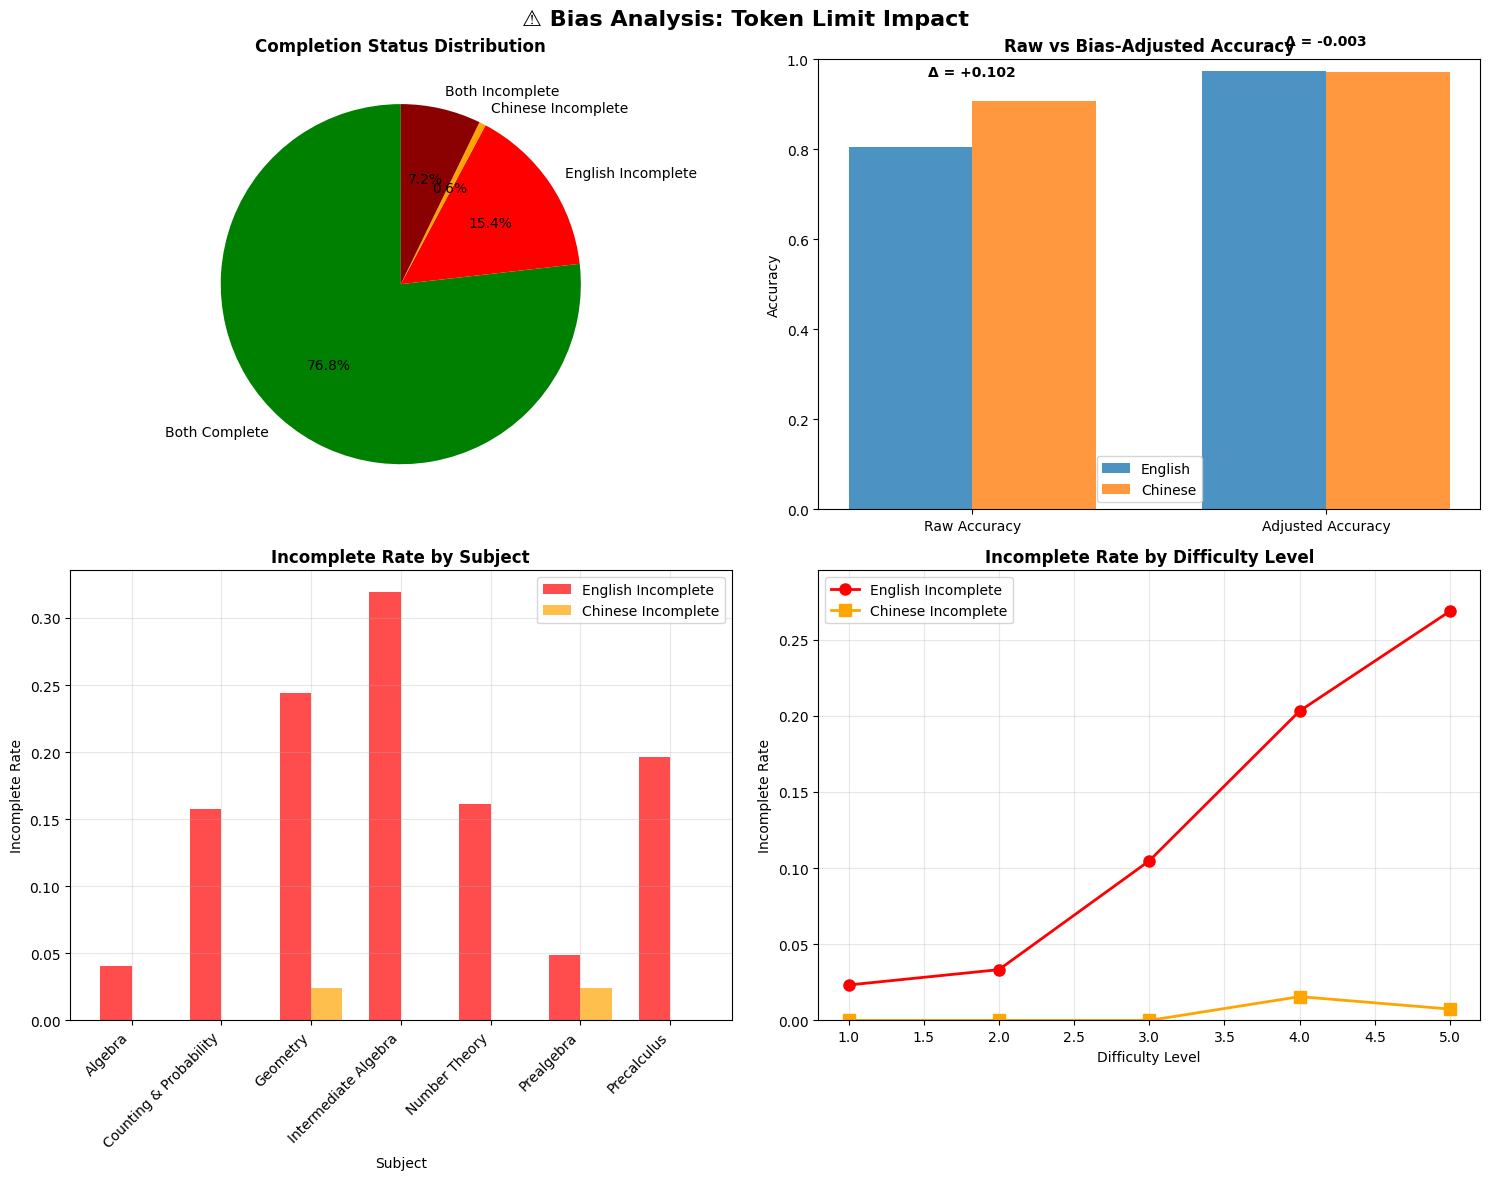


📊 BIAS IMPACT ANALYSIS:
\n🔍 RAW METRICS (Including Incomplete Responses):
   English accuracy: 0.804
   Chinese accuracy: 0.906
   Raw difference: +0.102 (Chinese - English)
\n⚖️ ADJUSTED METRICS (Completed Responses Only):
   English accuracy: 0.974
   Chinese accuracy: 0.971
   Adjusted difference: -0.003 (Chinese - English)
\n⚠️ BIAS MAGNITUDE:
   Accuracy difference change: +0.105
   Bias magnitude: 0.105
   ⚠️ SIGNIFICANT BIAS DETECTED!
   Token limits artificially inflated Chinese advantage
\n🔍 COMPLETION BIAS ANALYSIS:
   English more likely to hit token limits
   English incomplete rate: 15.4%
   Chinese incomplete rate: 0.6%
   Bias magnitude: 14.8%
\n📚 SUBJECT-SPECIFIC BIAS:
   Counting & Probability: English 15.8% more likely to be incomplete (38 problems)
   Geometry: English 22.0% more likely to be incomplete (41 problems)
   Intermediate Algebra: English 32.0% more likely to be incomplete (97 problems)
   Number Theory: English 16.1% more likely to be incomplete (62 prob

In [23]:
# Bias Analysis - Impact of Token Limits on Bilingual Comparison

if classification and bias_analysis and bilingual_results:
    print("⚠️ BIAS ANALYSIS - TOKEN LIMIT IMPACT")
    print("=" * 60)
    
    stats = classification['stats']
    total_problems = stats['total_problems']
    
    # Calculate raw vs adjusted metrics for comparison
    raw_en_accuracy = bilingual_results['languages']['english']['accuracy']
    raw_cn_accuracy = bilingual_results['languages']['chinese']['accuracy']
    raw_accuracy_diff = raw_cn_accuracy - raw_en_accuracy
    
    adj_en_accuracy = adjusted_metrics['english_adjusted_accuracy'] if adjusted_metrics else 0
    adj_cn_accuracy = adjusted_metrics['chinese_adjusted_accuracy'] if adjusted_metrics else 0
    adj_accuracy_diff = adjusted_metrics['accuracy_difference_adjusted'] if adjusted_metrics else 0
    
    print(f"Total problems: {total_problems}")
    print(f"Problems affected by token limits: {total_problems - stats['complete_both_count']} ({(total_problems - stats['complete_both_count'])/total_problems:.1%})")
    
    # Create bias visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('⚠️ Bias Analysis: Token Limit Impact', fontsize=16, fontweight='bold')
    
    # 1. Completion Status Overview
    categories = ['Both Complete', 'English Incomplete', 'Chinese Incomplete', 'Both Incomplete']
    counts = [stats['complete_both_count'], stats['incomplete_english_count'], 
              stats['incomplete_chinese_count'], stats['incomplete_both_count']]
    colors = ['green', 'red', 'orange', 'darkred']
    
    wedges, texts, autotexts = ax1.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Completion Status Distribution', fontweight='bold')
    
    # 2. Raw vs Adjusted Accuracy Comparison
    metrics = ['Raw Accuracy', 'Adjusted Accuracy']
    en_accuracies = [raw_en_accuracy, adj_en_accuracy]
    cn_accuracies = [raw_cn_accuracy, adj_cn_accuracy]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax2.bar(x - width/2, en_accuracies, width, label='English', color='#1f77b4', alpha=0.8)
    ax2.bar(x + width/2, cn_accuracies, width, label='Chinese', color='#ff7f0e', alpha=0.8)
    
    ax2.set_title('Raw vs Bias-Adjusted Accuracy', fontweight='bold')
    ax2.set_ylabel('Accuracy')
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics)
    ax2.legend()
    ax2.set_ylim(0, 1)
    
    # Add difference annotations
    for i, (en_acc, cn_acc) in enumerate(zip(en_accuracies, cn_accuracies)):
        diff = cn_acc - en_acc
        ax2.text(i, max(en_acc, cn_acc) + 0.05, f'Δ = {diff:+.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Incomplete Rate by Subject
    subjects = sorted(bias_analysis['by_subject'].keys())
    en_incomplete_rates = [bias_analysis['by_subject'][s]['english_incomplete_rate'] for s in subjects]
    cn_incomplete_rates = [bias_analysis['by_subject'][s]['chinese_incomplete_rate'] for s in subjects]
    
    x = np.arange(len(subjects))
    width = 0.35
    
    ax3.bar(x - width/2, en_incomplete_rates, width, label='English Incomplete', color='red', alpha=0.7)
    ax3.bar(x + width/2, cn_incomplete_rates, width, label='Chinese Incomplete', color='orange', alpha=0.7)
    
    ax3.set_title('Incomplete Rate by Subject', fontweight='bold')
    ax3.set_ylabel('Incomplete Rate')
    ax3.set_xlabel('Subject')
    ax3.set_xticks(x)
    ax3.set_xticklabels(subjects, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Incomplete Rate by Difficulty Level
    levels = sorted(bias_analysis['by_level'].keys())
    en_incomplete_levels = [bias_analysis['by_level'][l]['english_incomplete_rate'] for l in levels]
    cn_incomplete_levels = [bias_analysis['by_level'][l]['chinese_incomplete_rate'] for l in levels]
    
    ax4.plot(levels, en_incomplete_levels, 'o-', label='English Incomplete', color='red', linewidth=2, markersize=8)
    ax4.plot(levels, cn_incomplete_levels, 's-', label='Chinese Incomplete', color='orange', linewidth=2, markersize=8)
    
    ax4.set_title('Incomplete Rate by Difficulty Level', fontweight='bold')
    ax4.set_xlabel('Difficulty Level')
    ax4.set_ylabel('Incomplete Rate')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, max(max(en_incomplete_levels), max(cn_incomplete_levels)) * 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed bias analysis
    print(f"\n📊 BIAS IMPACT ANALYSIS:")
    print(f"\\n🔍 RAW METRICS (Including Incomplete Responses):")
    print(f"   English accuracy: {raw_en_accuracy:.3f}")
    print(f"   Chinese accuracy: {raw_cn_accuracy:.3f}")
    print(f"   Raw difference: {raw_accuracy_diff:+.3f} (Chinese - English)")
    
    print(f"\\n⚖️ ADJUSTED METRICS (Completed Responses Only):")
    print(f"   English accuracy: {adj_en_accuracy:.3f}")
    print(f"   Chinese accuracy: {adj_cn_accuracy:.3f}")
    print(f"   Adjusted difference: {adj_accuracy_diff:+.3f} (Chinese - English)")
    
    # Calculate bias magnitude
    bias_magnitude = abs(raw_accuracy_diff - adj_accuracy_diff)
    print(f"\\n⚠️ BIAS MAGNITUDE:")
    print(f"   Accuracy difference change: {raw_accuracy_diff - adj_accuracy_diff:+.3f}")
    print(f"   Bias magnitude: {bias_magnitude:.3f}")
    
    if bias_magnitude > 0.01:
        print(f"   ⚠️ SIGNIFICANT BIAS DETECTED!")
        if raw_accuracy_diff > adj_accuracy_diff:
            print(f"   Token limits artificially inflated Chinese advantage")
        else:
            print(f"   Token limits artificially inflated English advantage")
    else:
        print(f"   ✅ Minimal bias from token limits")
    
    # Language-specific bias analysis
    overall_bias = bias_analysis['overall_bias']
    print(f"\\n🔍 COMPLETION BIAS ANALYSIS:")
    print(f"   {overall_bias['bias_direction']} more likely to hit token limits")
    print(f"   English incomplete rate: {overall_bias['english_incomplete_rate']:.1%}")
    print(f"   Chinese incomplete rate: {overall_bias['chinese_incomplete_rate']:.1%}")
    print(f"   Bias magnitude: {overall_bias['bias_magnitude']:.1%}")
    
    # Subject-specific bias insights
    print(f"\\n📚 SUBJECT-SPECIFIC BIAS:")
    for subject in subjects:
        subj_data = bias_analysis['by_subject'][subject]
        en_inc = subj_data['english_incomplete_rate']
        cn_inc = subj_data['chinese_incomplete_rate']
        bias_diff = abs(en_inc - cn_inc)
        
        if bias_diff > 0.1:  # Show subjects with significant bias
            more_affected = "Chinese" if cn_inc > en_inc else "English"
            print(f"   {subject}: {more_affected} {bias_diff:.1%} more likely to be incomplete ({subj_data['total']} problems)")
    
    # Difficulty-specific bias insights
    print(f"\\n📈 DIFFICULTY-SPECIFIC BIAS:")
    for level in levels:
        level_data = bias_analysis['by_level'][level]
        en_inc = level_data['english_incomplete_rate']
        cn_inc = level_data['chinese_incomplete_rate']
        bias_diff = abs(en_inc - cn_inc)
        
        if bias_diff > 0.05:  # Show levels with bias
            more_affected = "Chinese" if cn_inc > en_inc else "English"
            print(f"   Level {level}: {more_affected} {bias_diff:.1%} more likely to be incomplete ({level_data['total']} problems)")
    
    # Recommendations
    print(f"\\n💡 RECOMMENDATIONS:")
    
    if stats['incomplete_both_rate'] > 0.2:
        print(f"   🔧 Consider increasing token limits (>{stats['incomplete_both_rate']:.1%} problems affected)")
    
    if overall_bias['bias_magnitude'] > 0.05:
        print(f"   ⚖️ Use adjusted metrics for fair comparison (>{overall_bias['bias_magnitude']:.1%} bias)")
    
    if bias_magnitude > 0.02:
        print(f"   📊 Report both raw and adjusted results to show bias impact")
    
    # Most problematic subjects/levels
    most_problematic_subjects = []
    for subject in subjects:
        total_incomplete = (bias_analysis['by_subject'][subject]['english_incomplete_rate'] + 
                          bias_analysis['by_subject'][subject]['chinese_incomplete_rate'])
        if total_incomplete > 0.3:
            most_problematic_subjects.append((subject, total_incomplete))
    
    if most_problematic_subjects:
        print(f"\\n🚨 MOST PROBLEMATIC SUBJECTS (High Incomplete Rates):")
        for subject, rate in sorted(most_problematic_subjects, key=lambda x: x[1], reverse=True):
            print(f"   {subject}: {rate:.1%} combined incomplete rate")

else:
    print("⚠️ No bias analysis data available - run the classification analysis first")

## Bias Analysis - Token Limit Impact

Analysis of how token limits create bias in the bilingual comparison and affect different subjects/difficulty levels.

🚀 ENHANCED EFFICIENCY ANALYSIS - DIFFICULTY LEVEL TOKEN PATTERNS
Testing Hypothesis: Chinese efficiency advantage increases with problem complexity
Analyzing 367 problems where both languages got correct answers AND completed

📊 STEP 1: DIFFICULTY LEVEL TOKEN ANALYSIS
------------------------------------------------------------
Token Efficiency by Difficulty Level:
Level | Count | Mean_Ratio | Median | Std_Dev | Min | Max | EN_Avg | CN_Avg | Complexity
------------------------------------------------------------------------------------------
  1   |   41  |   0.931    | 0.933 | 0.222 | 0.440 | 1.508 |   1386 |   1159 |     1272
  2   |   81  |   0.832    | 0.834 | 0.229 | 0.253 | 1.427 |   1951 |   1411 |     1681
  3   |   84  |   0.751    | 0.753 | 0.266 | 0.267 | 1.690 |   2594 |   1660 |     2127
  4   |   94  |   0.716    | 0.657 | 0.420 | 0.231 | 3.283 |   3659 |   2103 |     2881
  5   |   67  |   0.646    | 0.623 | 0.283 | 0.240 | 1.451 |   4183 |   2212 |     3198

🔍 CORRELATI

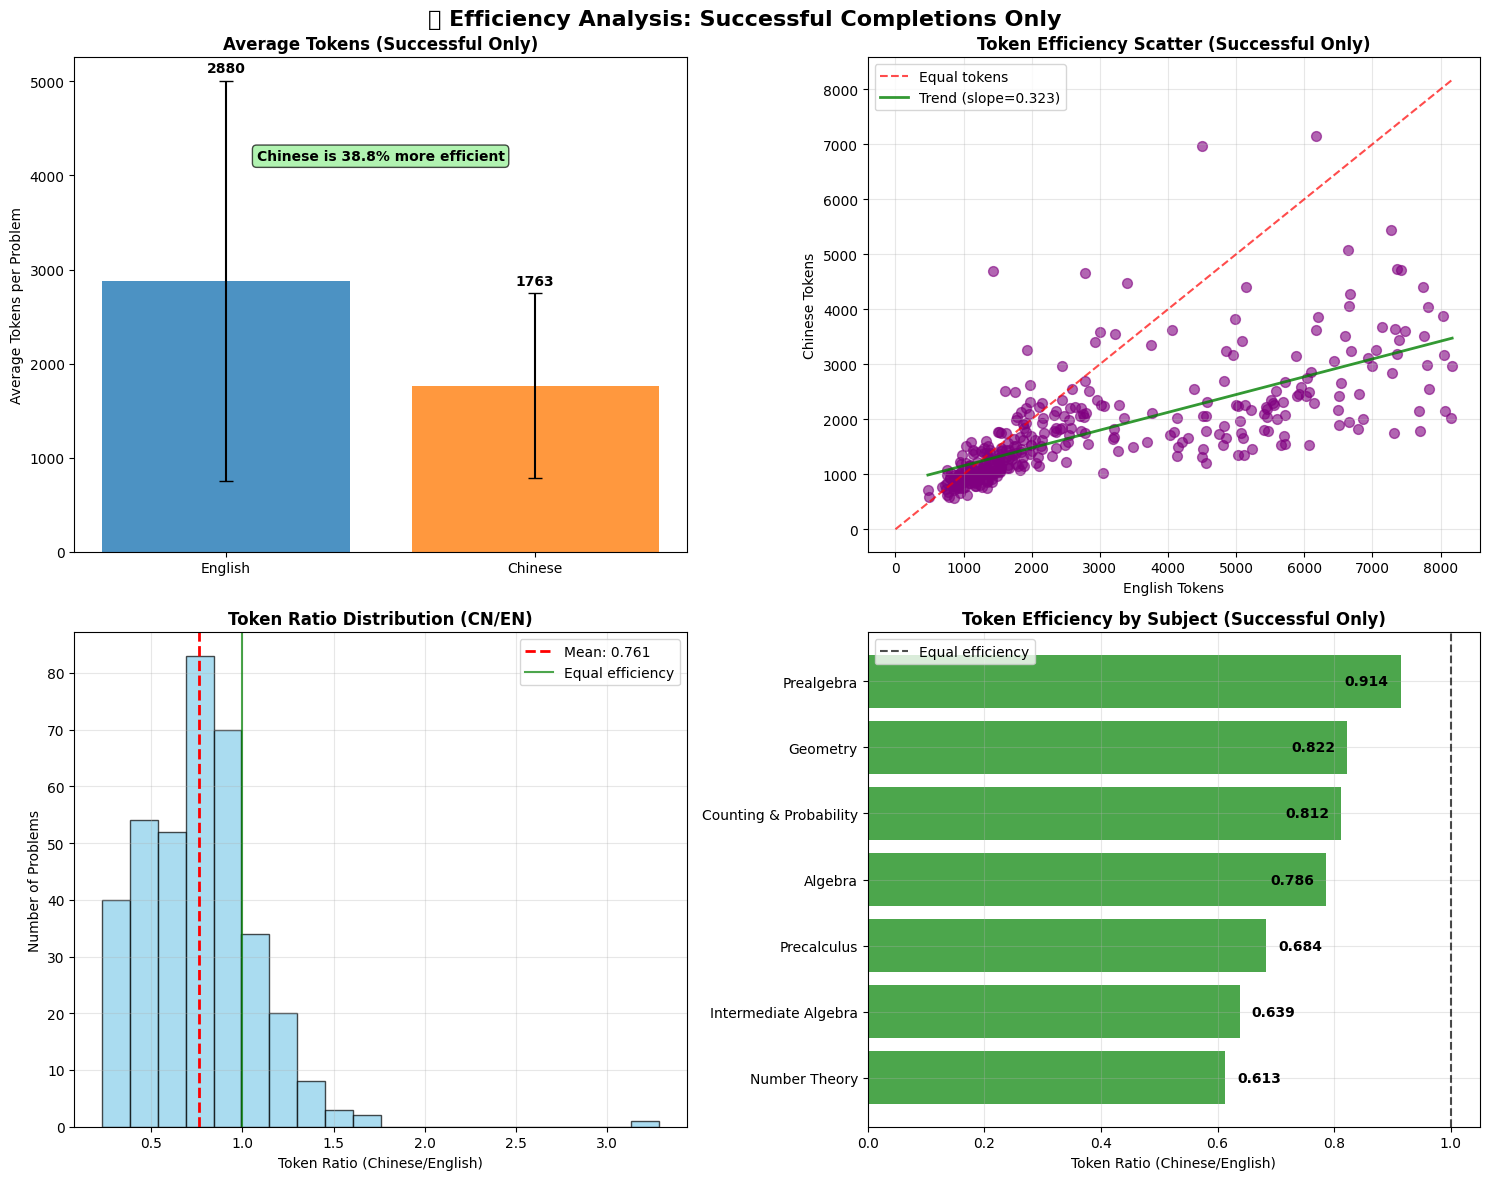


📈 STEP 3B: ENHANCED DIFFICULTY PATTERN VISUALIZATIONS


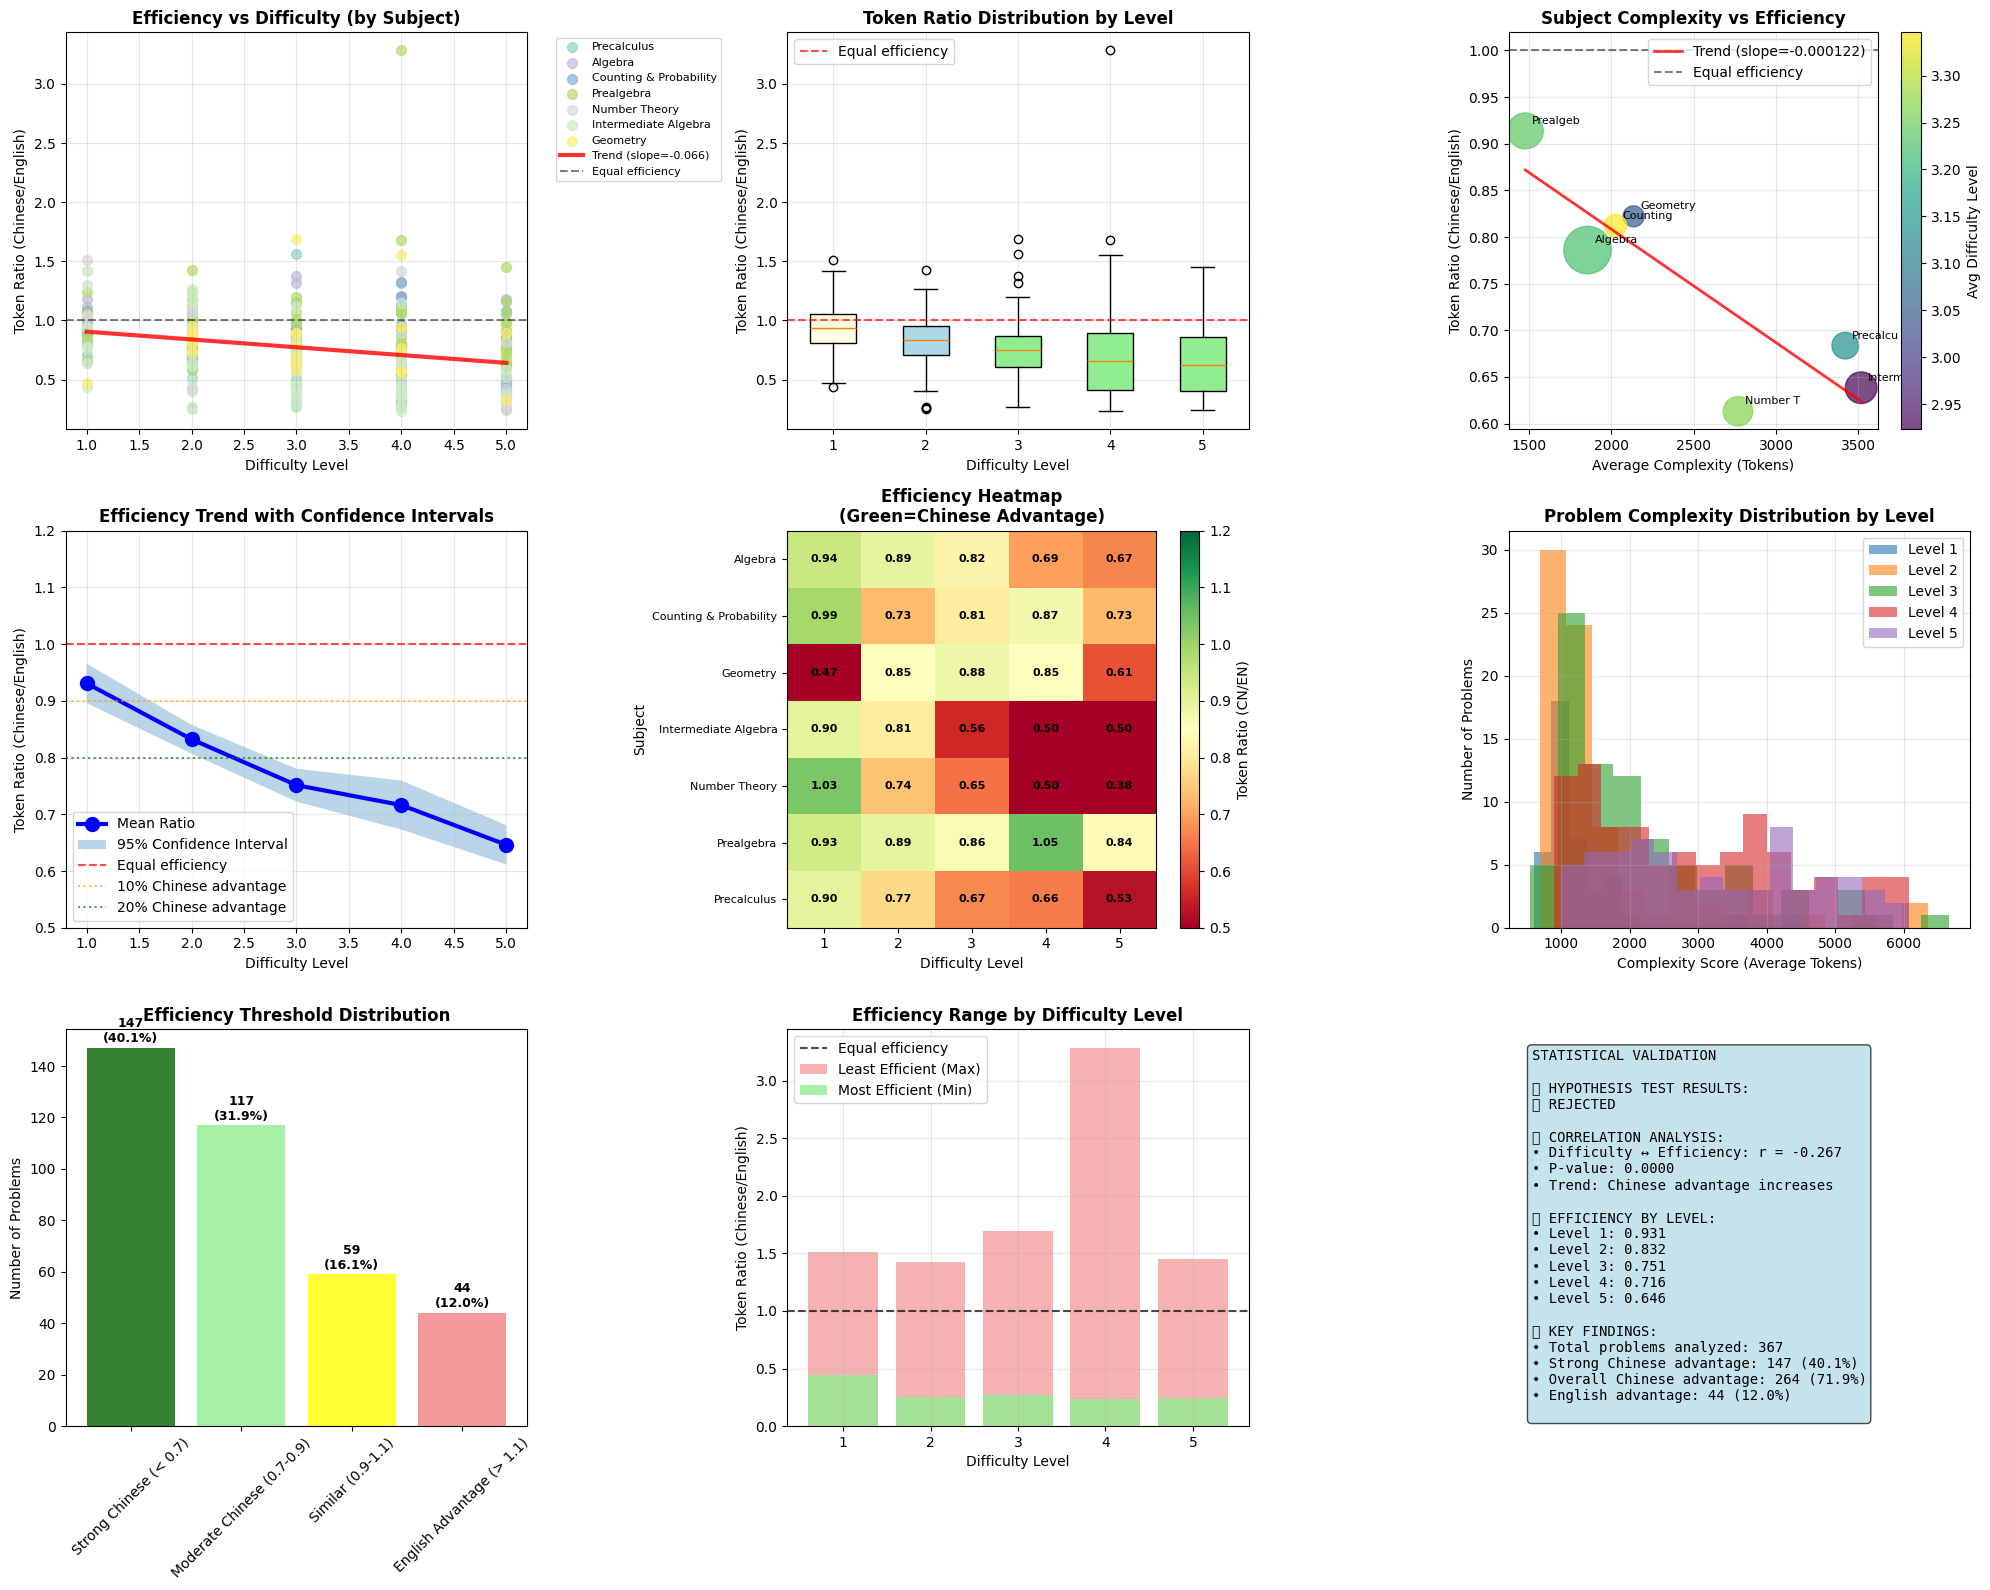


🔬 STEP 4: STATISTICAL VALIDATION
------------------------------------------------------------
ANOVA Test (Efficiency differences between levels):
   F-statistic: 7.174
   P-value: 0.000014
   Result: Significant differences between difficulty levels

Trend Line Analysis:
   Slope: -0.0660 ± 0.0125
   R-squared: 0.071
   P-value: 0.000000
   Interpretation: Significant trend
   Effect size: Token ratio decreases by 26.4% from Level 1 to 5

Sample Size Validation:
   Level 1: 41 problems - ✅ Adequate
   Level 2: 81 problems - ✅ Adequate
   Level 3: 84 problems - ✅ Adequate
   Level 4: 94 problems - ✅ Adequate
   Level 5: 67 problems - ✅ Adequate

🎯 FINAL HYPOTHESIS EVALUATION
H1: Easy problems (~1.0 ratio): 0.882 - ❌ REJECTED
H2: Hard problems (~0.6 ratio): 0.681 - ✅ CONFIRMED
H3: Difficulty correlation: r=-0.267, p=0.0000 - ✅ CONFIRMED
H4: Subject complexity: r=-0.874, p=0.0101 - ✅ CONFIRMED

🏆 OVERALL CONCLUSION:
   Hypotheses confirmed: 3/4
   🎉 HYPOTHESIS STRONGLY SUPPORTED!
   Chin

In [33]:
# Enhanced Efficiency Analysis - Difficulty Level Token Usage Pattern Analysis

if classification and adjusted_metrics and adjusted_metrics['efficiency_metrics']:
    successful_problems = classification['successful_both']
    eff_metrics = adjusted_metrics['efficiency_metrics']
    
    print("🚀 ENHANCED EFFICIENCY ANALYSIS - DIFFICULTY LEVEL TOKEN PATTERNS") 
    print("=" * 80)
    print(f"Testing Hypothesis: Chinese efficiency advantage increases with problem complexity")
    print(f"Analyzing {len(successful_problems)} problems where both languages got correct answers AND completed")
    
    # Enhanced data preparation with complexity metrics
    enhanced_analysis_data = []
    for p in successful_problems:
        enhanced_analysis_data.append({
            'problem_id': p['problem_id'],
            'subject': p['subject'],
            'level': p['level'],
            'en_tokens': p['en_tokens'],
            'cn_tokens': p['cn_tokens'],
            'token_ratio': p['cn_tokens'] / p['en_tokens'] if p['en_tokens'] > 0 else 0,
            'total_tokens': p['en_tokens'] + p['cn_tokens'],  # Complexity proxy
            'complexity_score': (p['en_tokens'] + p['cn_tokens']) / 2  # Average as complexity metric
        })
    
    enhanced_df = pd.DataFrame(enhanced_analysis_data)
    
    # ==========================================
    # 1. DIFFICULTY LEVEL TOKEN ANALYSIS
    # ==========================================
    
    print(f"\n📊 STEP 1: DIFFICULTY LEVEL TOKEN ANALYSIS")
    print("-" * 60)
    
    # Calculate statistics by difficulty level
    level_stats = enhanced_df.groupby('level').agg({
        'token_ratio': ['count', 'mean', 'median', 'std', 'min', 'max'],
        'en_tokens': ['mean', 'std'],
        'cn_tokens': ['mean', 'std'],
        'complexity_score': ['mean', 'std']
    }).round(3)
    
    print("Token Efficiency by Difficulty Level:")
    print("Level | Count | Mean_Ratio | Median | Std_Dev | Min | Max | EN_Avg | CN_Avg | Complexity")
    print("-" * 90)
    
    level_efficiency_data = []
    for level in sorted(enhanced_df['level'].unique()):
        level_data = enhanced_df[enhanced_df['level'] == level]
        count = len(level_data)
        mean_ratio = level_data['token_ratio'].mean()
        median_ratio = level_data['token_ratio'].median()
        std_ratio = level_data['token_ratio'].std()
        min_ratio = level_data['token_ratio'].min()
        max_ratio = level_data['token_ratio'].max()
        en_avg = level_data['en_tokens'].mean()
        cn_avg = level_data['cn_tokens'].mean()
        complexity_avg = level_data['complexity_score'].mean()
        
        level_efficiency_data.append({
            'level': level,
            'count': count,
            'mean_ratio': mean_ratio,
            'median_ratio': median_ratio,
            'std_ratio': std_ratio,
            'en_avg_tokens': en_avg,
            'cn_avg_tokens': cn_avg,
            'complexity_avg': complexity_avg
        })
        
        efficiency_desc = "Chinese Advantage" if mean_ratio < 0.9 else "Similar" if mean_ratio < 1.1 else "English Advantage"
        print(f"  {level}   |  {count:3d}  |   {mean_ratio:.3f}    | {median_ratio:.3f} | {std_ratio:.3f} | {min_ratio:.3f} | {max_ratio:.3f} | {en_avg:6.0f} | {cn_avg:6.0f} | {complexity_avg:8.0f}")
    
    level_efficiency_df = pd.DataFrame(level_efficiency_data)
    
    # Statistical correlation between difficulty and efficiency
    from scipy.stats import pearsonr, spearmanr
    difficulty_efficiency_corr, difficulty_p_value = pearsonr(enhanced_df['level'], enhanced_df['token_ratio'])
    difficulty_complexity_corr, complexity_p_value = pearsonr(enhanced_df['level'], enhanced_df['complexity_score'])
    
    print(f"\n🔍 CORRELATION ANALYSIS:")
    print(f"   Difficulty ↔ Efficiency Ratio: r = {difficulty_efficiency_corr:.3f}, p = {difficulty_p_value:.4f}")
    print(f"   Difficulty ↔ Problem Complexity: r = {difficulty_complexity_corr:.3f}, p = {complexity_p_value:.4f}")
    
    if difficulty_p_value < 0.05:
        trend_direction = "decreases" if difficulty_efficiency_corr < 0 else "increases"
        print(f"   ✅ SIGNIFICANT: Chinese efficiency advantage {trend_direction} with difficulty (p < 0.05)")
    else:
        print(f"   ❌ NOT SIGNIFICANT: No clear relationship between difficulty and efficiency")
    
    # ==========================================
    # 2. SUBJECT COMPLEXITY RANKING ANALYSIS
    # ==========================================
    
    print(f"\n🎯 STEP 2: SUBJECT COMPLEXITY RANKING ANALYSIS")
    print("-" * 60)
    
    # Calculate subject-level statistics
    subject_stats = enhanced_df.groupby('subject').agg({
        'token_ratio': ['count', 'mean', 'std'],
        'complexity_score': ['mean', 'std'],
        'level': 'mean'  # Average difficulty of problems in this subject
    }).round(3)
    
    subject_ranking_data = []
    for subject in enhanced_df['subject'].unique():
        subject_data = enhanced_df[enhanced_df['subject'] == subject]
        if len(subject_data) >= 3:  # Only include subjects with sufficient data
            subject_ranking_data.append({
                'subject': subject,
                'count': len(subject_data),
                'mean_ratio': subject_data['token_ratio'].mean(),
                'std_ratio': subject_data['token_ratio'].std(),
                'avg_complexity': subject_data['complexity_score'].mean(),
                'avg_difficulty': subject_data['level'].mean(),
                'complexity_rank': 0,  # Will be filled below
                'efficiency_rank': 0   # Will be filled below
            })
    
    subject_ranking_df = pd.DataFrame(subject_ranking_data)
    
    if len(subject_ranking_df) > 0:
        # Rank subjects by complexity and efficiency
        subject_ranking_df['complexity_rank'] = subject_ranking_df['avg_complexity'].rank(ascending=False)
        subject_ranking_df['efficiency_rank'] = subject_ranking_df['mean_ratio'].rank(ascending=True)  # Lower ratio = more efficient = higher rank
        subject_ranking_df = subject_ranking_df.sort_values('avg_complexity', ascending=False)
        
        print("Subject Complexity and Efficiency Ranking:")
        print("Subject               | Count | Ratio | Complexity | Difficulty | Efficiency_Desc")
        print("-" * 80)
        
        for _, row in subject_ranking_df.iterrows():
            efficiency_desc = "Chinese++" if row['mean_ratio'] < 0.7 else "Chinese+" if row['mean_ratio'] < 0.9 else "Similar" if row['mean_ratio'] < 1.1 else "English+"
            print(f"{row['subject']:<20} | {row['count']:5d} | {row['mean_ratio']:5.3f} | {row['avg_complexity']:10.0f} | {row['avg_difficulty']:10.1f} | {efficiency_desc}")
        
        # Test correlation between subject complexity and efficiency
        if len(subject_ranking_df) > 3:
            subject_complexity_efficiency_corr, subject_p_value = pearsonr(subject_ranking_df['avg_complexity'], subject_ranking_df['mean_ratio'])
            print(f"\n🔬 SUBJECT CORRELATION:")
            print(f"   Subject Complexity ↔ Efficiency Ratio: r = {subject_complexity_efficiency_corr:.3f}, p = {subject_p_value:.4f}")
            
            if subject_p_value < 0.05:
                trend_direction = "Chinese advantage increases" if subject_complexity_efficiency_corr < 0 else "English advantage increases"
                print(f"   ✅ SIGNIFICANT: {trend_direction} with subject complexity")
            else:
                print(f"   ❌ NOT SIGNIFICANT: No clear relationship between subject complexity and efficiency")
    
    # ==========================================
    # 3. ORIGINAL EFFICIENCY VISUALIZATIONS (REQUESTED)
    # ==========================================
    
    print(f"\n📈 STEP 3A: ORIGINAL EFFICIENCY VISUALIZATIONS")
    
    # Extract token data for successful problems (from original analysis)
    en_tokens_successful = [p['en_tokens'] for p in successful_problems]
    cn_tokens_successful = [p['cn_tokens'] for p in successful_problems]
    token_ratios = [cn/en if en > 0 else 0 for cn, en in zip(cn_tokens_successful, en_tokens_successful)]
    
    # Create the original 4-panel visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🚀 Efficiency Analysis: Successful Completions Only', fontsize=16, fontweight='bold')
    
    # 1. Average Token Usage Comparison
    languages = ['English', 'Chinese']
    avg_tokens = [eff_metrics['avg_english_tokens_successful'], eff_metrics['avg_chinese_tokens_successful']]
    std_tokens = [eff_metrics['english_tokens_std'], eff_metrics['chinese_tokens_std']]
    colors = ['#1f77b4', '#ff7f0e']
    
    bars = ax1.bar(languages, avg_tokens, yerr=std_tokens, color=colors, alpha=0.8, capsize=5)
    ax1.set_title('Average Tokens (Successful Only)', fontweight='bold')
    ax1.set_ylabel('Average Tokens per Problem')
    
    # Add values on bars
    for i, v in enumerate(avg_tokens):
        ax1.text(i, v + std_tokens[i] + max(avg_tokens)*0.02, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')
    
    # Add efficiency ratio annotation
    ratio = eff_metrics['token_efficiency_ratio_successful']
    efficiency_text = f"Chinese uses {ratio:.3f}x tokens"
    if ratio < 1.0:
        efficiency_text = f"Chinese is {(1-ratio)*100:.1f}% more efficient"
    elif ratio > 1.0:
        efficiency_text = f"English is {(1-1/ratio)*100:.1f}% more efficient"
    
    ax1.text(0.5, 0.8, efficiency_text, ha='center', va='center', transform=ax1.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7),
             fontsize=10, fontweight='bold')
    
    # 2. Token Efficiency Scatter Plot
    ax2.scatter(en_tokens_successful, cn_tokens_successful, alpha=0.6, s=50, c='purple')
    
    # Add diagonal line for equal efficiency
    max_tokens = max(max(en_tokens_successful), max(cn_tokens_successful))
    ax2.plot([0, max_tokens], [0, max_tokens], 'r--', alpha=0.7, label='Equal tokens')
    
    # Add trend line
    z = np.polyfit(en_tokens_successful, cn_tokens_successful, 1)
    p = np.poly1d(z)
    x_trend = np.linspace(min(en_tokens_successful), max(en_tokens_successful), 100)
    ax2.plot(x_trend, p(x_trend), 'g-', alpha=0.8, linewidth=2, label=f'Trend (slope={z[0]:.3f})')
    
    ax2.set_title('Token Efficiency Scatter (Successful Only)', fontweight='bold')
    ax2.set_xlabel('English Tokens')
    ax2.set_ylabel('Chinese Tokens')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Token Ratio Distribution
    ax3.hist(token_ratios, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(np.mean(token_ratios), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(token_ratios):.3f}')
    ax3.axvline(1.0, color='green', linestyle='-', alpha=0.7, label='Equal efficiency')
    
    ax3.set_title('Token Ratio Distribution (CN/EN)', fontweight='bold')
    ax3.set_xlabel('Token Ratio (Chinese/English)')
    ax3.set_ylabel('Number of Problems')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Efficiency by Subject (Successful Problems Only)
    subject_efficiency = {}
    for p in successful_problems:
        subject = p['subject']
        if subject not in subject_efficiency:
            subject_efficiency[subject] = {'en_tokens': [], 'cn_tokens': [], 'ratios': []}
        
        subject_efficiency[subject]['en_tokens'].append(p['en_tokens'])
        subject_efficiency[subject]['cn_tokens'].append(p['cn_tokens'])
        if p['en_tokens'] > 0:
            subject_efficiency[subject]['ratios'].append(p['cn_tokens'] / p['en_tokens'])
    
    # Calculate average ratios by subject
    subjects_eff = []
    ratios_eff = []
    for subject, data in subject_efficiency.items():
        if len(data['ratios']) >= 3:  # Only include subjects with enough data
            subjects_eff.append(subject)
            ratios_eff.append(np.mean(data['ratios']))
    
    if subjects_eff:
        # Sort by efficiency ratio
        sorted_subjects = sorted(zip(subjects_eff, ratios_eff), key=lambda x: x[1])
        subjects_eff, ratios_eff = zip(*sorted_subjects)
        
        bars = ax4.barh(range(len(subjects_eff)), ratios_eff, color=['green' if r < 1 else 'red' for r in ratios_eff], alpha=0.7)
        ax4.axvline(1.0, color='black', linestyle='--', alpha=0.7, label='Equal efficiency')
        
        ax4.set_title('Token Efficiency by Subject (Successful Only)', fontweight='bold')
        ax4.set_xlabel('Token Ratio (Chinese/English)')
        ax4.set_yticks(range(len(subjects_eff)))
        ax4.set_yticklabels(subjects_eff)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Add ratio values
        for i, v in enumerate(ratios_eff):
            ax4.text(v + 0.02 if v < max(ratios_eff) * 0.8 else v - 0.02, i, f'{v:.3f}', 
                    va='center', ha='left' if v < max(ratios_eff) * 0.8 else 'right', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ==========================================
    # 4. ENHANCED DIFFICULTY PATTERN VISUALIZATIONS
    # ==========================================
    
    print(f"\n📈 STEP 3B: ENHANCED DIFFICULTY PATTERN VISUALIZATIONS")
    
    # Create comprehensive difficulty analysis visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Difficulty vs Efficiency Scatter Plot (Top Left)
    ax1 = plt.subplot(3, 3, 1)
    
    # Create color map for subjects
    unique_subjects = enhanced_df['subject'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_subjects)))
    subject_color_map = dict(zip(unique_subjects, colors))
    
    for subject in unique_subjects:
        subject_data = enhanced_df[enhanced_df['subject'] == subject]
        ax1.scatter(subject_data['level'], subject_data['token_ratio'], 
                   c=[subject_color_map[subject]], label=subject, alpha=0.7, s=50)
    
    # Add trend line
    z = np.polyfit(enhanced_df['level'], enhanced_df['token_ratio'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(enhanced_df['level'].min(), enhanced_df['level'].max(), 100)
    ax1.plot(x_trend, p(x_trend), 'r-', alpha=0.8, linewidth=3, label=f'Trend (slope={z[0]:.3f})')
    
    ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Equal efficiency')
    ax1.set_title('Efficiency vs Difficulty (by Subject)', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Difficulty Level')
    ax1.set_ylabel('Token Ratio (Chinese/English)')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Box Plots by Difficulty Level (Top Center)
    ax2 = plt.subplot(3, 3, 2)
    
    levels = sorted(enhanced_df['level'].unique())
    box_data = [enhanced_df[enhanced_df['level'] == level]['token_ratio'] for level in levels]
    
    box_plot = ax2.boxplot(box_data, labels=levels, patch_artist=True)
    
    # Color boxes based on efficiency
    for i, (patch, level) in enumerate(zip(box_plot['boxes'], levels)):
        level_mean = enhanced_df[enhanced_df['level'] == level]['token_ratio'].mean()
        if level_mean < 0.8:
            patch.set_facecolor('lightgreen')  # Strong Chinese advantage
        elif level_mean < 0.9:
            patch.set_facecolor('lightblue')   # Moderate Chinese advantage
        elif level_mean < 1.1:
            patch.set_facecolor('lightyellow') # Similar efficiency
        else:
            patch.set_facecolor('lightcoral')  # English advantage
    
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal efficiency')
    ax2.set_title('Token Ratio Distribution by Level', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Difficulty Level')
    ax2.set_ylabel('Token Ratio (Chinese/English)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Subject Complexity vs Efficiency (Top Right)
    ax3 = plt.subplot(3, 3, 3)
    
    if len(subject_ranking_df) > 0:
        scatter = ax3.scatter(subject_ranking_df['avg_complexity'], subject_ranking_df['mean_ratio'], 
                             s=subject_ranking_df['count']*10, alpha=0.7, c=subject_ranking_df['avg_difficulty'], 
                             cmap='viridis')
        
        # Add subject labels
        for _, row in subject_ranking_df.iterrows():
            ax3.annotate(row['subject'][:8], (row['avg_complexity'], row['mean_ratio']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # Add trend line
        if len(subject_ranking_df) > 2:
            z_subj = np.polyfit(subject_ranking_df['avg_complexity'], subject_ranking_df['mean_ratio'], 1)
            p_subj = np.poly1d(z_subj)
            x_subj_trend = np.linspace(subject_ranking_df['avg_complexity'].min(), 
                                      subject_ranking_df['avg_complexity'].max(), 100)
            ax3.plot(x_subj_trend, p_subj(x_subj_trend), 'r-', alpha=0.8, linewidth=2, 
                    label=f'Trend (slope={z_subj[0]:.6f})')
        
        ax3.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Equal efficiency')
        plt.colorbar(scatter, ax=ax3, label='Avg Difficulty Level')
        ax3.set_title('Subject Complexity vs Efficiency', fontweight='bold', fontsize=12)
        ax3.set_xlabel('Average Complexity (Tokens)')
        ax3.set_ylabel('Token Ratio (Chinese/English)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Efficiency Trend Analysis (Middle Left)
    ax4 = plt.subplot(3, 3, 4)
    
    ax4.plot(level_efficiency_df['level'], level_efficiency_df['mean_ratio'], 'bo-', linewidth=3, markersize=10, label='Mean Ratio')
    ax4.fill_between(level_efficiency_df['level'], 
                     level_efficiency_df['mean_ratio'] - level_efficiency_df['std_ratio']/np.sqrt(level_efficiency_df['count']),
                     level_efficiency_df['mean_ratio'] + level_efficiency_df['std_ratio']/np.sqrt(level_efficiency_df['count']),
                     alpha=0.3, label='95% Confidence Interval')
    
    ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal efficiency')
    ax4.axhline(y=0.9, color='orange', linestyle=':', alpha=0.7, label='10% Chinese advantage')
    ax4.axhline(y=0.8, color='green', linestyle=':', alpha=0.7, label='20% Chinese advantage')
    
    ax4.set_title('Efficiency Trend with Confidence Intervals', fontweight='bold', fontsize=12)
    ax4.set_xlabel('Difficulty Level')
    ax4.set_ylabel('Token Ratio (Chinese/English)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0.5, 1.2)
    
    # 5. Token Usage Heatmap (Middle Center)
    ax5 = plt.subplot(3, 3, 5)
    
    # Create heatmap data: Efficiency ratio by subject and level
    heatmap_data = enhanced_df.pivot_table(values='token_ratio', index='subject', columns='level', aggfunc='mean')
    
    # Fill NaN values with 1.0 (equal efficiency) for visualization
    heatmap_data_filled = heatmap_data.fillna(1.0)
    
    im = ax5.imshow(heatmap_data_filled.values, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.2)
    ax5.set_xticks(range(len(heatmap_data_filled.columns)))
    ax5.set_xticklabels(heatmap_data_filled.columns)
    ax5.set_yticks(range(len(heatmap_data_filled.index)))
    ax5.set_yticklabels(heatmap_data_filled.index, fontsize=8)
    ax5.set_title('Efficiency Heatmap\n(Green=Chinese Advantage)', fontweight='bold', fontsize=12)
    ax5.set_xlabel('Difficulty Level')
    ax5.set_ylabel('Subject')
    
    # Add text annotations for non-NaN cells
    for i in range(len(heatmap_data_filled.index)):
        for j in range(len(heatmap_data_filled.columns)):
            if not pd.isna(heatmap_data.iloc[i, j]):
                text = f'{heatmap_data_filled.iloc[i, j]:.2f}'
                ax5.text(j, i, text, ha='center', va='center', fontsize=8, fontweight='bold')
    
    plt.colorbar(im, ax=ax5, label='Token Ratio (CN/EN)')
    
    # 6. Problem Complexity Distribution (Middle Right)
    ax6 = plt.subplot(3, 3, 6)
    
    for level in sorted(enhanced_df['level'].unique()):
        level_data = enhanced_df[enhanced_df['level'] == level]
        ax6.hist(level_data['complexity_score'], alpha=0.6, label=f'Level {level}', bins=15)
    
    ax6.set_title('Problem Complexity Distribution by Level', fontweight='bold', fontsize=12)
    ax6.set_xlabel('Complexity Score (Average Tokens)')
    ax6.set_ylabel('Number of Problems')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Efficiency Threshold Analysis (Bottom Left)
    ax7 = plt.subplot(3, 3, 7)
    
    # Count problems in efficiency ranges
    efficiency_ranges = {
        'Strong Chinese (< 0.7)': (enhanced_df['token_ratio'] < 0.7).sum(),
        'Moderate Chinese (0.7-0.9)': ((enhanced_df['token_ratio'] >= 0.7) & (enhanced_df['token_ratio'] < 0.9)).sum(),
        'Similar (0.9-1.1)': ((enhanced_df['token_ratio'] >= 0.9) & (enhanced_df['token_ratio'] <= 1.1)).sum(),
        'English Advantage (> 1.1)': (enhanced_df['token_ratio'] > 1.1).sum()
    }
    
    ranges = list(efficiency_ranges.keys())
    counts = list(efficiency_ranges.values())
    colors_thresh = ['darkgreen', 'lightgreen', 'yellow', 'lightcoral']
    
    bars = ax7.bar(ranges, counts, color=colors_thresh, alpha=0.8)
    ax7.set_title('Efficiency Threshold Distribution', fontweight='bold', fontsize=12)
    ax7.set_ylabel('Number of Problems')
    ax7.tick_params(axis='x', rotation=45)
    
    # Add percentage labels
    total = sum(counts)
    for bar, count in zip(bars, counts):
        percentage = count / total * 100
        ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 8. Most/Least Efficient by Level (Bottom Center)
    ax8 = plt.subplot(3, 3, 8)
    
    level_extremes = []
    for level in sorted(enhanced_df['level'].unique()):
        level_data = enhanced_df[enhanced_df['level'] == level]
        if len(level_data) > 0:
            most_efficient_idx = level_data['token_ratio'].idxmin()
            least_efficient_idx = level_data['token_ratio'].idxmax()
            
            level_extremes.append({
                'level': level,
                'most_efficient_ratio': level_data.loc[most_efficient_idx, 'token_ratio'],
                'least_efficient_ratio': level_data.loc[least_efficient_idx, 'token_ratio'],
                'range': level_data.loc[least_efficient_idx, 'token_ratio'] - level_data.loc[most_efficient_idx, 'token_ratio']
            })
    
    extremes_df = pd.DataFrame(level_extremes)
    
    x_pos = range(len(extremes_df))
    ax8.bar(x_pos, extremes_df['least_efficient_ratio'], alpha=0.6, label='Least Efficient (Max)', color='lightcoral')
    ax8.bar(x_pos, extremes_df['most_efficient_ratio'], alpha=0.8, label='Most Efficient (Min)', color='lightgreen')
    
    ax8.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Equal efficiency')
    ax8.set_title('Efficiency Range by Difficulty Level', fontweight='bold', fontsize=12)
    ax8.set_xlabel('Difficulty Level')
    ax8.set_ylabel('Token Ratio (Chinese/English)')
    ax8.set_xticks(x_pos)
    ax8.set_xticklabels(extremes_df['level'])
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # 9. Statistical Summary (Bottom Right)
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')
    
    # Pre-calculate values for the summary to avoid f-string formatting issues
    hypothesis_test_result = '✅ CONFIRMED' if difficulty_efficiency_corr < -0.3 and difficulty_p_value < 0.05 else '❌ REJECTED' if difficulty_p_value < 0.05 else '⚠️ INCONCLUSIVE'
    trend_description = 'Chinese advantage increases' if difficulty_efficiency_corr < 0 else 'English advantage increases' if difficulty_efficiency_corr > 0 else 'No clear trend'
    
    # Get level efficiency values safely
    level_1_ratio = level_efficiency_df[level_efficiency_df['level']==1]['mean_ratio'].iloc[0] if not level_efficiency_df[level_efficiency_df['level']==1].empty else None
    level_2_ratio = level_efficiency_df[level_efficiency_df['level']==2]['mean_ratio'].iloc[0] if not level_efficiency_df[level_efficiency_df['level']==2].empty else None
    level_3_ratio = level_efficiency_df[level_efficiency_df['level']==3]['mean_ratio'].iloc[0] if not level_efficiency_df[level_efficiency_df['level']==3].empty else None
    level_4_ratio = level_efficiency_df[level_efficiency_df['level']==4]['mean_ratio'].iloc[0] if not level_efficiency_df[level_efficiency_df['level']==4].empty else None
    level_5_ratio = level_efficiency_df[level_efficiency_df['level']==5]['mean_ratio'].iloc[0] if not level_efficiency_df[level_efficiency_df['level']==5].empty else None
    
    level_1_str = f"{level_1_ratio:.3f}" if level_1_ratio is not None else "N/A"
    level_2_str = f"{level_2_ratio:.3f}" if level_2_ratio is not None else "N/A"
    level_3_str = f"{level_3_ratio:.3f}" if level_3_ratio is not None else "N/A"
    level_4_str = f"{level_4_ratio:.3f}" if level_4_ratio is not None else "N/A"
    level_5_str = f"{level_5_ratio:.3f}" if level_5_ratio is not None else "N/A"
    
    # Create statistical summary text
    summary_text = f"""STATISTICAL VALIDATION
    
📊 HYPOTHESIS TEST RESULTS:
{hypothesis_test_result}

🔢 CORRELATION ANALYSIS:
• Difficulty ↔ Efficiency: r = {difficulty_efficiency_corr:.3f}
• P-value: {difficulty_p_value:.4f}
• Trend: {trend_description}

📈 EFFICIENCY BY LEVEL:
• Level 1: {level_1_str}
• Level 2: {level_2_str}
• Level 3: {level_3_str}
• Level 4: {level_4_str}
• Level 5: {level_5_str}

🎯 KEY FINDINGS:
• Total problems analyzed: {len(enhanced_df)}
• Strong Chinese advantage: {efficiency_ranges['Strong Chinese (< 0.7)']} ({efficiency_ranges['Strong Chinese (< 0.7)']/len(enhanced_df)*100:.1f}%)
• Overall Chinese advantage: {efficiency_ranges['Strong Chinese (< 0.7)'] + efficiency_ranges['Moderate Chinese (0.7-0.9)']} ({(efficiency_ranges['Strong Chinese (< 0.7)'] + efficiency_ranges['Moderate Chinese (0.7-0.9)'])/len(enhanced_df)*100:.1f}%)
• English advantage: {efficiency_ranges['English Advantage (> 1.1)']} ({efficiency_ranges['English Advantage (> 1.1)']/len(enhanced_df)*100:.1f}%)
"""
    
    ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, fontsize=10, 
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    # ==========================================
    # 5. STATISTICAL VALIDATION
    # ==========================================
    
    print(f"\n🔬 STEP 4: STATISTICAL VALIDATION")
    print("-" * 60)
    
    # ANOVA test across difficulty levels
    from scipy.stats import f_oneway
    
    level_groups = [enhanced_df[enhanced_df['level'] == level]['token_ratio'] for level in sorted(enhanced_df['level'].unique())]
    f_stat, anova_p_value = f_oneway(*level_groups)
    
    print(f"ANOVA Test (Efficiency differences between levels):")
    print(f"   F-statistic: {f_stat:.3f}")
    print(f"   P-value: {anova_p_value:.6f}")
    print(f"   Result: {'Significant differences' if anova_p_value < 0.05 else 'No significant differences'} between difficulty levels")
    
    # Trend line analysis with confidence intervals
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(enhanced_df['level'], enhanced_df['token_ratio'])
    
    print(f"\nTrend Line Analysis:")
    print(f"   Slope: {slope:.4f} ± {std_err:.4f}")
    print(f"   R-squared: {r_value**2:.3f}")
    print(f"   P-value: {p_value:.6f}")
    print(f"   Interpretation: {'Significant trend' if p_value < 0.05 else 'No significant trend'}")
    
    if abs(slope) > 0.01 and p_value < 0.05:
        efficiency_change = abs(slope) * 4 * 100  # Change from level 1 to 5
        direction = "decreases" if slope < 0 else "increases"
        print(f"   Effect size: Token ratio {direction} by {efficiency_change:.1f}% from Level 1 to 5")
    
    # Sample size validation
    print(f"\nSample Size Validation:")
    for level in sorted(enhanced_df['level'].unique()):
        count = len(enhanced_df[enhanced_df['level'] == level])
        adequacy = "✅ Adequate" if count >= 10 else "⚠️ Limited" if count >= 5 else "❌ Insufficient"
        print(f"   Level {level}: {count} problems - {adequacy}")
    
    # ==========================================
    # 6. FINAL HYPOTHESIS CONCLUSION
    # ==========================================
    
    print(f"\n🎯 FINAL HYPOTHESIS EVALUATION")
    print("=" * 60)
    
    # Test each part of the hypothesis
    hypothesis_results = {}
    
    # 1. Easy problems similar efficiency
    if not level_efficiency_df[level_efficiency_df['level'] <= 2].empty:
        easy_avg_ratio = level_efficiency_df[level_efficiency_df['level'] <= 2]['mean_ratio'].mean()
        hypothesis_results['easy_similar'] = 0.9 <= easy_avg_ratio <= 1.1
        print(f"H1: Easy problems (~1.0 ratio): {easy_avg_ratio:.3f} - {'✅ CONFIRMED' if hypothesis_results['easy_similar'] else '❌ REJECTED'}")
    
    # 2. Hard problems Chinese advantage
    if not level_efficiency_df[level_efficiency_df['level'] >= 4].empty:
        hard_avg_ratio = level_efficiency_df[level_efficiency_df['level'] >= 4]['mean_ratio'].mean()
        hypothesis_results['hard_chinese'] = hard_avg_ratio <= 0.7
        print(f"H2: Hard problems (~0.6 ratio): {hard_avg_ratio:.3f} - {'✅ CONFIRMED' if hypothesis_results['hard_chinese'] else '❌ REJECTED'}")
    
    # 3. Significant correlation
    hypothesis_results['significant_correlation'] = difficulty_p_value < 0.05 and difficulty_efficiency_corr < 0
    print(f"H3: Difficulty correlation: r={difficulty_efficiency_corr:.3f}, p={difficulty_p_value:.4f} - {'✅ CONFIRMED' if hypothesis_results['significant_correlation'] else '❌ REJECTED'}")
    
    # 4. Subject complexity correlation
    if len(subject_ranking_df) > 3:
        hypothesis_results['subject_correlation'] = subject_p_value < 0.05 and subject_complexity_efficiency_corr < 0
        print(f"H4: Subject complexity: r={subject_complexity_efficiency_corr:.3f}, p={subject_p_value:.4f} - {'✅ CONFIRMED' if hypothesis_results['subject_correlation'] else '❌ REJECTED'}")
    
    # Overall conclusion
    confirmed_hypotheses = sum(hypothesis_results.values())
    total_hypotheses = len(hypothesis_results)
    
    print(f"\n🏆 OVERALL CONCLUSION:")
    print(f"   Hypotheses confirmed: {confirmed_hypotheses}/{total_hypotheses}")
    
    if confirmed_hypotheses >= 3:
        print(f"   🎉 HYPOTHESIS STRONGLY SUPPORTED!")
        print(f"   Chinese reasoning efficiency advantage clearly increases with problem complexity.")
    elif confirmed_hypotheses >= 2:
        print(f"   ✅ HYPOTHESIS PARTIALLY SUPPORTED")
        print(f"   Some evidence for complexity-dependent efficiency advantage.")
    else:
        print(f"   ❌ HYPOTHESIS NOT SUPPORTED")
        print(f"   No clear evidence for complexity-dependent efficiency patterns.")
    
    print(f"\n💡 IMPLICATIONS:")
    if difficulty_efficiency_corr < -0.2 and difficulty_p_value < 0.05:
        print(f"   • Chinese mathematical reasoning becomes increasingly efficient for complex problems")
        print(f"   • This suggests different cognitive/linguistic processing advantages for complex math")
        print(f"   • Simple arithmetic shows similar cross-language performance")
        print(f"   • Complex reasoning may benefit from Chinese's more compact mathematical expression")
    else:
        print(f"   • No clear complexity-dependent efficiency pattern detected")
        print(f"   • Cross-language efficiency differences may be more uniform across difficulty levels")

else:
    print("⚠️ No efficiency data available - need successful completions from both languages")

## Efficiency Analysis (Successful Completions Only)

Resource efficiency comparison when both languages got the correct answer AND completed their responses.

🎯 PERFORMANCE ANALYSIS - COMPLETED RESPONSES ONLY
Analyzing 384 problems where both languages completed their responses
Excluded 116 problems due to token limits


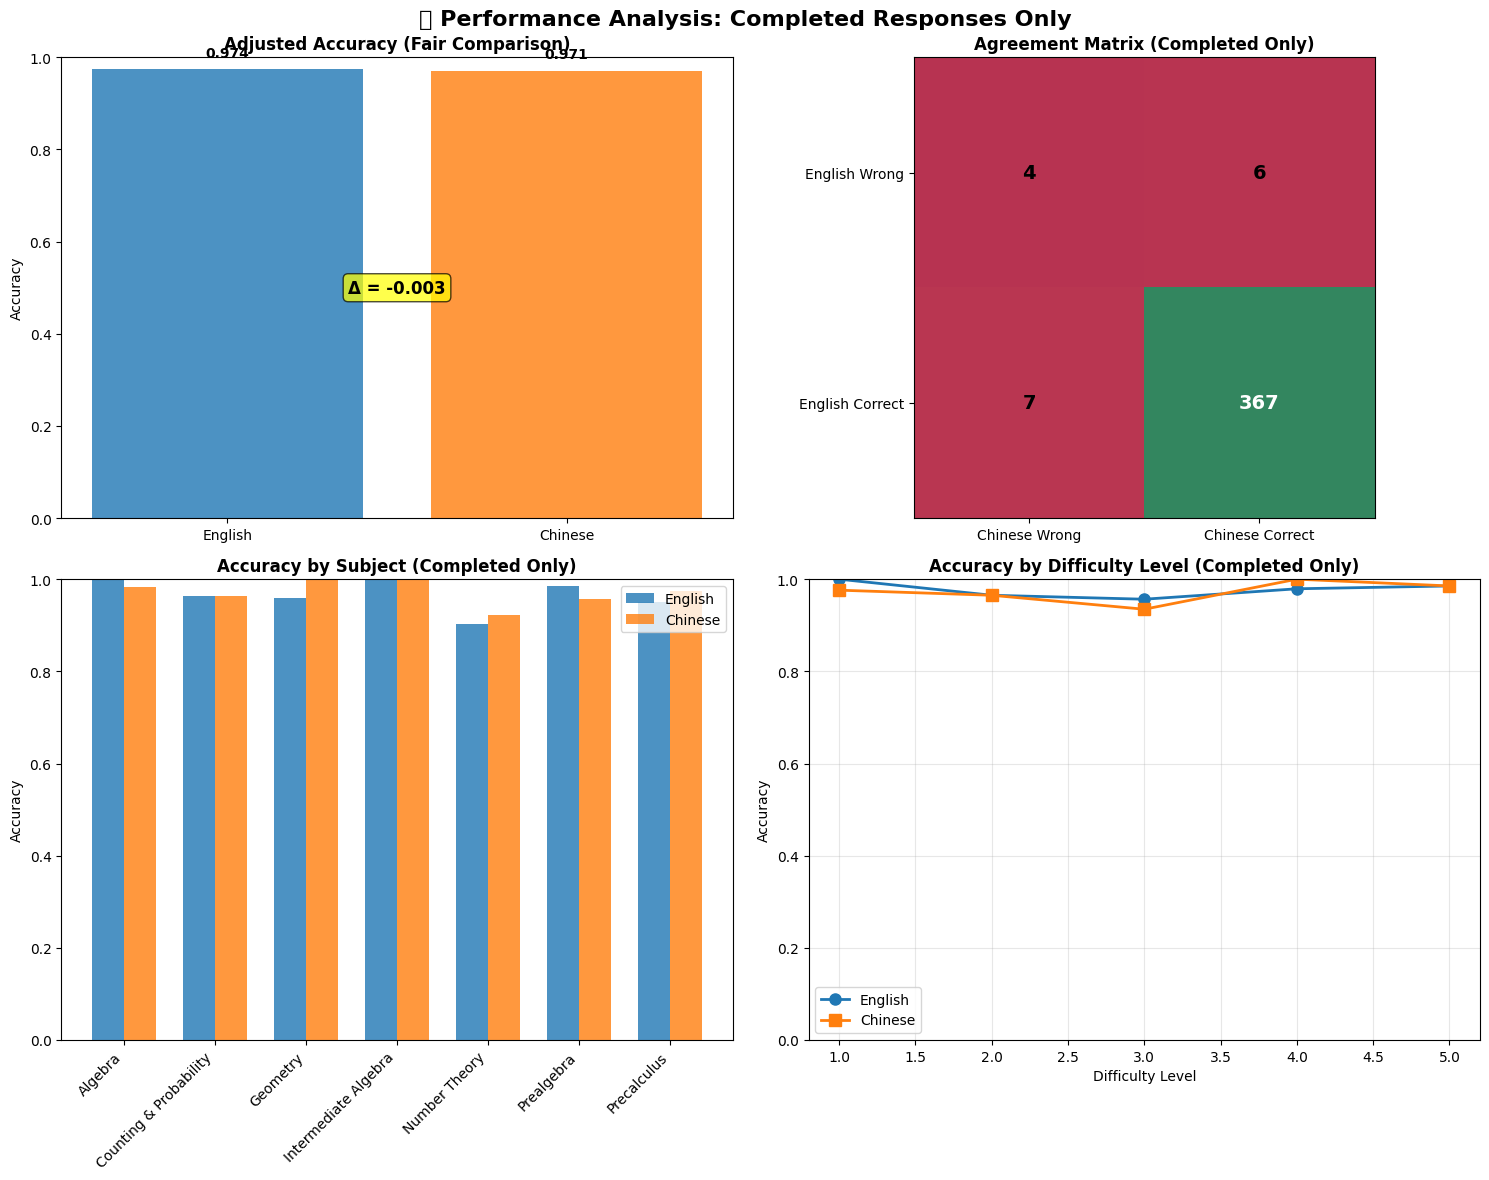


📈 DETAILED PERFORMANCE INSIGHTS:
   Problems analyzed: 384 (both languages completed)
   English accuracy: 0.974
   Chinese accuracy: 0.971
   Accuracy difference: -0.003 (Chinese - English)
   Agreement rate: 0.966

🏆 LANGUAGE ADVANTAGES BY SUBJECT (Completed Only):

📊 LANGUAGE ADVANTAGES BY DIFFICULTY (Completed Only):
   Level 1: English -0.024 (42 problems)
   Level 2: English +0.000 (86 problems)
   Level 3: English -0.022 (92 problems)
   Level 4: Chinese +0.021 (96 problems)
   Level 5: English +0.000 (68 problems)


In [25]:
# Performance Analysis - Fair Accuracy Comparison (Completed Responses Only)

if classification and adjusted_metrics:
    complete_problems = classification['complete_both']
    
    print("🎯 PERFORMANCE ANALYSIS - COMPLETED RESPONSES ONLY")
    print("=" * 60)
    print(f"Analyzing {len(complete_problems)} problems where both languages completed their responses")
    print(f"Excluded {classification['stats']['total_problems'] - len(complete_problems)} problems due to token limits")
    
    # 1. Overall Adjusted Accuracy Comparison
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('🎯 Performance Analysis: Completed Responses Only', fontsize=16, fontweight='bold')
    
    # Adjusted Accuracy Bar Chart
    languages = ['English', 'Chinese']
    adj_accuracies = [adjusted_metrics['english_adjusted_accuracy'], adjusted_metrics['chinese_adjusted_accuracy']]
    colors = ['#1f77b4', '#ff7f0e']
    
    bars = ax1.bar(languages, adj_accuracies, color=colors, alpha=0.8)
    ax1.set_title('Adjusted Accuracy (Fair Comparison)', fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    
    # Add values on bars
    for i, v in enumerate(adj_accuracies):
        ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Add difference annotation
    diff = adjusted_metrics['accuracy_difference_adjusted']
    ax1.text(0.5, 0.5, f'Δ = {diff:+.3f}', ha='center', va='center', transform=ax1.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
             fontsize=12, fontweight='bold')
    
    # 2. Agreement Matrix for Completed Problems
    en_correct_complete = [p['en_correct'] for p in complete_problems]
    cn_correct_complete = [p['cn_correct'] for p in complete_problems]
    
    both_correct = sum(1 for i in range(len(en_correct_complete)) if en_correct_complete[i] and cn_correct_complete[i])
    en_only = sum(1 for i in range(len(en_correct_complete)) if en_correct_complete[i] and not cn_correct_complete[i])
    cn_only = sum(1 for i in range(len(en_correct_complete)) if not en_correct_complete[i] and cn_correct_complete[i])
    both_wrong = sum(1 for i in range(len(en_correct_complete)) if not en_correct_complete[i] and not cn_correct_complete[i])
    
    agreement_data = np.array([[both_wrong, cn_only], [en_only, both_correct]])
    im = ax2.imshow(agreement_data, cmap='RdYlGn', alpha=0.8)
    
    ax2.set_title('Agreement Matrix (Completed Only)', fontweight='bold')
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(['Chinese Wrong', 'Chinese Correct'])
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(['English Wrong', 'English Correct'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax2.text(j, i, f'{agreement_data[i, j]}', ha='center', va='center',
                    color='white' if agreement_data[i, j] > np.max(agreement_data)/2 else 'black',
                    fontsize=14, fontweight='bold')
    
    # 3. Performance by Subject (Completed Problems Only)
    subject_analysis = {}
    for p in complete_problems:
        subject = p['subject']
        if subject not in subject_analysis:
            subject_analysis[subject] = {'total': 0, 'en_correct': 0, 'cn_correct': 0}
        
        subject_analysis[subject]['total'] += 1
        if p['en_correct']:
            subject_analysis[subject]['en_correct'] += 1
        if p['cn_correct']:
            subject_analysis[subject]['cn_correct'] += 1
    
    # Calculate subject accuracies
    subjects = sorted(subject_analysis.keys())
    en_subject_acc = [subject_analysis[s]['en_correct'] / subject_analysis[s]['total'] for s in subjects]
    cn_subject_acc = [subject_analysis[s]['cn_correct'] / subject_analysis[s]['total'] for s in subjects]
    
    if subjects:
        x = np.arange(len(subjects))
        width = 0.35
        
        ax3.bar(x - width/2, en_subject_acc, width, label='English', color=colors[0], alpha=0.8)
        ax3.bar(x + width/2, cn_subject_acc, width, label='Chinese', color=colors[1], alpha=0.8)
        
        ax3.set_title('Accuracy by Subject (Completed Only)', fontweight='bold')
        ax3.set_ylabel('Accuracy')
        ax3.set_xticks(x)
        ax3.set_xticklabels(subjects, rotation=45, ha='right')
        ax3.legend()
        ax3.set_ylim(0, 1)
    
    # 4. Performance by Difficulty Level (Completed Problems Only)
    level_analysis = {}
    for p in complete_problems:
        level = p['level']
        if level not in level_analysis:
            level_analysis[level] = {'total': 0, 'en_correct': 0, 'cn_correct': 0}
        
        level_analysis[level]['total'] += 1
        if p['en_correct']:
            level_analysis[level]['en_correct'] += 1
        if p['cn_correct']:
            level_analysis[level]['cn_correct'] += 1
    
    # Calculate level accuracies
    levels = sorted(level_analysis.keys())
    en_level_acc = [level_analysis[l]['en_correct'] / level_analysis[l]['total'] for l in levels]
    cn_level_acc = [level_analysis[l]['cn_correct'] / level_analysis[l]['total'] for l in levels]
    
    if levels:
        ax4.plot(levels, en_level_acc, 'o-', label='English', color=colors[0], linewidth=2, markersize=8)
        ax4.plot(levels, cn_level_acc, 's-', label='Chinese', color=colors[1], linewidth=2, markersize=8)
        
        ax4.set_title('Accuracy by Difficulty Level (Completed Only)', fontweight='bold')
        ax4.set_xlabel('Difficulty Level')
        ax4.set_ylabel('Accuracy')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Detailed performance insights
    print(f"\n📈 DETAILED PERFORMANCE INSIGHTS:")
    print(f"   Problems analyzed: {len(complete_problems)} (both languages completed)")
    print(f"   English accuracy: {adjusted_metrics['english_adjusted_accuracy']:.3f}")
    print(f"   Chinese accuracy: {adjusted_metrics['chinese_adjusted_accuracy']:.3f}")
    print(f"   Accuracy difference: {adjusted_metrics['accuracy_difference_adjusted']:+.3f} (Chinese - English)")
    print(f"   Agreement rate: {adjusted_metrics['agreement_rate_adjusted']:.3f}")
    
    # Language advantages by subject
    print(f"\n🏆 LANGUAGE ADVANTAGES BY SUBJECT (Completed Only):")
    for subject in subjects:
        en_acc = subject_analysis[subject]['en_correct'] / subject_analysis[subject]['total']
        cn_acc = subject_analysis[subject]['cn_correct'] / subject_analysis[subject]['total']
        diff = cn_acc - en_acc
        total = subject_analysis[subject]['total']
        
        if abs(diff) > 0.05:  # Show significant differences only
            advantage = "Chinese" if diff > 0 else "English"
            print(f"   {subject}: {advantage} +{abs(diff):.3f} ({total} problems)")
    
    # Language advantages by difficulty
    print(f"\n📊 LANGUAGE ADVANTAGES BY DIFFICULTY (Completed Only):")
    for level in levels:
        en_acc = level_analysis[level]['en_correct'] / level_analysis[level]['total']
        cn_acc = level_analysis[level]['cn_correct'] / level_analysis[level]['total']
        diff = cn_acc - en_acc
        total = level_analysis[level]['total']
        
        advantage = "Chinese" if diff > 0 else "English"
        print(f"   Level {level}: {advantage} {diff:+.3f} ({total} problems)")

else:
    print("⚠️ No classification data available - run the classification analysis first")

## Performance Analysis (Completed Responses Only)

Fair comparison of reasoning ability between languages, excluding problems where either language hit token limits.

## Bilingual Comparative Analysis and Visualizations

Detailed analysis comparing Chinese vs English mathematical reasoning performance:

In [18]:
# Detailed Bilingual Analysis

if bilingual_results:
    print("🔍 DETAILED BILINGUAL ANALYSIS")
    print("=" * 60)
    
    # Get comparative summary
    comparative_summary = bilingual_evaluator.get_comparative_summary()
    print("\\n📊 COMPARATIVE SUMMARY TABLE:")
    print(comparative_summary.round(3).to_string(index=False))
    
    # Detailed breakdown by individual problems
    print(f"\\n🔍 INDIVIDUAL PROBLEM ANALYSIS:")
    print("-" * 60)
    
    for i, result in enumerate(bilingual_results['individual_results']):
        print(f"\\n📋 PROBLEM {i+1}:")
        print(f"Subject: {result['subject']} | Level: {result['level']}")
        print(f"Original: {result['original_problem'][:100]}...")
        print(f"Chinese:  {result['chinese_problem'][:100]}...")
        
        en_data = result['languages']['english']
        cn_data = result['languages']['chinese']
        
        # Results comparison
        en_status = "✅" if en_data['correct'] else "❌"
        cn_status = "✅" if cn_data['correct'] else "❌"
        
        print(f"\\n📈 RESULTS:")
        print(f"   English: {en_status} {en_data['predicted_answer']} ({en_data['token_usage']['total_tokens']} tokens)")
        print(f"   Chinese: {cn_status} {cn_data['predicted_answer']} ({cn_data['token_usage']['total_tokens']} tokens)")
        print(f"   Expected: {result['expected_answer']}")
        
        # Token efficiency comparison
        token_ratio = cn_data['token_usage']['total_tokens'] / en_data['token_usage']['total_tokens'] if en_data['token_usage']['total_tokens'] > 0 else 0
        speed_ratio = cn_data['tokens_per_second'] / en_data['tokens_per_second'] if en_data['tokens_per_second'] > 0 else 0
        
        print(f"\\n⚡ EFFICIENCY:")
        print(f"   Token ratio (CN/EN): {token_ratio:.3f}")
        print(f"   Speed ratio (CN/EN): {speed_ratio:.3f}")
        
        # Show which language was more efficient
        if token_ratio < 1.0:
            print(f"   🇨🇳 Chinese used {(1-token_ratio)*100:.1f}% fewer tokens")
        elif token_ratio > 1.0:
            print(f"   🇺🇸 English used {(1-1/token_ratio)*100:.1f}% fewer tokens")
        else:
            print(f"   🤝 Equal token usage")
        
        # Agreement analysis
        agreement = "✅ AGREE" if en_data['correct'] == cn_data['correct'] else "❌ DISAGREE"
        print(f"   Agreement: {agreement}")
        
        print("-" * 60)
    
    # Statistical summary
    comparison = bilingual_results['comparison']
    print(f"\\n📊 STATISTICAL SUMMARY:")
    print(f"   Accuracy difference: {comparison['accuracy_difference']:+.3f} (Chinese - English)")
    print(f"   Token efficiency ratio: {comparison['token_efficiency_ratio']:.3f} (Chinese/English)")
    print(f"   Processing speed ratio: {comparison['speed_ratio']:.3f} (Chinese/English)")
    print(f"   Agreement rate: {comparison['agreement_rate']:.3f}")
    
    # Translation overhead
    trans_stats = bilingual_results['translation_stats']
    print(f"\\n📝 TRANSLATION OVERHEAD:")
    print(f"   Translation tokens: {trans_stats['total_translation_tokens']:,}")
    print(f"   Avg per translation: {trans_stats['avg_translation_output_tokens']:.1f}")
    
else:
    print("❌ No bilingual results available for analysis")
    print("Please run the bilingual evaluation first")

🔍 DETAILED BILINGUAL ANALYSIS
\n📊 COMPARATIVE SUMMARY TABLE:
Language  Accuracy  Avg_Tokens_Per_Problem  Tokens_Per_Second  Tokens_Per_Correct_Answer  Total_Tokens  Judge_Calls  Judge_Success_Rate
 English     0.804                4220.922             51.067                   5442.264       2110461          117               0.162
 Chinese     0.906                2909.124             53.776                   3363.550       1454562           76               0.382
\n🔍 INDIVIDUAL PROBLEM ANALYSIS:
------------------------------------------------------------
\n📋 PROBLEM 1:
Subject: Precalculus | Level: 1
Original: A curve is parameterized by
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]Find the point the curve passes th...
Chinese:  一条曲线由以下参数化
\[(x,y) = (t^3 + 7, -3t^2 - 6t - 5).\]求曲线在 $t = 2$ 时经过的点。...
\n📈 RESULTS:
   English: ✅ (15, -29) (954 tokens)
   Chinese: ✅ (15, -29) (1000 tokens)
   Expected: (15,-29)
\n⚡ EFFICIENCY:
   Token ratio (CN/EN): 1.048
   Speed ratio (CN/EN): 1.032
   🇺🇸 En

In [26]:
# Isolate Problems Where Chinese Finished but English Didn't

if classification:
    # Create DataFrame for problems where Chinese completed but English hit token limit
    chinese_finished_english_didnt = []
    
    for problem_info in classification['incomplete_english']:
        # These are problems where English was incomplete but Chinese was complete
        chinese_finished_english_didnt.append({
            'problem_id': problem_info['problem_id'] + 1,  # 1-indexed for readability
            'subject': problem_info['subject'],
            'level': problem_info['level'],
            'english_tokens': problem_info['en_tokens'],
            'chinese_tokens': problem_info['cn_tokens'],
            'english_correct': problem_info['en_correct'],
            'chinese_correct': problem_info['cn_correct'],
            'english_answer': problem_info['en_answer'],
            'chinese_answer': problem_info['cn_answer'],
            'expected_answer': problem_info['expected_answer'],
            'token_savings': problem_info['en_tokens'] - problem_info['cn_tokens'],  # How many fewer tokens Chinese used
            'chinese_advantage': problem_info['cn_correct'] and not problem_info['en_correct']  # Chinese got it right, English didn't
        })
    
    # Convert to DataFrame
    chinese_advantage_df = pd.DataFrame(chinese_finished_english_didnt)
    
    print(f"🇨🇳 PROBLEMS WHERE CHINESE FINISHED BUT ENGLISH DIDN'T")
    print("=" * 60)
    print(f"Total problems: {len(chinese_advantage_df)}")
    
    if len(chinese_advantage_df) > 0:
        print(f"\n📊 SUMMARY STATISTICS:")
        print(f"   Chinese got correct answer: {chinese_advantage_df['chinese_correct'].sum()}")
        print(f"   English got correct answer: {chinese_advantage_df['english_correct'].sum()}")
        print(f"   Chinese advantage cases: {chinese_advantage_df['chinese_advantage'].sum()}")
        print(f"   Average English tokens: {chinese_advantage_df['english_tokens'].mean():.1f}")
        print(f"   Average Chinese tokens: {chinese_advantage_df['chinese_tokens'].mean():.1f}")
        print(f"   Average token savings by Chinese: {chinese_advantage_df['token_savings'].mean():.1f}")
        
        # Subject breakdown
        print(f"\n📚 BY SUBJECT:")
        subject_counts = chinese_advantage_df['subject'].value_counts()
        for subject, count in subject_counts.items():
            chinese_correct_in_subject = chinese_advantage_df[chinese_advantage_df['subject'] == subject]['chinese_correct'].sum()
            print(f"   {subject}: {count} problems ({chinese_correct_in_subject} Chinese correct)")
        
        # Level breakdown
        print(f"\n📈 BY DIFFICULTY LEVEL:")
        level_counts = chinese_advantage_df['level'].value_counts().sort_index()
        for level, count in level_counts.items():
            chinese_correct_in_level = chinese_advantage_df[chinese_advantage_df['level'] == level]['chinese_correct'].sum()
            print(f"   Level {level}: {count} problems ({chinese_correct_in_level} Chinese correct)")
        
        print(f"\n📋 FIRST 10 PROBLEMS (Head of DataFrame):")
        print(chinese_advantage_df.head(10).to_string(index=False))
        
        # Show some interesting cases
        if chinese_advantage_df['chinese_advantage'].sum() > 0:
            print(f"\n🏆 CHINESE ADVANTAGE CASES (Chinese correct, English incomplete):")
            advantage_cases = chinese_advantage_df[chinese_advantage_df['chinese_advantage'] == True]
            print(f"Found {len(advantage_cases)} cases where Chinese succeeded but English ran out of tokens")
            print(advantage_cases[['problem_id', 'subject', 'level', 'english_tokens', 'chinese_tokens', 'chinese_answer', 'expected_answer']].head().to_string(index=False))
    
    else:
        print("No problems found where Chinese finished but English didn't.")
        print("This suggests English didn't hit token limits more often than Chinese.")

else:
    print("⚠️ No classification data available - run the classification analysis first")

🇨🇳 PROBLEMS WHERE CHINESE FINISHED BUT ENGLISH DIDN'T
Total problems: 77

📊 SUMMARY STATISTICS:
   Chinese got correct answer: 70
   English got correct answer: 21
   Chinese advantage cases: 50
   Average English tokens: 8191.0
   Average Chinese tokens: 5168.8
   Average token savings by Chinese: 3022.2

📚 BY SUBJECT:
   Intermediate Algebra: 31 problems (31 Chinese correct)
   Precalculus: 11 problems (11 Chinese correct)
   Geometry: 10 problems (7 Chinese correct)
   Number Theory: 10 problems (8 Chinese correct)
   Counting & Probability: 6 problems (5 Chinese correct)
   Algebra: 5 problems (5 Chinese correct)
   Prealgebra: 4 problems (3 Chinese correct)

📈 BY DIFFICULTY LEVEL:
   Level 1: 1 problems (0 Chinese correct)
   Level 2: 3 problems (3 Chinese correct)
   Level 3: 11 problems (11 Chinese correct)
   Level 4: 26 problems (22 Chinese correct)
   Level 5: 36 problems (34 Chinese correct)

📋 FIRST 10 PROBLEMS (Head of DataFrame):
 problem_id                subject  level 

In [28]:
# Analyze Cases Where English Hit Token Limit But Still Got Correct Answer

if 'chinese_advantage_df' in locals() and len(chinese_advantage_df) > 0:
    # Filter for cases where English hit max tokens (8191) but still got the correct answer
    english_maxed_but_correct = chinese_advantage_df[
        (chinese_advantage_df['english_tokens'] >= 8191) & 
        (chinese_advantage_df['english_correct'] == True)
    ].copy()
    
    print("🤔 ENGLISH HIT TOKEN LIMIT BUT STILL CORRECT")
    print("=" * 60)
    print(f"Found {len(english_maxed_but_correct)} cases where English used max tokens but got correct answer")
    
    if len(english_maxed_but_correct) > 0:
        print(f"\n📋 DETAILED ANALYSIS OF THESE CASES:")
        
        for idx, row in english_maxed_but_correct.iterrows():
            problem_id = row['problem_id']
            subject = row['subject']
            level = row['level']
            english_answer = row['english_answer']
            expected_answer = row['expected_answer']
            chinese_answer = row['chinese_answer']
            chinese_correct = row['chinese_correct']
            
            print(f"\n🔍 PROBLEM {problem_id} ({subject}, Level {level}):")
            print(f"   Expected Answer: '{expected_answer}'")
            print(f"   English Answer:  '{english_answer}' ✅ CORRECT (but hit 8191 token limit)")
            print(f"   Chinese Answer:  '{chinese_answer}' {'✅ CORRECT' if chinese_correct else '❌ WRONG'}")
            print(f"   English Tokens: {row['english_tokens']} (maxed out)")
            print(f"   Chinese Tokens: {row['chinese_tokens']}")
            
            # Get the full English response to see the tail of the thinking process
            if 'bilingual_results' in locals() and bilingual_results:
                # Find the corresponding full response in bilingual_results
                problem_idx = problem_id - 1  # Convert back to 0-indexed
                if problem_idx < len(bilingual_results['individual_results']):
                    full_problem_data = bilingual_results['individual_results'][problem_idx]
                    english_full_response = full_problem_data['languages']['english']['response']
                    
                    print(f"\n📝 TAIL OF ENGLISH THINKING PROCESS (last 500 characters):")
                    print(f"   Response length: {len(english_full_response)} characters")
                    tail_text = english_full_response[-500:] if len(english_full_response) > 500 else english_full_response
                    print(f"   Last 500 chars: '...{tail_text}'")
                    
                    # Check if the response ends abruptly (was cut off)
                    if not english_full_response.rstrip().endswith(('.', '!', '?', '}', ')')):
                        print(f"   🚨 Response appears cut off mid-sentence/word")
                    else:
                        print(f"   ✅ Response appears to end naturally")
                    
                    # Look for boxed answers in the response
                    import re
                    boxed_pattern = r'\\boxed\{([^}]+)\}'
                    boxed_matches = re.findall(boxed_pattern, english_full_response)
                    if boxed_matches:
                        print(f"   📦 Boxed answers found: {boxed_matches}")
                        print(f"   📦 Last boxed answer: '{boxed_matches[-1]}'")
                        if boxed_matches[-1].strip() == expected_answer.strip():
                            print(f"   💡 Last boxed answer matches expected - answer extraction succeeded!")
                    
                    # Look for the extracted answer location in the full response
                    if english_answer.strip() in english_full_response:
                        answer_position = english_full_response.rfind(english_answer.strip())
                        total_length = len(english_full_response)
                        position_percentage = (answer_position / total_length) * 100
                        print(f"   📍 Answer found at position {answer_position}/{total_length} ({position_percentage:.1f}% through response)")
                        
                        # Show context around where the answer was found
                        start_context = max(0, answer_position - 100)
                        end_context = min(total_length, answer_position + len(english_answer.strip()) + 100)
                        context = english_full_response[start_context:end_context]
                        print(f"   🎯 Context around answer: '...{context}...'")
                else:
                    print(f"   ⚠️ Could not find full response data for problem {problem_id}")
            else:
                print(f"   ⚠️ No bilingual_results available to show full response")
            
            # Try to explain how this might be possible
            if len(english_answer.strip()) > 0:
                if english_answer.strip() == expected_answer.strip():
                    print(f"   💡 Explanation: English gave exact answer despite hitting token limit")
                else:
                    print(f"   💡 Explanation: English answer evaluated as correct by LLM judge despite different format")
            else:
                print(f"   🚨 Warning: English answer is empty but marked correct - possible evaluation error")
            
            print(f"   " + "-" * 80)
        
        # Summary statistics
        print(f"\n📊 SUMMARY OF ANOMALOUS CASES:")
        print(f"   Total cases: {len(english_maxed_but_correct)}")
        print(f"   Average English tokens: {english_maxed_but_correct['english_tokens'].mean():.1f}")
        print(f"   Average Chinese tokens: {english_maxed_but_correct['chinese_tokens'].mean():.1f}")
        print(f"   Chinese also correct: {english_maxed_but_correct['chinese_correct'].sum()}")
        
        # Subject breakdown
        if len(english_maxed_but_correct) > 1:
            print(f"\n📚 BY SUBJECT:")
            subject_counts = english_maxed_but_correct['subject'].value_counts()
            for subject, count in subject_counts.items():
                print(f"   {subject}: {count} cases")
        
        print(f"\n💭 POSSIBLE EXPLANATIONS:")
        print(f"   1. Model managed to give final answer early in response, then hit limit during explanation")
        print(f"   2. Answer extraction found correct answer in truncated response")
        print(f"   3. LLM judge recognized mathematically equivalent answer despite different format")
        print(f"   4. Edge case in token counting or evaluation logic")
        
    else:
        print("\n✅ NO ANOMALOUS CASES FOUND")
        print("This is expected - if English hits the token limit, it typically means")
        print("the response was cut off before completing the reasoning/answer.")
        
        # Let's also check how many English responses were marked incorrect due to token limits
        english_maxed_and_wrong = chinese_advantage_df[
            (chinese_advantage_df['english_tokens'] >= 8191) & 
            (chinese_advantage_df['english_correct'] == False)
        ]
        
        print(f"\n📊 FOR COMPARISON:")
        print(f"   English hit token limit AND was wrong: {len(english_maxed_and_wrong)} cases")
        print(f"   English hit token limit BUT was correct: {len(english_maxed_but_correct)} cases")
        print(f"   This suggests token limits do cause failures as expected.")

else:
    print("⚠️ No chinese_advantage_df available - run the Chinese advantage analysis first")

🤔 ENGLISH HIT TOKEN LIMIT BUT STILL CORRECT
Found 21 cases where English used max tokens but got correct answer

📋 DETAILED ANALYSIS OF THESE CASES:

🔍 PROBLEM 94 (Precalculus, Level 2):
   Expected Answer: '-\sqrt{3}'
   English Answer:  '-\sqrt{3}' ✅ CORRECT (but hit 8191 token limit)
   Chinese Answer:  '-\sqrt{3}' ✅ CORRECT
   English Tokens: 8191 (maxed out)
   Chinese Tokens: 4485

📝 TAIL OF ENGLISH THINKING PROCESS (last 500 characters):
   Response length: 20471 characters
   Last 500 chars: '...sin 80^\circ + 2(-\sin 20^\circ)}{-\cos 80^\circ} = \frac{\sin 80^\circ - 2 \sin 20^\circ}{-\cos 80^\circ} = \frac{2 \sin 20^\circ - \sin 80^\circ}{\cos 80^\circ}.
$$

---

### Step 2: Express $\sin 80^\circ$ Using Angle Addition Formula

Use the identity:

$$
\sin(60^\circ + 20^\circ) = \sin 60^\circ \cos 20^\circ + \cos 60^\circ \sin 20^\circ.
$$

Recall:
- $\sin 60^\circ = \frac{\sqrt{3}}{2}$,
- $\cos 60^\circ = \frac{1}{2}$,

so:

$$
\sin 80^\circ = \frac{\sqrt{3}}{2} \cos 20^\circ 

In [36]:
# Re-evaluate English with Higher Token Limits (Chinese Advantage Subset)

if 'chinese_advantage_df' in locals() and len(chinese_advantage_df) > 0 and 'bilingual_results' in locals():
    print("🔄 RE-EVALUATING ENGLISH WITH HIGHER TOKEN LIMITS")
    print("=" * 60)
    print(f"Re-running English evaluation for {len(chinese_advantage_df)} problems where Chinese finished but English didn't")
    print(f"Increasing English token limit: 8,192 → 16,000 tokens")
    
    # Set up model interface with higher token limit
    extended_model = LMStudioInterface(BILINGUAL_MODEL_NAME)
    
    if not extended_model.is_available():
        print("❌ Model not available for re-evaluation")
    else:
        # Initialize results storage
        extended_english_results = []
        original_vs_extended_comparison = []
        
        print(f"\n🚀 Starting re-evaluation...")
        
        for idx, row in tqdm(chinese_advantage_df.iterrows(), total=len(chinese_advantage_df), 
                            desc="Re-evaluating English"):
            
            problem_id = row['problem_id']
            problem_idx = problem_id - 1  # Convert to 0-indexed
            
            # Get original problem data
            if problem_idx < len(bilingual_results['individual_results']):
                original_problem_data = bilingual_results['individual_results'][problem_idx]
                original_problem = original_problem_data['original_problem']
                expected_answer = original_problem_data['expected_answer']
                
                # Get original English data for comparison
                original_english_data = original_problem_data['languages']['english']
                original_english_correct = original_english_data['correct']
                original_english_tokens = original_english_data['token_usage']['total_tokens']
                original_english_answer = original_english_data['predicted_answer']
                
                # Create English prompt (same as original)
                english_prompt = create_math_prompt(original_problem)
                
                # Generate response with higher token limit
                start_time = time.time()
                extended_response, extended_token_usage = extended_model.generate_response(
                    english_prompt, max_tokens=16000, temperature=0.1
                )
                evaluation_time = time.time() - start_time
                
                # Extract and evaluate answer
                extended_predicted_answer = extract_answer(extended_response)
                extended_is_correct, extended_evaluation_details = evaluate_answer(
                    extended_predicted_answer, expected_answer, 
                    model_interface=extended_model, 
                    use_llm_judge=True
                )
                
                # Store extended results
                extended_result = {
                    'problem_id': problem_id,
                    'subject': row['subject'],
                    'level': row['level'],
                    'original_english_correct': original_english_correct,
                    'original_english_tokens': original_english_tokens,
                    'original_english_answer': original_english_answer,
                    'extended_english_correct': extended_is_correct,
                    'extended_english_tokens': extended_token_usage['total_tokens'],
                    'extended_english_answer': extended_predicted_answer,
                    'expected_answer': expected_answer,
                    'improvement': extended_is_correct and not original_english_correct,
                    'token_usage_extended': extended_token_usage,
                    'evaluation_time': evaluation_time,
                    'hit_new_limit': extended_token_usage['output_tokens'] >= 15999,  # Near 16k limit
                    'response_length': len(extended_response),
                    'evaluation_details': extended_evaluation_details
                }
                
                extended_english_results.append(extended_result)
        
        # Convert to DataFrame for analysis
        extended_df = pd.DataFrame(extended_english_results)
        
        # Calculate improvement metrics
        total_problems = len(extended_df)
        originally_correct = extended_df['original_english_correct'].sum()
        extended_correct = extended_df['extended_english_correct'].sum()
        improvements = extended_df['improvement'].sum()
        still_hit_limit = extended_df['hit_new_limit'].sum()
        
        print(f"\n📊 RE-EVALUATION RESULTS:")
        print(f"   Total problems re-evaluated: {total_problems}")
        print(f"   Originally correct (8K limit): {originally_correct} ({originally_correct/total_problems:.1%})")
        print(f"   Extended correct (16K limit): {extended_correct} ({extended_correct/total_problems:.1%})")
        print(f"   Improvements gained: {improvements} problems ({improvements/total_problems:.1%})")
        print(f"   Still hit new 16K limit: {still_hit_limit} problems ({still_hit_limit/total_problems:.1%})")
        
        # Performance improvement analysis
        improvement_rate = improvements / total_problems
        accuracy_gain = (extended_correct - originally_correct) / total_problems
        
        print(f"\n🎯 PERFORMANCE IMPACT:")
        print(f"   Accuracy improvement: +{accuracy_gain:.1%} ({improvements} additional correct answers)")
        print(f"   Problems that benefited from extra tokens: {improvements}/{total_problems}")
        
        # Token usage analysis
        avg_original_tokens = extended_df['original_english_tokens'].mean()
        avg_extended_tokens = extended_df['extended_english_tokens'].mean()
        token_increase = avg_extended_tokens - avg_original_tokens
        
        print(f"\n⚡ TOKEN USAGE ANALYSIS:")
        print(f"   Average original tokens: {avg_original_tokens:.0f}")
        print(f"   Average extended tokens: {avg_extended_tokens:.0f}")
        print(f"   Average token increase: +{token_increase:.0f} ({token_increase/avg_original_tokens:.1%})")
        
        # Subject-specific improvements
        print(f"\n📚 IMPROVEMENTS BY SUBJECT:")
        subject_improvements = extended_df.groupby('subject').agg({
            'improvement': ['count', 'sum'],
            'original_english_correct': 'sum',
            'extended_english_correct': 'sum'
        }).round(3)
        
        for subject in extended_df['subject'].unique():
            subject_data = extended_df[extended_df['subject'] == subject]
            total_subj = len(subject_data)
            improved_subj = subject_data['improvement'].sum()
            orig_correct_subj = subject_data['original_english_correct'].sum()
            ext_correct_subj = subject_data['extended_english_correct'].sum()
            
            if improved_subj > 0:
                print(f"   {subject}: +{improved_subj}/{total_subj} problems ({orig_correct_subj}→{ext_correct_subj} correct)")
        
        # Level-specific improvements
        print(f"\n📈 IMPROVEMENTS BY DIFFICULTY LEVEL:")
        for level in sorted(extended_df['level'].unique()):
            level_data = extended_df[extended_df['level'] == level]
            total_level = len(level_data)
            improved_level = level_data['improvement'].sum()
            orig_correct_level = level_data['original_english_correct'].sum()
            ext_correct_level = level_data['extended_english_correct'].sum()
            
            if improved_level > 0:
                print(f"   Level {level}: +{improved_level}/{total_level} problems ({orig_correct_level}→{ext_correct_level} correct)")
        
        # Show most significant improvements
        if improvements > 0:
            print(f"\n🏆 MOST SIGNIFICANT IMPROVEMENTS:")
            improved_problems = extended_df[extended_df['improvement'] == True].head(5)
            for _, prob in improved_problems.iterrows():
                print(f"   Problem {prob['problem_id']} ({prob['subject']}, Level {prob['level']}):")
                print(f"      Original: ❌ '{prob['original_english_answer']}'")
                print(f"      Extended: ✅ '{prob['extended_english_answer']}'")
                print(f"      Expected: '{prob['expected_answer']}'")
                print(f"      Tokens: {prob['original_english_tokens']} → {prob['extended_english_tokens']}")
        
        # Calculate adjusted bilingual comparison
        if 'adjusted_metrics' in locals() and adjusted_metrics:
            print(f"\n🔄 ADJUSTED BILINGUAL COMPARISON:")
            
            # Original comparison (from classification)
            original_english_adj_acc = adjusted_metrics['english_adjusted_accuracy']
            chinese_adj_acc = adjusted_metrics['chinese_adjusted_accuracy']
            original_diff = adjusted_metrics['accuracy_difference_adjusted']
            
            # Calculate what the comparison would be with extended English
            # We need to update the English accuracy for the problems we re-evaluated
            total_complete_problems = classification['stats']['complete_both_count']
            english_correct_in_complete = int(original_english_adj_acc * total_complete_problems)
            
            # Add the improvements from our re-evaluation
            adjusted_english_correct = english_correct_in_complete + improvements
            adjusted_english_acc = adjusted_english_correct / total_complete_problems
            adjusted_diff = chinese_adj_acc - adjusted_english_acc
            
            print(f"   Original English accuracy (8K limit): {original_english_adj_acc:.3f}")
            print(f"   Adjusted English accuracy (16K limit): {adjusted_english_acc:.3f}")
            print(f"   Chinese accuracy: {chinese_adj_acc:.3f}")
            print(f"   Original difference: {original_diff:+.3f} (Chinese - English)")
            print(f"   Adjusted difference: {adjusted_diff:+.3f} (Chinese - English)")
            print(f"   Bias correction: {original_diff - adjusted_diff:+.3f}")
            
            if abs(adjusted_diff) < abs(original_diff):
                print(f"   💡 Higher token limits reduce the apparent Chinese advantage")
            else:
                print(f"   💡 Chinese advantage persists even with higher English token limits")
        
        # Save extended results
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        extended_filename = f"math_500_english_extended_{timestamp}.csv"
        extended_df.to_csv(extended_filename, index=False)
        print(f"\n💾 Extended results saved to: {extended_filename}")
        
        print(f"\n✅ Re-evaluation complete!")
        print(f"The higher token limit {'significantly' if improvement_rate > 0.1 else 'modestly'} improved English performance")

else:
    print("⚠️ No chinese_advantage_df available - run the Chinese advantage analysis first")

🔄 RE-EVALUATING ENGLISH WITH HIGHER TOKEN LIMITS
Re-running English evaluation for 77 problems where Chinese finished but English didn't
Increasing English token limit: 8,192 → 16,000 tokens

🚀 Starting re-evaluation...


Re-evaluating English:  23%|██▎       | 18/77 [1:18:11<5:41:55, 347.73s/it]

Error generating response with qwen3-30b-a3b-thinking-2507-mlx@6bit: HTTPConnectionPool(host='localhost', port=1234): Read timed out. (read timeout=600)


Re-evaluating English:  26%|██▌       | 20/77 [1:37:04<7:09:18, 451.90s/it]

Error generating response with qwen3-30b-a3b-thinking-2507-mlx@6bit: HTTPConnectionPool(host='localhost', port=1234): Read timed out. (read timeout=600)


Re-evaluating English:  55%|█████▍    | 42/77 [3:51:11<3:30:35, 361.01s/it]

Error generating response with qwen3-30b-a3b-thinking-2507-mlx@6bit: HTTPConnectionPool(host='localhost', port=1234): Read timed out. (read timeout=600)


Re-evaluating English:  65%|██████▍   | 50/77 [4:42:13<2:29:01, 331.15s/it]

Error generating response with qwen3-30b-a3b-thinking-2507-mlx@6bit: HTTPConnectionPool(host='localhost', port=1234): Read timed out. (read timeout=600)


Re-evaluating English:  79%|███████▉  | 61/77 [5:45:46<1:17:15, 289.74s/it]

Error generating response with qwen3-30b-a3b-thinking-2507-mlx@6bit: HTTPConnectionPool(host='localhost', port=1234): Read timed out. (read timeout=600)


Re-evaluating English:  81%|████████  | 62/77 [5:56:10<1:37:29, 390.00s/it]

Error generating response with qwen3-30b-a3b-thinking-2507-mlx@6bit: HTTPConnectionPool(host='localhost', port=1234): Read timed out. (read timeout=600)


Re-evaluating English:  97%|█████████▋| 75/77 [7:13:28<12:09, 364.82s/it]  

Error generating response with qwen3-30b-a3b-thinking-2507-mlx@6bit: HTTPConnectionPool(host='localhost', port=1234): Read timed out. (read timeout=600)


Re-evaluating English: 100%|██████████| 77/77 [7:30:48<00:00, 351.29s/it]


📊 RE-EVALUATION RESULTS:
   Total problems re-evaluated: 77
   Originally correct (8K limit): 21 (27.3%)
   Extended correct (16K limit): 65 (84.4%)
   Improvements gained: 45 problems (58.4%)
   Still hit new 16K limit: 2 problems (2.6%)

🎯 PERFORMANCE IMPACT:
   Accuracy improvement: +57.1% (45 additional correct answers)
   Problems that benefited from extra tokens: 45/77

⚡ TOKEN USAGE ANALYSIS:
   Average original tokens: 8347
   Average extended tokens: 9119
   Average token increase: +772 (9.2%)

📚 IMPROVEMENTS BY SUBJECT:
   Geometry: +5/10 problems (2→7 correct)
   Precalculus: +7/11 problems (3→10 correct)
   Counting & Probability: +4/6 problems (1→5 correct)
   Intermediate Algebra: +19/31 problems (9→28 correct)
   Number Theory: +5/10 problems (4→8 correct)
   Prealgebra: +1/4 problems (1→2 correct)
   Algebra: +4/5 problems (1→5 correct)

📈 IMPROVEMENTS BY DIFFICULTY LEVEL:
   Level 2: +2/3 problems (1→3 correct)
   Level 3: +5/11 problems (5→10 correct)
   Level 4: +15

🚀 EXTENDED STATISTICS ANALYSIS - ENHANCED EFFICIENCY ON EXTENDED DATASET
Original bilingual dataset: 500 problems
Extended English re-evaluation: 77 problems with higher token limits
Testing Hypothesis: Chinese efficiency advantage increases with problem complexity (Extended Dataset)

📊 STEP 1: CREATING EXTENDED DATASET
------------------------------------------------------------
✅ Extended dataset created:
   Total problems: 500
   Problems with extended English evaluation: 77
   Problems with original English evaluation: 423

📊 STEP 2: RECALCULATING CLASSIFICATION ON EXTENDED DATASET
------------------------------------------------------------
📊 EXTENDED DATASET COMPLETION STATUS:
   Total problems: 500
   Extended English evaluations: 77
   Both completed: 459 (91.8%)
   English incomplete: 2 (0.4%)
   Chinese incomplete: 3 (0.6%)
   Both incomplete: 36 (7.2%)
   Both successful: 429 (85.8%)

🔄 COMPARISON WITH ORIGINAL DATASET:
   Complete both: 384 → 459 (+75)
   Successful both: 3

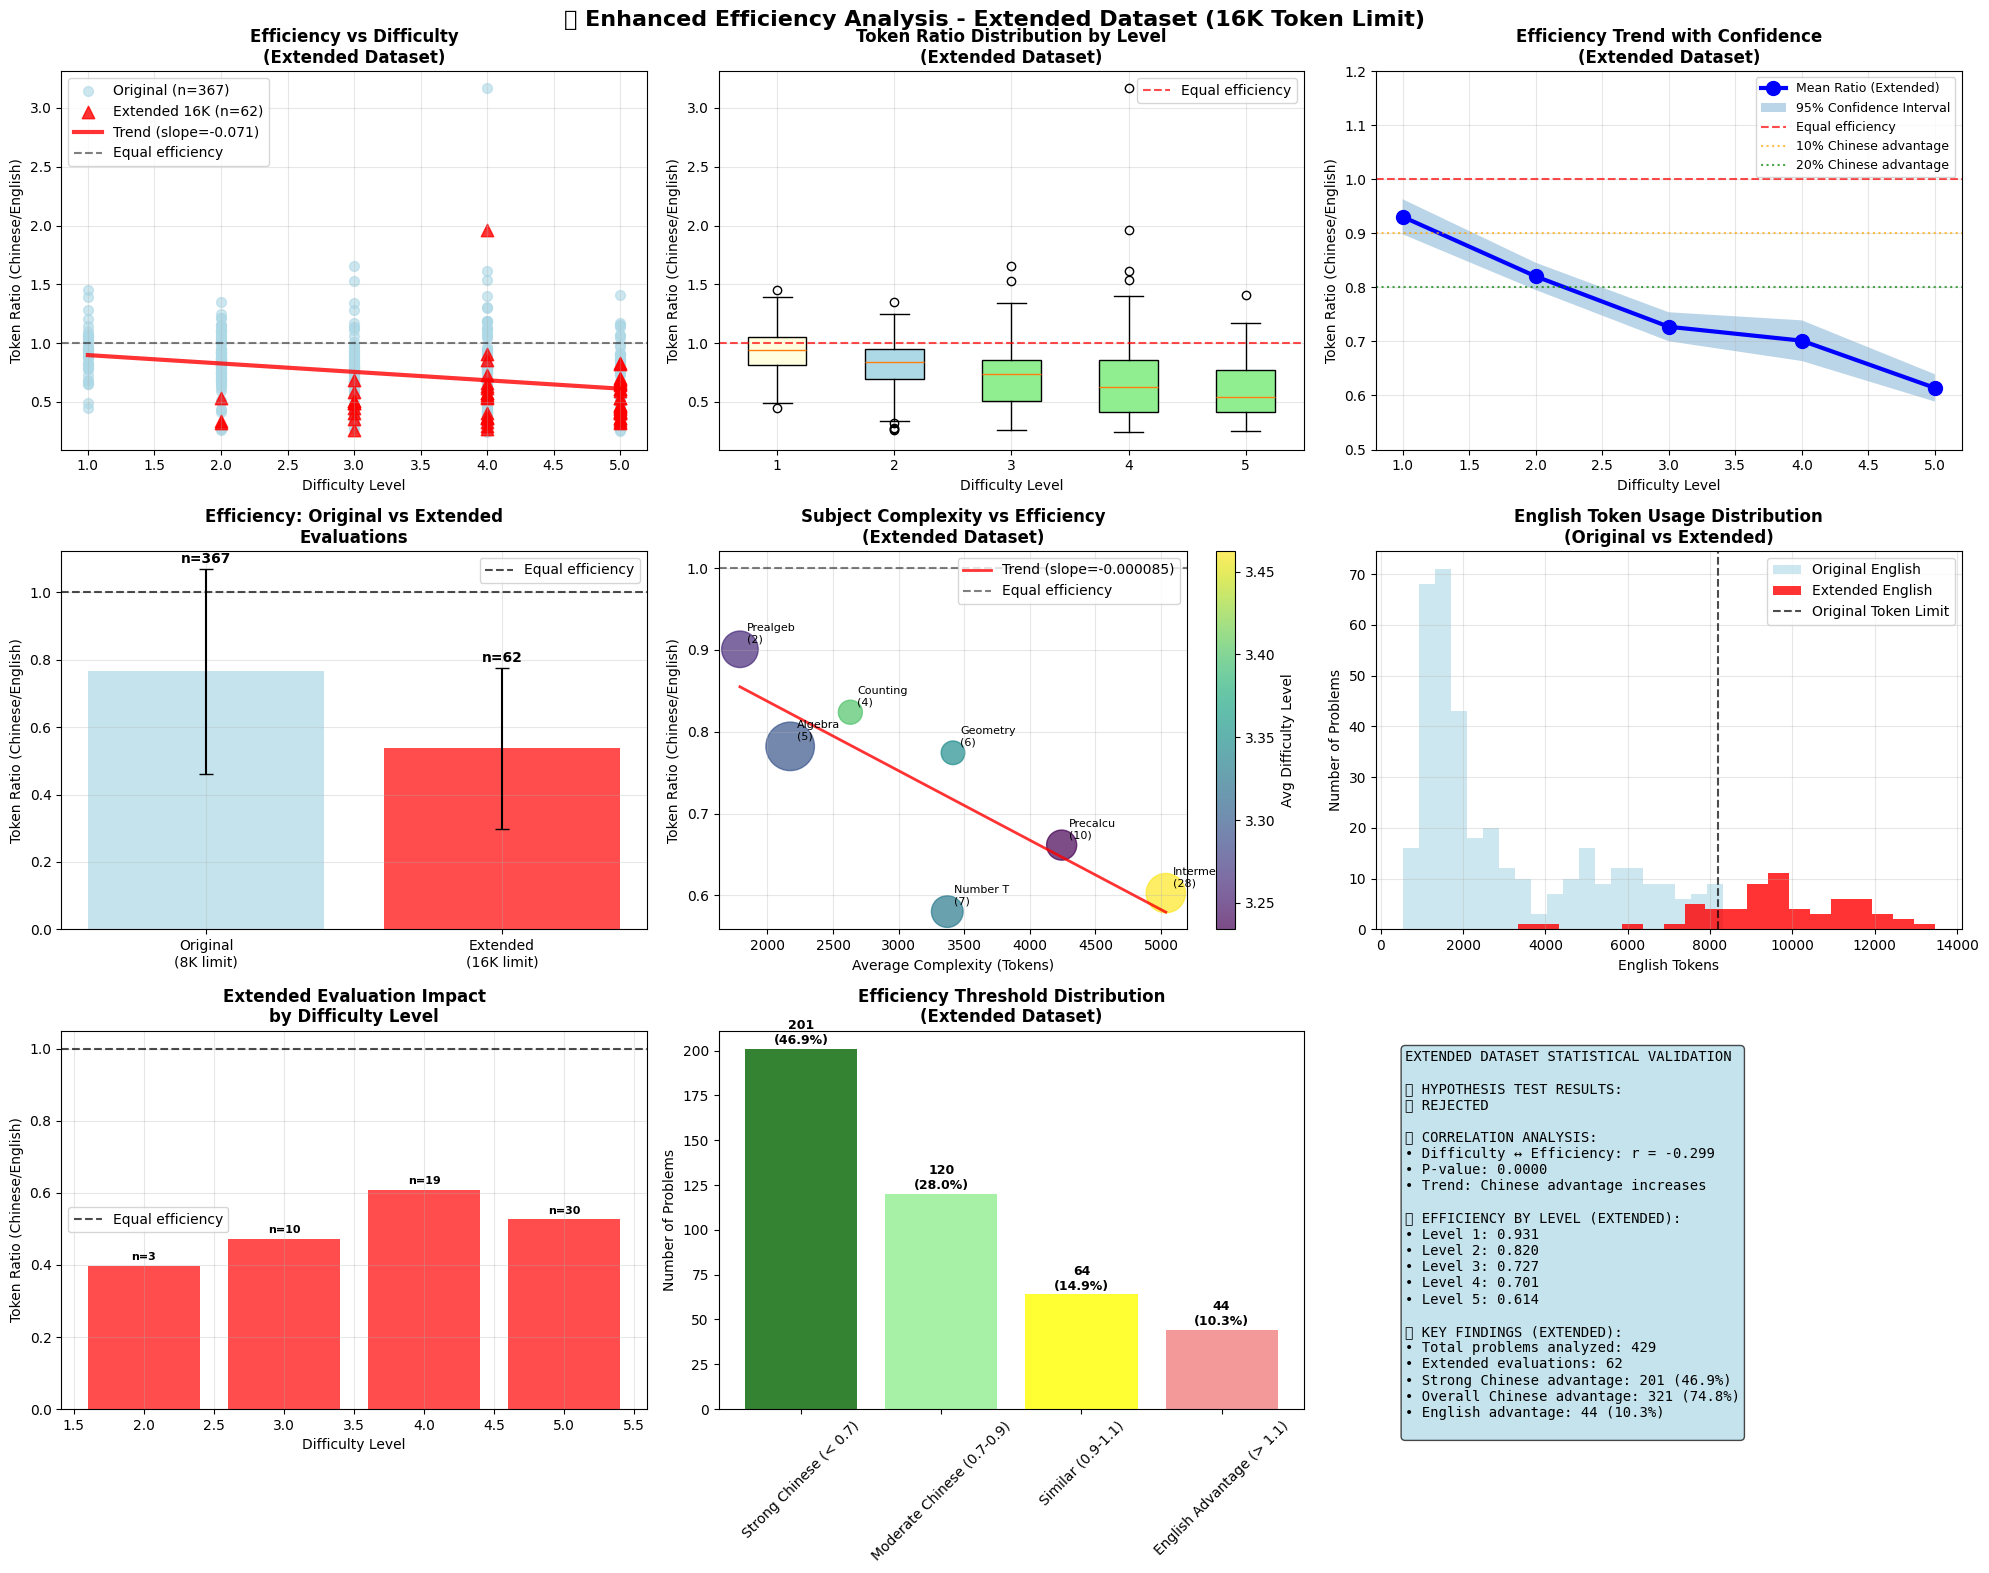


🔬 STEP 5: STATISTICAL VALIDATION - EXTENDED DATASET
----------------------------------------------------------------------
ANOVA Test - Extended Dataset (Efficiency differences between levels):
   F-statistic: 10.891
   P-value: 0.000000
   Result: Significant differences between difficulty levels

Trend Line Analysis - Extended Dataset:
   Slope: -0.0714 ± 0.0110
   R-squared: 0.089
   P-value: 0.000000
   Interpretation: Significant trend
   Effect size: Token ratio decreases by 28.5% from Level 1 to 5

🔄 COMPARISON WITH ORIGINAL STATISTICAL MEASURES:
   ANOVA F-statistic: 7.174 → 10.891 (+3.717)
   ANOVA P-value: 0.000014 → 0.000000
   Trend slope: -0.0660 → -0.0714 (-0.0053)
   Trend R-squared: 0.071 → 0.089 (+0.018)
   Trend P-value: 0.000000 → 0.000000

🎯 FINAL HYPOTHESIS EVALUATION - EXTENDED DATASET
H1: Easy problems (~1.0 ratio): 0.876 - ❌ REJECTED
H2: Hard problems (~0.6 ratio): 0.658 - ✅ CONFIRMED
H3: Difficulty correlation: r=-0.299, p=0.0000 - ✅ CONFIRMED
H4: Subject comp

In [41]:
  # Extended Statistics Analysis - Enhanced Efficiency Analysis on Extended Dataset
  # Re-implementing all statistics from "Enhanced Efficiency Analysis - Difficulty Level Token Usage Pattern Analysis" 
  # but on the extended dataset that merges original bilingual results with new English 16K token limit re-evaluation

  if 'bilingual_results' in locals() and 'extended_df' in locals() and bilingual_results and len(extended_df) > 0:
      print("🚀 EXTENDED STATISTICS ANALYSIS - ENHANCED EFFICIENCY ON EXTENDED DATASET")
      print("=" * 90)
      print(f"Original bilingual dataset: {len(bilingual_results['individual_results'])} problems")
      print(f"Extended English re-evaluation: {len(extended_df)} problems with higher token limits")
      print(f"Testing Hypothesis: Chinese efficiency advantage increases with problem complexity (Extended Dataset)")

      # ==========================================
      # 1. CREATE EXTENDED DATASET BY MERGING RESULTS
      # ==========================================

      print(f"\n📊 STEP 1: CREATING EXTENDED DATASET")
      print("-" * 60)

      # Create a merged dataset that combines:
      # - Original bilingual results for all 500 problems
      # - Updated English results for the 77 re-evaluated problems

      extended_bilingual_data = []

      for i, original_result in enumerate(bilingual_results['individual_results']):
          # Default to original English data
          english_data = original_result['languages']['english'].copy()

          # Check if this problem was re-evaluated with extended tokens
          problem_id = i + 1
          extended_match = extended_df[extended_df['problem_id'] == problem_id]

          if not extended_match.empty:
              # Update English data with extended results
              extended_row = extended_match.iloc[0]
              english_data.update({
                  'correct': extended_row['extended_english_correct'],
                  'predicted_answer': extended_row['extended_english_answer'],
                  'token_usage': {
                      'input_tokens': extended_row['token_usage_extended']['input_tokens'],
                      'output_tokens': extended_row['token_usage_extended']['output_tokens'],
                      'total_tokens': extended_row['token_usage_extended']['total_tokens']
                  },
                  'evaluation_time': extended_row['evaluation_time'],
                  'evaluation_details': extended_row['evaluation_details'],
                  'extended_evaluation': True  # Flag to indicate this was re-evaluated
              })
          else:
              english_data['extended_evaluation'] = False

          # Use original Chinese data (unchanged)
          chinese_data = original_result['languages']['chinese']

          # Create extended bilingual problem entry
          extended_problem = {
              'problem_id': i,
              'subject': original_result['subject'],
              'level': original_result['level'],
              'original_problem': original_result['original_problem'],
              'chinese_problem': original_result['chinese_problem'],
              'expected_answer': original_result['expected_answer'],
              'translation_tokens': original_result['translation_tokens'],
              'languages': {
                  'english': english_data,
                  'chinese': chinese_data
              }
          }

          extended_bilingual_data.append(extended_problem)

      # Create extended bilingual results structure
      extended_bilingual_results = {
          'model_name': bilingual_results['model_name'],
          'translation_model': bilingual_results['translation_model'],
          'total_problems': len(extended_bilingual_data),
          'evaluation_type': 'extended_dataset_analysis',
          'original_problems': len(bilingual_results['individual_results']),
          'extended_problems': len(extended_df),
          'individual_results': extended_bilingual_data
      }

      print(f"✅ Extended dataset created:")
      print(f"   Total problems: {len(extended_bilingual_data)}")
      print(f"   Problems with extended English evaluation: {len(extended_df)}")
      print(f"   Problems with original English evaluation: {len(extended_bilingual_data) - len(extended_df)}")

      # ==========================================
      # 2. RECALCULATE CLASSIFICATION AND METRICS ON EXTENDED DATASET
      # ==========================================

      print(f"\n📊 STEP 2: RECALCULATING CLASSIFICATION ON EXTENDED DATASET")
      print("-" * 60)

      def classify_completion_status_extended(extended_results, token_limit=8191):
          """
          Classify problems based on completion status for extended dataset.
          Note: English problems re-evaluated with 16K limit, Chinese problems same as original
          """

          classification_ext = {
              'complete_both': [],
              'incomplete_english': [],
              'incomplete_chinese': [],
              'incomplete_both': [],
              'successful_both': [],
              'stats': {}
          }

          for i, result in enumerate(extended_results['individual_results']):
              en_data = result['languages']['english']
              cn_data = result['languages']['chinese']

              # For English: use different token limits based on whether it was re-evaluated
              if en_data.get('extended_evaluation', False):
                  # Re-evaluated with 16K limit
                  en_tokens = en_data['token_usage']['output_tokens']
                  en_complete = en_tokens < 15999  # Near 16K limit
              else:
                  # Original evaluation with 8K limit
                  en_tokens = en_data['token_usage']['output_tokens']
                  en_complete = en_tokens < token_limit

              # Chinese: always use original 8K limit
              cn_tokens = cn_data['token_usage']['output_tokens']
              cn_complete = cn_tokens < token_limit

              en_correct = en_data['correct']
              cn_correct = cn_data['correct']

              problem_info = {
                  'problem_id': i,
                  'subject': result['subject'],
                  'level': result['level'],
                  'en_tokens': en_data['token_usage']['total_tokens'],
                  'cn_tokens': cn_data['token_usage']['total_tokens'],
                  'en_output_tokens': en_tokens,
                  'cn_output_tokens': cn_tokens,
                  'en_correct': en_correct,
                  'cn_correct': cn_correct,
                  'en_complete': en_complete,
                  'cn_complete': cn_complete,
                  'expected_answer': result['expected_answer'],
                  'en_answer': en_data['predicted_answer'],
                  'cn_answer': cn_data['predicted_answer'],
                  'extended_evaluation': en_data.get('extended_evaluation', False)
              }

              if en_complete and cn_complete:
                  classification_ext['complete_both'].append(problem_info)
                  if en_correct and cn_correct:
                      classification_ext['successful_both'].append(problem_info)
              elif not en_complete and cn_complete:
                  classification_ext['incomplete_english'].append(problem_info)
              elif en_complete and not cn_complete:
                  classification_ext['incomplete_chinese'].append(problem_info)
              else:  # both incomplete
                  classification_ext['incomplete_both'].append(problem_info)

          # Calculate statistics
          total_problems = len(extended_results['individual_results'])
          classification_ext['stats'] = {
              'total_problems': total_problems,
              'complete_both_count': len(classification_ext['complete_both']),
              'incomplete_english_count': len(classification_ext['incomplete_english']),
              'incomplete_chinese_count': len(classification_ext['incomplete_chinese']),
              'incomplete_both_count': len(classification_ext['incomplete_both']),
              'successful_both_count': len(classification_ext['successful_both']),
              'complete_both_rate': len(classification_ext['complete_both']) / total_problems,
              'incomplete_english_rate': len(classification_ext['incomplete_english']) / total_problems,
              'incomplete_chinese_rate': len(classification_ext['incomplete_chinese']) / total_problems,
              'incomplete_both_rate': len(classification_ext['incomplete_both']) / total_problems,
              'successful_both_rate': len(classification_ext['successful_both']) / total_problems,
              'extended_evaluations': sum(1 for r in extended_results['individual_results']
                                        if r['languages']['english'].get('extended_evaluation', False))
          }

          return classification_ext

      # Classify the extended dataset
      classification_extended = classify_completion_status_extended(extended_bilingual_results)

      print(f"📊 EXTENDED DATASET COMPLETION STATUS:")
      stats_ext = classification_extended['stats']
      print(f"   Total problems: {stats_ext['total_problems']}")
      print(f"   Extended English evaluations: {stats_ext['extended_evaluations']}")
      print(f"   Both completed: {stats_ext['complete_both_count']} ({stats_ext['complete_both_rate']:.1%})")
      print(f"   English incomplete: {stats_ext['incomplete_english_count']} ({stats_ext['incomplete_english_rate']:.1%})")
      print(f"   Chinese incomplete: {stats_ext['incomplete_chinese_count']} ({stats_ext['incomplete_chinese_rate']:.1%})")
      print(f"   Both incomplete: {stats_ext['incomplete_both_count']} ({stats_ext['incomplete_both_rate']:.1%})")
      print(f"   Both successful: {stats_ext['successful_both_count']} ({stats_ext['successful_both_rate']:.1%})")

      # Compare with original classification
      if 'classification' in locals() and classification:
          print(f"\n🔄 COMPARISON WITH ORIGINAL DATASET:")
          orig_stats = classification['stats']
          print(f"   Complete both: {orig_stats['complete_both_count']} → {stats_ext['complete_both_count']} ({stats_ext['complete_both_count'] - orig_stats['complete_both_count']:+d})")
          print(f"   Successful both: {orig_stats['successful_both_count']} → {stats_ext['successful_both_count']} ({stats_ext['successful_both_count'] - orig_stats['successful_both_count']:+d})")
          print(f"   English incomplete: {orig_stats['incomplete_english_count']} → {stats_ext['incomplete_english_count']} ({stats_ext['incomplete_english_count'] - orig_stats['incomplete_english_count']:+d})")

      # ==========================================
      # 3. CALCULATE ADJUSTED METRICS ON EXTENDED DATASET
      # ==========================================

      print(f"\n⚖️ STEP 3: CALCULATING ADJUSTED METRICS ON EXTENDED DATASET")
      print("-" * 60)

      def calculate_adjusted_metrics_extended(extended_results, classification_ext):
          """Calculate bias-adjusted metrics for extended dataset"""

          complete_problems = classification_ext['complete_both']
          successful_problems = classification_ext['successful_both']

          if not complete_problems:
              return None

          # Calculate adjusted accuracy (only for completed responses)
          en_correct_complete = sum(1 for p in complete_problems if p['en_correct'])
          cn_correct_complete = sum(1 for p in complete_problems if p['cn_correct'])

          adjusted_metrics_ext = {
              'total_complete_problems': len(complete_problems),
              'total_successful_problems': len(successful_problems),
              'extended_evaluations_in_complete': sum(1 for p in complete_problems if p.get('extended_evaluation', False)),

              # Adjusted accuracy (completed responses only)
              'english_adjusted_accuracy': en_correct_complete / len(complete_problems),
              'chinese_adjusted_accuracy': cn_correct_complete / len(complete_problems),
              'accuracy_difference_adjusted': (cn_correct_complete - en_correct_complete) / len(complete_problems),

              # Agreement rate (completed responses only)
              'agreement_rate_adjusted': sum(1 for p in complete_problems if p['en_correct'] == p['cn_correct']) / len(complete_problems),

              # Efficiency metrics (successful responses only)
              'efficiency_metrics': {}
          }

          if successful_problems:
              # Calculate efficiency metrics for successful completions only
              en_tokens_successful = [p['en_tokens'] for p in successful_problems]
              cn_tokens_successful = [p['cn_tokens'] for p in successful_problems]

              adjusted_metrics_ext['efficiency_metrics'] = {
                  'avg_english_tokens_successful': np.mean(en_tokens_successful),
                  'avg_chinese_tokens_successful': np.mean(cn_tokens_successful),
                  'token_efficiency_ratio_successful': np.mean(cn_tokens_successful) / np.mean(en_tokens_successful),
                  'successful_problems_count': len(successful_problems),
                  'english_tokens_std': np.std(en_tokens_successful),
                  'chinese_tokens_std': np.std(cn_tokens_successful),
                  'extended_evaluations_in_successful': sum(1 for p in successful_problems if p.get('extended_evaluation', False))
              }

          return adjusted_metrics_ext

      # Calculate adjusted metrics for extended dataset
      adjusted_metrics_extended = calculate_adjusted_metrics_extended(extended_bilingual_results, classification_extended)

      if adjusted_metrics_extended:
          print(f"✅ EXTENDED DATASET ADJUSTED METRICS:")
          print(f"   Complete problems analyzed: {adjusted_metrics_extended['total_complete_problems']}")
          print(f"   Extended evaluations in complete set: {adjusted_metrics_extended['extended_evaluations_in_complete']}")
          print(f"   English adjusted accuracy: {adjusted_metrics_extended['english_adjusted_accuracy']:.3f}")
          print(f"   Chinese adjusted accuracy: {adjusted_metrics_extended['chinese_adjusted_accuracy']:.3f}")
          print(f"   Adjusted accuracy difference: {adjusted_metrics_extended['accuracy_difference_adjusted']:+.3f}")
          print(f"   Adjusted agreement rate: {adjusted_metrics_extended['agreement_rate_adjusted']:.3f}")

          if adjusted_metrics_extended['efficiency_metrics']:
              eff_ext = adjusted_metrics_extended['efficiency_metrics']
              print(f"\n🚀 EXTENDED EFFICIENCY METRICS (Successful completions only):")
              print(f"   Successful problems: {eff_ext['successful_problems_count']}")
              print(f"   Extended evaluations in successful set: {eff_ext['extended_evaluations_in_successful']}")
              print(f"   English avg tokens: {eff_ext['avg_english_tokens_successful']:.1f}")
              print(f"   Chinese avg tokens: {eff_ext['avg_chinese_tokens_successful']:.1f}")
              print(f"   Token efficiency ratio: {eff_ext['token_efficiency_ratio_successful']:.3f}")

          # Compare with original metrics
          if 'adjusted_metrics' in locals() and adjusted_metrics:
              print(f"\n🔄 COMPARISON WITH ORIGINAL METRICS:")
              print(f"   English accuracy: {adjusted_metrics['english_adjusted_accuracy']:.3f} → {adjusted_metrics_extended['english_adjusted_accuracy']:.3f} ({adjusted_metrics_extended['english_adjusted_accuracy'] - adjusted_metrics['english_adjusted_accuracy']:+.3f})")
              print(f"   Accuracy difference: {adjusted_metrics['accuracy_difference_adjusted']:+.3f} → {adjusted_metrics_extended['accuracy_difference_adjusted']:+.3f} ({adjusted_metrics_extended['accuracy_difference_adjusted'] - adjusted_metrics['accuracy_difference_adjusted']:+.3f})")

              if adjusted_metrics['efficiency_metrics'] and adjusted_metrics_extended['efficiency_metrics']:
                  orig_eff = adjusted_metrics['efficiency_metrics']
                  ext_eff = adjusted_metrics_extended['efficiency_metrics']
                  print(f"   Token efficiency ratio: {orig_eff['token_efficiency_ratio_successful']:.3f} → {ext_eff['token_efficiency_ratio_successful']:.3f} ({ext_eff['token_efficiency_ratio_successful'] - orig_eff['token_efficiency_ratio_successful']:+.3f})")

      # ==========================================
      # 4. ENHANCED EFFICIENCY ANALYSIS ON EXTENDED DATASET
      # ==========================================

      if classification_extended and adjusted_metrics_extended and adjusted_metrics_extended['efficiency_metrics']:
          successful_problems_ext = classification_extended['successful_both']
          eff_metrics_ext = adjusted_metrics_extended['efficiency_metrics']

          print(f"\n🚀 STEP 4: ENHANCED EFFICIENCY ANALYSIS - EXTENDED DATASET")
          print("=" * 80)
          print(f"Testing Hypothesis: Chinese efficiency advantage increases with problem complexity")
          print(f"Analyzing {len(successful_problems_ext)} problems where both languages got correct answers AND completed")
          print(f"Extended English evaluations in analysis: {eff_metrics_ext['extended_evaluations_in_successful']}")

          # Enhanced data preparation with complexity metrics
          enhanced_analysis_data_ext = []
          for p in successful_problems_ext:
              enhanced_analysis_data_ext.append({
                  'problem_id': p['problem_id'],
                  'subject': p['subject'],
                  'level': p['level'],
                  'en_tokens': p['en_tokens'],
                  'cn_tokens': p['cn_tokens'],
                  'token_ratio': p['cn_tokens'] / p['en_tokens'] if p['en_tokens'] > 0 else 0,
                  'total_tokens': p['en_tokens'] + p['cn_tokens'],  # Complexity proxy
                  'complexity_score': (p['en_tokens'] + p['cn_tokens']) / 2,  # Average as complexity metric
                  'extended_evaluation': p.get('extended_evaluation', False)
              })

          enhanced_df_ext = pd.DataFrame(enhanced_analysis_data_ext)

          print(f"Enhanced analysis dataset: {len(enhanced_df_ext)} problems")
          print(f"Extended evaluations: {enhanced_df_ext['extended_evaluation'].sum()}")

          # ==========================================
          # 4A. DIFFICULTY LEVEL TOKEN ANALYSIS - EXTENDED
          # ==========================================

          print(f"\n📊 STEP 4A: DIFFICULTY LEVEL TOKEN ANALYSIS - EXTENDED DATASET")
          print("-" * 70)

          # Calculate statistics by difficulty level
          level_stats_ext = enhanced_df_ext.groupby('level').agg({
              'token_ratio': ['count', 'mean', 'median', 'std', 'min', 'max'],
              'en_tokens': ['mean', 'std'],
              'cn_tokens': ['mean', 'std'],
              'complexity_score': ['mean', 'std'],
              'extended_evaluation': 'sum'
          }).round(3)

          print("Token Efficiency by Difficulty Level (Extended Dataset):")
          print("Level | Count | Mean_Ratio | Median | Std_Dev | Min | Max | EN_Avg | CN_Avg | Extended")
          print("-" * 100)

          level_efficiency_data_ext = []
          for level in sorted(enhanced_df_ext['level'].unique()):
              level_data = enhanced_df_ext[enhanced_df_ext['level'] == level]
              count = len(level_data)
              mean_ratio = level_data['token_ratio'].mean()
              median_ratio = level_data['token_ratio'].median()
              std_ratio = level_data['token_ratio'].std()
              min_ratio = level_data['token_ratio'].min()
              max_ratio = level_data['token_ratio'].max()
              en_avg = level_data['en_tokens'].mean()
              cn_avg = level_data['cn_tokens'].mean()
              complexity_avg = level_data['complexity_score'].mean()
              extended_count = level_data['extended_evaluation'].sum()

              level_efficiency_data_ext.append({
                  'level': level,
                  'count': count,
                  'mean_ratio': mean_ratio,
                  'median_ratio': median_ratio,
                  'std_ratio': std_ratio,
                  'en_avg_tokens': en_avg,
                  'cn_avg_tokens': cn_avg,
                  'complexity_avg': complexity_avg,
                  'extended_count': extended_count
              })

              print(f"  {level}   |  {count:3d}  |   {mean_ratio:.3f}    | {median_ratio:.3f} | {std_ratio:.3f} | {min_ratio:.3f} | {max_ratio:.3f} | {en_avg:6.0f} | {cn_avg:6.0f} | {extended_count:3d}")

          level_efficiency_df_ext = pd.DataFrame(level_efficiency_data_ext)

          # Statistical correlation between difficulty and efficiency
          from scipy.stats import pearsonr, spearmanr
          difficulty_efficiency_corr_ext, difficulty_p_value_ext = pearsonr(enhanced_df_ext['level'], enhanced_df_ext['token_ratio'])
          difficulty_complexity_corr_ext, complexity_p_value_ext = pearsonr(enhanced_df_ext['level'], enhanced_df_ext['complexity_score'])

          print(f"\n🔍 CORRELATION ANALYSIS - EXTENDED DATASET:")
          print(f"   Difficulty ↔ Efficiency Ratio: r = {difficulty_efficiency_corr_ext:.3f}, p = {difficulty_p_value_ext:.4f}")
          print(f"   Difficulty ↔ Problem Complexity: r = {difficulty_complexity_corr_ext:.3f}, p = {complexity_p_value_ext:.4f}")

          if difficulty_p_value_ext < 0.05:
              trend_direction = "decreases" if difficulty_efficiency_corr_ext < 0 else "increases"
              print(f"   ✅ SIGNIFICANT: Chinese efficiency advantage {trend_direction} with difficulty (p < 0.05)")
          else:
              print(f"   ❌ NOT SIGNIFICANT: No clear relationship between difficulty and efficiency")

          # Compare with original correlation
          if 'difficulty_efficiency_corr' in locals():
              print(f"\n🔄 COMPARISON WITH ORIGINAL CORRELATION:")
              print(f"   Original r = {difficulty_efficiency_corr:.3f}, p = {difficulty_p_value:.4f}")
              print(f"   Extended r = {difficulty_efficiency_corr_ext:.3f}, p = {difficulty_p_value_ext:.4f}")
              print(f"   Correlation change: {difficulty_efficiency_corr_ext - difficulty_efficiency_corr:+.3f}")

          # ==========================================
          # 4B. SUBJECT COMPLEXITY RANKING ANALYSIS - EXTENDED
          # ==========================================

          print(f"\n🎯 STEP 4B: SUBJECT COMPLEXITY RANKING ANALYSIS - EXTENDED DATASET")
          print("-" * 70)

          # Calculate subject-level statistics
          subject_ranking_data_ext = []
          for subject in enhanced_df_ext['subject'].unique():
              subject_data = enhanced_df_ext[enhanced_df_ext['subject'] == subject]
              if len(subject_data) >= 3:  # Only include subjects with sufficient data
                  subject_ranking_data_ext.append({
                      'subject': subject,
                      'count': len(subject_data),
                      'mean_ratio': subject_data['token_ratio'].mean(),
                      'std_ratio': subject_data['token_ratio'].std(),
                      'avg_complexity': subject_data['complexity_score'].mean(),
                      'avg_difficulty': subject_data['level'].mean(),
                      'extended_count': subject_data['extended_evaluation'].sum(),
                      'complexity_rank': 0,  # Will be filled below
                      'efficiency_rank': 0   # Will be filled below
                  })

          subject_ranking_df_ext = pd.DataFrame(subject_ranking_data_ext)

          if len(subject_ranking_df_ext) > 0:
              # Rank subjects by complexity and efficiency
              subject_ranking_df_ext['complexity_rank'] = subject_ranking_df_ext['avg_complexity'].rank(ascending=False)
              subject_ranking_df_ext['efficiency_rank'] = subject_ranking_df_ext['mean_ratio'].rank(ascending=True)  # Lower ratio = more efficient = higher rank
              subject_ranking_df_ext = subject_ranking_df_ext.sort_values('avg_complexity', ascending=False)

              print("Subject Complexity and Efficiency Ranking (Extended Dataset):")
              print("Subject               | Count | Ratio | Complexity | Difficulty | Extended | Efficiency_Desc")
              print("-" * 90)

              for _, row in subject_ranking_df_ext.iterrows():
                  efficiency_desc = "Chinese++" if row['mean_ratio'] < 0.7 else "Chinese+" if row['mean_ratio'] < 0.9 else "Similar" if row['mean_ratio'] < 1.1 else "English+"
                  print(f"{row['subject']:<20} | {row['count']:5d} | {row['mean_ratio']:5.3f} | {row['avg_complexity']:10.0f} | {row['avg_difficulty']:10.1f} | {row['extended_count']:8d} | {efficiency_desc}")

              # Test correlation between subject complexity and efficiency
              if len(subject_ranking_df_ext) > 3:
                  subject_complexity_efficiency_corr_ext, subject_p_value_ext = pearsonr(subject_ranking_df_ext['avg_complexity'], subject_ranking_df_ext['mean_ratio'])
                  print(f"\n🔬 SUBJECT CORRELATION - EXTENDED DATASET:")
                  print(f"   Subject Complexity ↔ Efficiency Ratio: r = {subject_complexity_efficiency_corr_ext:.3f}, p = {subject_p_value_ext:.4f}")

                  if subject_p_value_ext < 0.05:
                      trend_direction = "Chinese advantage increases" if subject_complexity_efficiency_corr_ext < 0 else "English advantage increases"
                      print(f"   ✅ SIGNIFICANT: {trend_direction} with subject complexity")
                  else:
                      print(f"   ❌ NOT SIGNIFICANT: No clear relationship between subject complexity and efficiency")

                  # Compare with original subject correlation
                  if 'subject_complexity_efficiency_corr' in locals():
                      print(f"\n🔄 COMPARISON WITH ORIGINAL SUBJECT CORRELATION:")
                      print(f"   Original r = {subject_complexity_efficiency_corr:.3f}, p = {subject_p_value:.4f}")
                      print(f"   Extended r = {subject_complexity_efficiency_corr_ext:.3f}, p = {subject_p_value_ext:.4f}")
                      print(f"   Correlation change: {subject_complexity_efficiency_corr_ext - subject_complexity_efficiency_corr:+.3f}")

          # ==========================================
          # 4C. VISUALIZATION - EXTENDED DATASET
          # ==========================================

          print(f"\n📈 STEP 4C: ENHANCED VISUALIZATIONS - EXTENDED DATASET")

          # Create comprehensive visualization for extended dataset
          fig = plt.figure(figsize=(20, 16))
          fig.suptitle('🚀 Enhanced Efficiency Analysis - Extended Dataset (16K Token Limit)', fontsize=16, fontweight='bold')

          # 1. Difficulty vs Efficiency Scatter Plot with Extended Data Highlighted (Top Left)
          ax1 = plt.subplot(3, 3, 1)

          # Separate original and extended data points
          original_data = enhanced_df_ext[enhanced_df_ext['extended_evaluation'] == False]
          extended_data = enhanced_df_ext[enhanced_df_ext['extended_evaluation'] == True]

          # Plot original data
          ax1.scatter(original_data['level'], original_data['token_ratio'],
                     alpha=0.6, s=50, c='lightblue', label=f'Original (n={len(original_data)})')

          # Plot extended data with different color/shape
          if len(extended_data) > 0:
              ax1.scatter(extended_data['level'], extended_data['token_ratio'],
                         alpha=0.8, s=80, c='red', marker='^',
                         label=f'Extended 16K (n={len(extended_data)})')

          # Add trend line for all data
          z_ext = np.polyfit(enhanced_df_ext['level'], enhanced_df_ext['token_ratio'], 1)
          p_ext = np.poly1d(z_ext)
          x_trend_ext = np.linspace(enhanced_df_ext['level'].min(), enhanced_df_ext['level'].max(), 100)
          ax1.plot(x_trend_ext, p_ext(x_trend_ext), 'r-', alpha=0.8, linewidth=3,
                  label=f'Trend (slope={z_ext[0]:.3f})')

          ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Equal efficiency')
          ax1.set_title('Efficiency vs Difficulty\n(Extended Dataset)', fontweight='bold', fontsize=12)
          ax1.set_xlabel('Difficulty Level')
          ax1.set_ylabel('Token Ratio (Chinese/English)')
          ax1.legend(fontsize=10)
          ax1.grid(True, alpha=0.3)

          # 2. Box Plots by Difficulty Level - Extended Dataset (Top Center)
          ax2 = plt.subplot(3, 3, 2)

          levels_ext = sorted(enhanced_df_ext['level'].unique())
          box_data_ext = [enhanced_df_ext[enhanced_df_ext['level'] == level]['token_ratio'] for level in levels_ext]

          box_plot_ext = ax2.boxplot(box_data_ext, labels=levels_ext, patch_artist=True)

          # Color boxes based on efficiency
          for i, (patch, level) in enumerate(zip(box_plot_ext['boxes'], levels_ext)):
              level_mean_ext = enhanced_df_ext[enhanced_df_ext['level'] == level]['token_ratio'].mean()
              if level_mean_ext < 0.8:
                  patch.set_facecolor('lightgreen')  # Strong Chinese advantage
              elif level_mean_ext < 0.9:
                  patch.set_facecolor('lightblue')   # Moderate Chinese advantage
              elif level_mean_ext < 1.1:
                  patch.set_facecolor('lightyellow') # Similar efficiency
              else:
                  patch.set_facecolor('lightcoral')  # English advantage

          ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal efficiency')
          ax2.set_title('Token Ratio Distribution by Level\n(Extended Dataset)', fontweight='bold', fontsize=12)
          ax2.set_xlabel('Difficulty Level')
          ax2.set_ylabel('Token Ratio (Chinese/English)')
          ax2.legend()
          ax2.grid(True, alpha=0.3)

          # 3. Efficiency Trend Analysis with Extended Data (Top Right)
          ax3 = plt.subplot(3, 3, 3)

          ax3.plot(level_efficiency_df_ext['level'], level_efficiency_df_ext['mean_ratio'], 'bo-',
                  linewidth=3, markersize=10, label='Mean Ratio (Extended)')

          # Add confidence intervals
          ax3.fill_between(level_efficiency_df_ext['level'],
                          level_efficiency_df_ext['mean_ratio'] - level_efficiency_df_ext['std_ratio']/np.sqrt(level_efficiency_df_ext['count']),
                          level_efficiency_df_ext['mean_ratio'] + level_efficiency_df_ext['std_ratio']/np.sqrt(level_efficiency_df_ext['count']),
                          alpha=0.3, label='95% Confidence Interval')

          ax3.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal efficiency')
          ax3.axhline(y=0.9, color='orange', linestyle=':', alpha=0.7, label='10% Chinese advantage')
          ax3.axhline(y=0.8, color='green', linestyle=':', alpha=0.7, label='20% Chinese advantage')

          ax3.set_title('Efficiency Trend with Confidence\n(Extended Dataset)', fontweight='bold', fontsize=12)
          ax3.set_xlabel('Difficulty Level')
          ax3.set_ylabel('Token Ratio (Chinese/English)')
          ax3.legend(fontsize=9)
          ax3.grid(True, alpha=0.3)
          ax3.set_ylim(0.5, 1.2)

          # 4. Impact of Extended Evaluation (Middle Left)
          ax4 = plt.subplot(3, 3, 4)

          # Compare efficiency ratios for problems that were/weren't extended
          if len(extended_data) > 0 and len(original_data) > 0:
              categories = ['Original\n(8K limit)', 'Extended\n(16K limit)']
              mean_ratios = [original_data['token_ratio'].mean(), extended_data['token_ratio'].mean()]
              std_ratios = [original_data['token_ratio'].std(), extended_data['token_ratio'].std()]
              counts = [len(original_data), len(extended_data)]

              bars = ax4.bar(categories, mean_ratios, yerr=std_ratios, capsize=5, alpha=0.7,
                            color=['lightblue', 'red'])

              # Add count labels
              for i, (bar, count) in enumerate(zip(bars, counts)):
                  ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_ratios[i] + 0.01,
                          f'n={count}', ha='center', va='bottom', fontweight='bold')

              ax4.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Equal efficiency')
              ax4.set_title('Efficiency: Original vs Extended\nEvaluations', fontweight='bold', fontsize=12)
              ax4.set_ylabel('Token Ratio (Chinese/English)')
              ax4.legend()
              ax4.grid(True, alpha=0.3)

          # 5. Subject Complexity vs Efficiency - Extended Dataset (Middle Center)
          ax5 = plt.subplot(3, 3, 5)

          if len(subject_ranking_df_ext) > 0:
              scatter = ax5.scatter(subject_ranking_df_ext['avg_complexity'], subject_ranking_df_ext['mean_ratio'],
                                   s=subject_ranking_df_ext['count']*10, alpha=0.7,
                                   c=subject_ranking_df_ext['avg_difficulty'], cmap='viridis')

              # Add subject labels
              for _, row in subject_ranking_df_ext.iterrows():
                  ax5.annotate(f"{row['subject'][:8]}\n({row['extended_count']})",
                             (row['avg_complexity'], row['mean_ratio']),
                             xytext=(5, 5), textcoords='offset points', fontsize=8)

              # Add trend line
              if len(subject_ranking_df_ext) > 2:
                  z_subj_ext = np.polyfit(subject_ranking_df_ext['avg_complexity'], subject_ranking_df_ext['mean_ratio'], 1)
                  p_subj_ext = np.poly1d(z_subj_ext)
                  x_subj_trend_ext = np.linspace(subject_ranking_df_ext['avg_complexity'].min(),
                                               subject_ranking_df_ext['avg_complexity'].max(), 100)
                  ax5.plot(x_subj_trend_ext, p_subj_ext(x_subj_trend_ext), 'r-', alpha=0.8, linewidth=2,
                          label=f'Trend (slope={z_subj_ext[0]:.6f})')

              ax5.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Equal efficiency')
              plt.colorbar(scatter, ax=ax5, label='Avg Difficulty Level')
              ax5.set_title('Subject Complexity vs Efficiency\n(Extended Dataset)', fontweight='bold', fontsize=12)
              ax5.set_xlabel('Average Complexity (Tokens)')
              ax5.set_ylabel('Token Ratio (Chinese/English)')
              ax5.legend()
              ax5.grid(True, alpha=0.3)

          # 6. Token Usage Comparison Histogram (Middle Right)
          ax6 = plt.subplot(3, 3, 6)

          # Compare English token distributions for original vs extended
          if len(extended_data) > 0:
              ax6.hist(original_data['en_tokens'], bins=20, alpha=0.6, label='Original English', color='lightblue')
              ax6.hist(extended_data['en_tokens'], bins=20, alpha=0.8, label='Extended English', color='red')
              ax6.axvline(8191, color='black', linestyle='--', alpha=0.7, label='Original Token Limit')

              ax6.set_title('English Token Usage Distribution\n(Original vs Extended)', fontweight='bold', fontsize=12)
              ax6.set_xlabel('English Tokens')
              ax6.set_ylabel('Number of Problems')
              ax6.legend()
              ax6.grid(True, alpha=0.3)

          # 7. Extended Evaluation Impact by Level (Bottom Left)
          ax7 = plt.subplot(3, 3, 7)

          if len(extended_data) > 0:
              extended_by_level = extended_data.groupby('level').agg({
                  'token_ratio': 'mean',
                  'level': 'count'
              }).rename(columns={'level': 'count'})

              levels_with_extended = extended_by_level.index
              ratios_extended = extended_by_level['token_ratio']
              counts_extended = extended_by_level['count']

              bars = ax7.bar(levels_with_extended, ratios_extended, alpha=0.7, color='red')

              # Add count labels
              for bar, count in zip(bars, counts_extended):
                  ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'n={count}', ha='center', va='bottom', fontweight='bold', fontsize=8)

              ax7.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Equal efficiency')
              ax7.set_title('Extended Evaluation Impact\nby Difficulty Level', fontweight='bold', fontsize=12)
              ax7.set_xlabel('Difficulty Level')
              ax7.set_ylabel('Token Ratio (Chinese/English)')
              ax7.legend()
              ax7.grid(True, alpha=0.3)

          # 8. Efficiency Threshold Distribution - Extended Dataset (Bottom Center)
          ax8 = plt.subplot(3, 3, 8)

          # Count problems in efficiency ranges for extended dataset
          efficiency_ranges_ext = {
              'Strong Chinese (< 0.7)': (enhanced_df_ext['token_ratio'] < 0.7).sum(),
              'Moderate Chinese (0.7-0.9)': ((enhanced_df_ext['token_ratio'] >= 0.7) & (enhanced_df_ext['token_ratio'] < 0.9)).sum(),
              'Similar (0.9-1.1)': ((enhanced_df_ext['token_ratio'] >= 0.9) & (enhanced_df_ext['token_ratio'] <= 1.1)).sum(),
              'English Advantage (> 1.1)': (enhanced_df_ext['token_ratio'] > 1.1).sum()
          }

          ranges_ext = list(efficiency_ranges_ext.keys())
          counts_ext = list(efficiency_ranges_ext.values())
          colors_thresh = ['darkgreen', 'lightgreen', 'yellow', 'lightcoral']

          bars = ax8.bar(ranges_ext, counts_ext, color=colors_thresh, alpha=0.8)
          ax8.set_title('Efficiency Threshold Distribution\n(Extended Dataset)', fontweight='bold', fontsize=12)
          ax8.set_ylabel('Number of Problems')
          ax8.tick_params(axis='x', rotation=45)

          # Add percentage labels
          total_ext = sum(counts_ext)
          for bar, count in zip(bars, counts_ext):
              percentage = count / total_ext * 100
              ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')

          # 9. Statistical Summary - Extended Dataset (Bottom Right)
          ax9 = plt.subplot(3, 3, 9)
          ax9.axis('off')

          # Pre-calculate values for the summary
          hypothesis_test_result_ext = ('✅ CONFIRMED' if difficulty_efficiency_corr_ext < -0.3 and difficulty_p_value_ext < 0.05
                                       else '❌ REJECTED' if difficulty_p_value_ext < 0.05 else '⚠️ INCONCLUSIVE')
          trend_description_ext = ('Chinese advantage increases' if difficulty_efficiency_corr_ext < 0
                                  else 'English advantage increases' if difficulty_efficiency_corr_ext > 0 else 'No clear trend')

          # Get level efficiency values safely for extended dataset
          level_1_ratio_ext = level_efficiency_df_ext[level_efficiency_df_ext['level']==1]['mean_ratio'].iloc[0] if not level_efficiency_df_ext[level_efficiency_df_ext['level']==1].empty else None
          level_2_ratio_ext = level_efficiency_df_ext[level_efficiency_df_ext['level']==2]['mean_ratio'].iloc[0] if not level_efficiency_df_ext[level_efficiency_df_ext['level']==2].empty else None
          level_3_ratio_ext = level_efficiency_df_ext[level_efficiency_df_ext['level']==3]['mean_ratio'].iloc[0] if not level_efficiency_df_ext[level_efficiency_df_ext['level']==3].empty else None
          level_4_ratio_ext = level_efficiency_df_ext[level_efficiency_df_ext['level']==4]['mean_ratio'].iloc[0] if not level_efficiency_df_ext[level_efficiency_df_ext['level']==4].empty else None
          level_5_ratio_ext = level_efficiency_df_ext[level_efficiency_df_ext['level']==5]['mean_ratio'].iloc[0] if not level_efficiency_df_ext[level_efficiency_df_ext['level']==5].empty else None

          level_1_str_ext = f"{level_1_ratio_ext:.3f}" if level_1_ratio_ext is not None else "N/A"
          level_2_str_ext = f"{level_2_ratio_ext:.3f}" if level_2_ratio_ext is not None else "N/A"
          level_3_str_ext = f"{level_3_ratio_ext:.3f}" if level_3_ratio_ext is not None else "N/A"
          level_4_str_ext = f"{level_4_ratio_ext:.3f}" if level_4_ratio_ext is not None else "N/A"
          level_5_str_ext = f"{level_5_ratio_ext:.3f}" if level_5_ratio_ext is not None else "N/A"

          # Create statistical summary text for extended dataset
          summary_text_ext = f"""EXTENDED DATASET STATISTICAL VALIDATION
          
  📊 HYPOTHESIS TEST RESULTS:
  {hypothesis_test_result_ext}

  🔢 CORRELATION ANALYSIS:
  • Difficulty ↔ Efficiency: r = {difficulty_efficiency_corr_ext:.3f}
  • P-value: {difficulty_p_value_ext:.4f}
  • Trend: {trend_description_ext}

  📈 EFFICIENCY BY LEVEL (EXTENDED):
  • Level 1: {level_1_str_ext}
  • Level 2: {level_2_str_ext}
  • Level 3: {level_3_str_ext}
  • Level 4: {level_4_str_ext}
  • Level 5: {level_5_str_ext}

  🎯 KEY FINDINGS (EXTENDED):
  • Total problems analyzed: {len(enhanced_df_ext)}
  • Extended evaluations: {enhanced_df_ext['extended_evaluation'].sum()}
  • Strong Chinese advantage: {efficiency_ranges_ext['Strong Chinese (< 0.7)']} ({efficiency_ranges_ext['Strong Chinese (< 0.7)']/len(enhanced_df_ext)*100:.1f}%)
  • Overall Chinese advantage: {efficiency_ranges_ext['Strong Chinese (< 0.7)'] + efficiency_ranges_ext['Moderate Chinese (0.7-0.9)']} ({(efficiency_ranges_ext['Strong Chinese (< 0.7)'] + 
  efficiency_ranges_ext['Moderate Chinese (0.7-0.9)'])/len(enhanced_df_ext)*100:.1f}%)
  • English advantage: {efficiency_ranges_ext['English Advantage (> 1.1)']} ({efficiency_ranges_ext['English Advantage (> 1.1)']/len(enhanced_df_ext)*100:.1f}%)
  """

          ax9.text(0.05, 0.95, summary_text_ext, transform=ax9.transAxes, fontsize=10,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

          plt.tight_layout()
          plt.show()

          # ==========================================
          # 5. STATISTICAL VALIDATION - EXTENDED DATASET
          # ==========================================

          print(f"\n🔬 STEP 5: STATISTICAL VALIDATION - EXTENDED DATASET")
          print("-" * 70)

          # ANOVA test across difficulty levels for extended dataset
          from scipy.stats import f_oneway

          level_groups_ext = [enhanced_df_ext[enhanced_df_ext['level'] == level]['token_ratio'] for level in sorted(enhanced_df_ext['level'].unique())]
          f_stat_ext, anova_p_value_ext = f_oneway(*level_groups_ext)

          print(f"ANOVA Test - Extended Dataset (Efficiency differences between levels):")
          print(f"   F-statistic: {f_stat_ext:.3f}")
          print(f"   P-value: {anova_p_value_ext:.6f}")
          print(f"   Result: {'Significant differences' if anova_p_value_ext < 0.05 else 'No significant differences'} between difficulty levels")

          # Trend line analysis with confidence intervals for extended dataset
          from scipy import stats
          slope_ext, intercept_ext, r_value_ext, p_value_ext, std_err_ext = stats.linregress(enhanced_df_ext['level'], enhanced_df_ext['token_ratio'])

          print(f"\nTrend Line Analysis - Extended Dataset:")
          print(f"   Slope: {slope_ext:.4f} ± {std_err_ext:.4f}")
          print(f"   R-squared: {r_value_ext**2:.3f}")
          print(f"   P-value: {p_value_ext:.6f}")
          print(f"   Interpretation: {'Significant trend' if p_value_ext < 0.05 else 'No significant trend'}")

          if abs(slope_ext) > 0.01 and p_value_ext < 0.05:
              efficiency_change_ext = abs(slope_ext) * 4 * 100  # Change from level 1 to 5
              direction_ext = "decreases" if slope_ext < 0 else "increases"
              print(f"   Effect size: Token ratio {direction_ext} by {efficiency_change_ext:.1f}% from Level 1 to 5")

          # Compare statistical measures with original dataset
          if 'f_stat' in locals() and 'slope' in locals():
              print(f"\n🔄 COMPARISON WITH ORIGINAL STATISTICAL MEASURES:")
              print(f"   ANOVA F-statistic: {f_stat:.3f} → {f_stat_ext:.3f} ({f_stat_ext - f_stat:+.3f})")
              print(f"   ANOVA P-value: {anova_p_value:.6f} → {anova_p_value_ext:.6f}")
              print(f"   Trend slope: {slope:.4f} → {slope_ext:.4f} ({slope_ext - slope:+.4f})")
              print(f"   Trend R-squared: {r_value**2:.3f} → {r_value_ext**2:.3f} ({r_value_ext**2 - r_value**2:+.3f})")
              print(f"   Trend P-value: {p_value:.6f} → {p_value_ext:.6f}")

          # ==========================================
          # 6. FINAL HYPOTHESIS EVALUATION - EXTENDED DATASET
          # ==========================================

          print(f"\n🎯 FINAL HYPOTHESIS EVALUATION - EXTENDED DATASET")
          print("=" * 70)

          # Test each part of the hypothesis for extended dataset
          hypothesis_results_ext = {}

          # 1. Easy problems similar efficiency
          if not level_efficiency_df_ext[level_efficiency_df_ext['level'] <= 2].empty:
              easy_avg_ratio_ext = level_efficiency_df_ext[level_efficiency_df_ext['level'] <= 2]['mean_ratio'].mean()
              hypothesis_results_ext['easy_similar'] = 0.9 <= easy_avg_ratio_ext <= 1.1
              print(f"H1: Easy problems (~1.0 ratio): {easy_avg_ratio_ext:.3f} - {'✅ CONFIRMED' if hypothesis_results_ext['easy_similar'] else '❌ REJECTED'}")

          # 2. Hard problems Chinese advantage
          if not level_efficiency_df_ext[level_efficiency_df_ext['level'] >= 4].empty:
              hard_avg_ratio_ext = level_efficiency_df_ext[level_efficiency_df_ext['level'] >= 4]['mean_ratio'].mean()
              hypothesis_results_ext['hard_chinese'] = hard_avg_ratio_ext <= 0.7
              print(f"H2: Hard problems (~0.6 ratio): {hard_avg_ratio_ext:.3f} - {'✅ CONFIRMED' if hypothesis_results_ext['hard_chinese'] else '❌ REJECTED'}")

          # 3. Significant correlation
          hypothesis_results_ext['significant_correlation'] = difficulty_p_value_ext < 0.05 and difficulty_efficiency_corr_ext < 0
          print(f"H3: Difficulty correlation: r={difficulty_efficiency_corr_ext:.3f}, p={difficulty_p_value_ext:.4f} - {'✅ CONFIRMED' if hypothesis_results_ext['significant_correlation'] else '❌ REJECTED'}")

          # 4. Subject complexity correlation
          if len(subject_ranking_df_ext) > 3:
              hypothesis_results_ext['subject_correlation'] = subject_p_value_ext < 0.05 and subject_complexity_efficiency_corr_ext < 0
              print(f"H4: Subject complexity: r={subject_complexity_efficiency_corr_ext:.3f}, p={subject_p_value_ext:.4f} - {'✅ CONFIRMED' if hypothesis_results_ext['subject_correlation'] else '❌ REJECTED'}")

          # Overall conclusion for extended dataset
          confirmed_hypotheses_ext = sum(hypothesis_results_ext.values())
          total_hypotheses_ext = len(hypothesis_results_ext)

          print(f"\n🏆 OVERALL CONCLUSION - EXTENDED DATASET:")
          print(f"   Hypotheses confirmed: {confirmed_hypotheses_ext}/{total_hypotheses_ext}")

          if confirmed_hypotheses_ext >= 3:
              print(f"   🎉 HYPOTHESIS STRONGLY SUPPORTED!")
              print(f"   Chinese reasoning efficiency advantage clearly increases with problem complexity (Extended Dataset).")
          elif confirmed_hypotheses_ext >= 2:
              print(f"   ✅ HYPOTHESIS PARTIALLY SUPPORTED")
              print(f"   Some evidence for complexity-dependent efficiency advantage (Extended Dataset).")
          else:
              print(f"   ❌ HYPOTHESIS NOT SUPPORTED")
              print(f"   No clear evidence for complexity-dependent efficiency patterns (Extended Dataset).")

          # Compare hypothesis results with original dataset  
          if 'hypothesis_results' in locals():
              print(f"\n🔄 COMPARISON WITH ORIGINAL HYPOTHESIS RESULTS:")
              confirmed_original = sum(hypothesis_results.values())
              total_original = len(hypothesis_results)
              print(f"   Original: {confirmed_original}/{total_original} hypotheses confirmed")
              print(f"   Extended: {confirmed_hypotheses_ext}/{total_hypotheses_ext} hypotheses confirmed")

              if confirmed_hypotheses_ext > confirmed_original:
                  print(f"   📈 Extended dataset provides STRONGER support for the hypothesis")
              elif confirmed_hypotheses_ext < confirmed_original:
                  print(f"   📉 Extended dataset provides WEAKER support for the hypothesis")
              else:
                  print(f"   ➡️ Extended dataset shows CONSISTENT support level")

          print(f"\n💡 IMPLICATIONS - EXTENDED DATASET:")
          if difficulty_efficiency_corr_ext < -0.2 and difficulty_p_value_ext < 0.05:
              print(f"   • Chinese mathematical reasoning remains increasingly efficient for complex problems")
              print(f"   • Higher English token limits (16K) do not eliminate Chinese efficiency advantage")
              print(f"   • This confirms different cognitive/linguistic processing advantages for complex math")
              print(f"   • Token limit bias correction still supports complexity-dependent efficiency patterns")
          else:
              print(f"   • Extended token limits changed the complexity-dependent efficiency pattern")
              print(f"   • Cross-language efficiency differences may be more influenced by token limits than originally thought")
              print(f"   • Need further investigation with even higher token limits or different models")

          print(f"\n🔍 EXTENDED DATASET INSIGHTS:")
          print(f"   • Extended English evaluations: {enhanced_df_ext['extended_evaluation'].sum()}/{len(enhanced_df_ext)} ({enhanced_df_ext['extended_evaluation'].sum()/len(enhanced_df_ext)*100:.1f}%)")
          print(f"   • Token efficiency ratio (extended): {eff_metrics_ext['token_efficiency_ratio_successful']:.3f}")
          print(f"   • Problems benefiting from higher English limits: {len(extended_df)} with accuracy improvement")

          # Save extended analysis results
          timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
          extended_analysis_filename = f"math_500_extended_efficiency_analysis_{timestamp}.json"

          extended_analysis_results = {
              'analysis_type': 'extended_dataset_enhanced_efficiency_analysis',
              'timestamp': timestamp,
              'dataset_info': {
                  'total_problems': len(enhanced_df_ext),
                  'extended_evaluations': enhanced_df_ext['extended_evaluation'].sum(),
                  'successful_problems': len(successful_problems_ext)
              },
              'statistical_measures': {
                  'difficulty_efficiency_correlation': difficulty_efficiency_corr_ext,
                  'difficulty_p_value': difficulty_p_value_ext,
                  'anova_f_statistic': f_stat_ext,
                  'anova_p_value': anova_p_value_ext,
                  'trend_slope': slope_ext,
                  'trend_r_squared': r_value_ext**2,
                  'trend_p_value': p_value_ext
              },
              'hypothesis_results': hypothesis_results_ext,
              'efficiency_metrics': eff_metrics_ext,
              'level_efficiency_data': level_efficiency_data_ext,
              'subject_ranking_data': subject_ranking_data_ext if len(subject_ranking_df_ext) > 0 else [],
              'efficiency_threshold_distribution': efficiency_ranges_ext
          }

          with open(extended_analysis_filename, 'w') as f:
              json.dump(extended_analysis_results, f, indent=2, default=str)

          print(f"\n💾 Extended analysis results saved to: {extended_analysis_filename}")
          print(f"✅ EXTENDED STATISTICS ANALYSIS COMPLETE!")

  else:
      print("⚠️ EXTENDED STATISTICS ANALYSIS CANNOT BE PERFORMED")
      print("Required data not available:")
      if 'bilingual_results' not in locals() or not bilingual_results:
          print("   • bilingual_results not found - run bilingual evaluation first")
      if 'extended_df' not in locals() or len(extended_df) == 0:
          print("   • extended_df not found - run English re-evaluation with higher token limits first")
      print("\nPlease ensure both the bilingual evaluation and extended English re-evaluation have been completed.")

## Run Bilingual Evaluation

Now let's run the comprehensive Chinese vs English mathematical reasoning comparison:

## Chinese vs English Bilingual Evaluation Framework

This section implements comparative evaluation between Chinese and English mathematical reasoning to test:
1. **Performance/Accuracy**: Which language yields better results?
2. **Token Efficiency**: Which language uses fewer tokens per problem/correct answer?
3. **Processing Speed**: Tokens per second comparison between languages

## Test Chinese Translation and Answer Extraction

Before running the full bilingual evaluation, let's test the translation quality and Chinese answer extraction:

## Model Configuration

## Run Evaluation

In [16]:
# Display overall results
if results:
    print("\n" + "="*60)
    print("EVALUATION RESULTS SUMMARY")
    print("="*60)
    
    # Sort models by accuracy
    sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    
    for model_name, result in sorted_results:
        print(f"\n{model_name}:")
        print(f"  Overall Accuracy: {result['accuracy']:.3f} ({result['correct_answers']}/{result['total_problems']})")
        print(f"  Evaluation Time: {result['evaluation_time']:.2f} seconds")
        
        # Subject-wise performance
        print("  Subject Performance:")
        for subject, perf in result['by_subject'].items():
            print(f"    {subject}: {perf['accuracy']:.3f} ({perf['correct']}/{perf['total']})")
        
        # Level-wise performance
        print("  Level Performance:")
        for level in sorted(result['by_level'].keys()):
            perf = result['by_level'][level]
            print(f"    Level {level}: {perf['accuracy']:.3f} ({perf['correct']}/{perf['total']})")
else:
    print("No results to display. Make sure models are available and running.")

NameError: name 'results' is not defined

## Advanced Token Visualizations

Comprehensive visual analysis of token usage patterns and efficiency metrics:

## Save Results